# Dependency Installation and Imports

In [ ]:
!pip install pyvis

In [ ]:
!pip install catboost

In [ ]:
!pip install python-louvain

In [ ]:
# GENERAL & DATA HANDLING
import pandas as pd
import numpy as np
from itertools import combinations
from collections import defaultdict, Counter
from typing import Tuple, Union, List
from copy import deepcopy
import joblib


# VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
%matplotlib inline

# MACHINE LEARNING (SCIKIT-LEARN)
# ==============================
# Preprocessing
from sklearn.preprocessing import (
    StandardScaler, MultiLabelBinarizer, OneHotEncoder,
    OrdinalEncoder, MinMaxScaler, FunctionTransformer
)
from sklearn.impute import SimpleImputer

# Model Selection & Evaluation
from sklearn.model_selection import (
    train_test_split, GroupShuffleSplit,
    TimeSeriesSplit, GridSearchCV
)
from sklearn.metrics import (
    accuracy_score, f1_score, log_loss,
    confusion_matrix, classification_report,
    ConfusionMatrixDisplay, precision_score,
    recall_score, mean_squared_error
)

# Pipelines & Composition
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin, clone

# Dimensionality Reduction
from sklearn.decomposition import PCA

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier



# DEEP LEARNING (PYTORCH)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

# TREE-BASED MODELS
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
import xgboost as xgb


# MODEL EXPLAINABILITY
import shap
from shap import Explanation
from shap.plots import waterfall

# NETWORK ANALYSIS

import networkx as nx
from pyvis.network import Network
from community import community_louvain


# UTILITIES
from tqdm import tqdm
from time import time
from typing import Union



# 1. DATA EXPLORATION

First we download the CSV file directly from Google Drive using its unique file ID, then load it into a pandas DataFrame without column headers. We immediately visualize the first 100 rows to inspect the raw data structure and contents. This quick preview helps us verify the successful data load, check for obvious formatting issues, and understand the basic layout before proceeding with cleaning and analysis. The direct download approach eliminates manual file transfers and ensures we're always working with the most current dataset version from Drive.

In [ ]:
file_id = "1Sgw4BeA47z1mMvDMd2-RtJmv-vZZeKMU"
url = f"https://drive.google.com/uc?export=download&id={file_id}"
df = pd.read_csv(url, header = None)
df.head(100)

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,162
0,0,2020-04-02,1.0,7.0,155621.0,c,66.0,6.0,4.0,3.0,...,c,c,c,c,c,c,c,c,NaN,a
1,1,2020-01-26,0.0,3.0,8079.0,a,94.0,17.0,0.0,NaN,...,a,a,a,NaN,a,NaN,a,a,NaN,a
2,2,2020-06-08,0.0,4.0,52431.0,b,117.0,17.0,4.0,NaN,...,b,b,b,b,b,b,b,a,NaN,a
3,3,2020-06-22,0.0,7.0,102739.0,b,89.0,14.0,9.0,NaN,...,b,b,b,b,b,b,b,a,a,a
4,4,2020-06-17,0.0,2.0,0.0,a,21.0,17.0,0.0,NaN,...,NaN,NaN,NaN,NaN,a,NaN,a,a,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,2020-02-13,0.0,2.0,24248.0,a,NaN,0.0,0.0,NaN,...,a,a,a,NaN,a,NaN,a,NaN,NaN,a
96,96,2020-03-20,0.0,3.0,0.0,a,66.0,25.0,0.0,NaN,...,NaN,NaN,NaN,NaN,a,NaN,a,a,a,a
97,97,2020-04-09,0.0,4.0,182247.0,a,12.0,5.0,0.0,NaN,...,a,a,a,NaN,a,NaN,a,NaN,NaN,a
98,98,2020-04-25,0.0,5.0,110439.0,a,17.0,6.0,0.0,NaN,...,a,a,a,NaN,a,NaN,a,a,NaN,a


We create a dictionary to rename specific columns - the first column becomes 'id', the second 'sample_date', and the third 'target'. We then dynamically rename all remaining columns using a pattern 'feature_X' where X increments from 1. Finally, we apply these renames to the DataFrame and immediately preview the results to verify our transformations. This standardized naming scheme ensures consistent column references throughout our analysis while preserving the original data structure.

In [ ]:
# Specific column renames
rename_dict = {
    df.columns[0]: "id",
    df.columns[1]: "sample_date",
    df.columns[2]: "target"
}

# Add dynamic renames for features (columns 3+)
rename_dict.update({df.columns[i]: f"feature_{i-2}" for i in range(3, len(df.columns))})

# Apply all renames
df.rename(columns=rename_dict, inplace=True)
df.head()

,id,sample_date,target,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_151,feature_152,feature_153,feature_154,feature_155,feature_156,feature_157,feature_158,feature_159,feature_160
0,0,2020-04-02,1.0,7.0,155621.0,c,66.0,6.0,4.0,3.0,...,c,c,c,c,c,c,c,c,NaN,a
1,1,2020-01-26,0.0,3.0,8079.0,a,94.0,17.0,0.0,NaN,...,a,a,a,NaN,a,NaN,a,a,NaN,a
2,2,2020-06-08,0.0,4.0,52431.0,b,117.0,17.0,4.0,NaN,...,b,b,b,b,b,b,b,a,NaN,a
3,3,2020-06-22,0.0,7.0,102739.0,b,89.0,14.0,9.0,NaN,...,b,b,b,b,b,b,b,a,a,a
4,4,2020-06-17,0.0,2.0,0.0,a,21.0,17.0,0.0,NaN,...,NaN,NaN,NaN,NaN,a,NaN,a,a,NaN,NaN


First we analyze missing values by row, calculating the number of NaNs in each observation. The results show a maximum of 50 missing values per row - an acceptable threshold for our analysis. We create a summary DataFrame of these counts, then display it sorted in descending order to quickly identify the rows with the most missing data. This check confirms our dataset has manageable missingness with a maximum of 51 NaNs per row which is acceptable.

In [ ]:
# Calculate NaNs per rows

isna_df_row = pd.DataFrame(df.isna().sum(axis=1), columns=['isna_row'])

display(isna_df_row.sort_values(by ='isna_row',ascending=False))


,isna_row
20135,51
2701,51
18204,51
36836,51
19905,51
...,...
7568,7
13305,7
13782,6
15756,6


However, the situation changes when we aggregate NaNs by feature. The data shows significant missing values across many features in the dataset, with some columns completely empty (100% missing) like feature_141 and feature_148 which will consequently be dropped for dimensionality reduction, while others like feature_114 and feature_116 have 99.86% and 98.45% missing values respectively. The missingness gradually decreases across features, with about 129 features (almost 65% of total) showing no missing values at all (0%), including important columns like 'id', 'target', 'sample_date', and many feature_n columns with numeric suffixes.

In [ ]:
# Create DataFrame showing count of missing values per column
isna_df = pd.DataFrame(df.isna().sum(), columns=['Missing Values'])

# Calculate percentage of missing values
isna_df['% of Total'] = isna_df['Missing Values'] / len(df) * 100  # Multiply by 100 to get percentage

# Display all columns sorted by missing values (descending)
with pd.option_context('display.max_columns', None, 'display.max_rows', None):
    display(isna_df.sort_values(by="Missing Values", ascending=False))

# Calculate Features without NaNs
no_nans = len(isna_df[isna_df['% of Total'] == 0])
print(f"Features with no NaNs: {no_nans} ({round((no_nans/len(isna_df))*100,2)}%)")

,Missing Values,% of Total
feature_141,42273,100.000000
feature_148,42273,100.000000
feature_114,42212,99.855700
feature_116,41619,98.452913
feature_138,41238,97.551629
feature_115,41112,97.253566
feature_139,40779,96.465829
feature_146,40181,95.051215
feature_145,39860,94.291865
feature_118,39702,93.918104


Features with no NaNs: 105 (64.42%)


We visualize the distribution of missing values across our features by plotting a histogram of columns containing at least one NaN value. The chart shows the count of features (y-axis) relative to their number of missing values (x-axis), helping us quickly assess data completeness. This reveals that missingness is split at the 20000 values threshold, with most features accounting for less than threshold.

Most features fall into two extremes - either completely missing or completely present - with relatively few in the intermediate range (e.g., feature_136 at 37.04% and feature_143 at 32.73%). This pattern suggests either intentional feature design with different collection methods or potentially serious data collection issues for the high-missingness features.

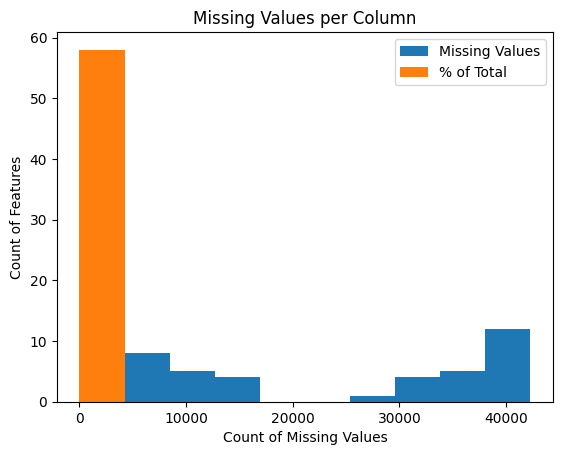

In [ ]:
isna_df[isna_df["Missing Values"]>0].plot(kind='hist')
plt.title('Missing Values per Column')
plt.ylabel('Count of Features')
plt.xlabel('Count of Missing Values')
plt.show()

We then categorize features based on their missing value counts, revealing two distinct groups: 36 features with moderate missingness (1-20k null values) and 22 features with more severe gaps (>20k nulls). By printing both subsets with their exact counts, we can make informed decisions about feature retention - the moderately missing features may be candidates for imputation, while those with excessive nulls might require removal. This stratification helps prioritize our data cleaning efforts where they're most needed.

In [ ]:
#We see that we have a total of 58 features with nans

display(isna_df[isna_df["Missing Values"]>0].sort_values(by="Missing Values", ascending = False))
print("")
print("Total Features with NaNs: ", len(isna_df[isna_df["Missing Values"]>0]))
print("Total Features with more than 20000 NaNs: ", len(isna_df[isna_df["Missing Values"]>20000]))
print("Total Features with less than 20000 NaNs: ", len(isna_df[(isna_df["Missing Values"]>0)&(isna_df["Missing Values"]<20000)]))

,Missing Values,% of Total
feature_148,42273,100.000000
feature_141,42273,100.000000
feature_114,42212,99.855700
feature_116,41619,98.452913
feature_138,41238,97.551629
feature_115,41112,97.253566
feature_139,40779,96.465829
feature_146,40181,95.051215
feature_145,39860,94.291865
feature_118,39702,93.918104



Total Features with NaNs:  58
Total Features with more than 20000 NaNs:  22
Total Features with less than 20000 NaNs:  36


In order to address features with NaNs, we will consider two different dataset types: one with NaNs that can be handled natively by some models, and another one with treated NaNs involving dropping and imputing, applying a stratification based on a collection of thresholds. In this case, features with at least 80% NaNs will be dropped, features with between 10% and 80% missingness will be imputed with mean and median for numeric cases and mode for categorical cases. This treatment will be applied at the preprocessing stage depending on the models used.

We now proceed with understanding the underlying data types of the features. Overall we identify 3 data types: int64 (total of 1, the id), Objects (total of 33, including the sample_date which will later be transformed to pd.date_time for analysis) and float 64 (total of 129, including the target variable).

In [ ]:
# Calculate Counts per Data Type
dtypes_df = pd.DataFrame(df.dtypes, columns=['dtype'])
display(dtypes_df['dtype'].value_counts())

,count
dtype,
float64,129
object,33
int64,1


Finally, it would be interesting to consider correlations between numerical features in order to determine relationships and also multicollinearity. We can have a brief overview of a number of such cases visualizing with a Heatmap

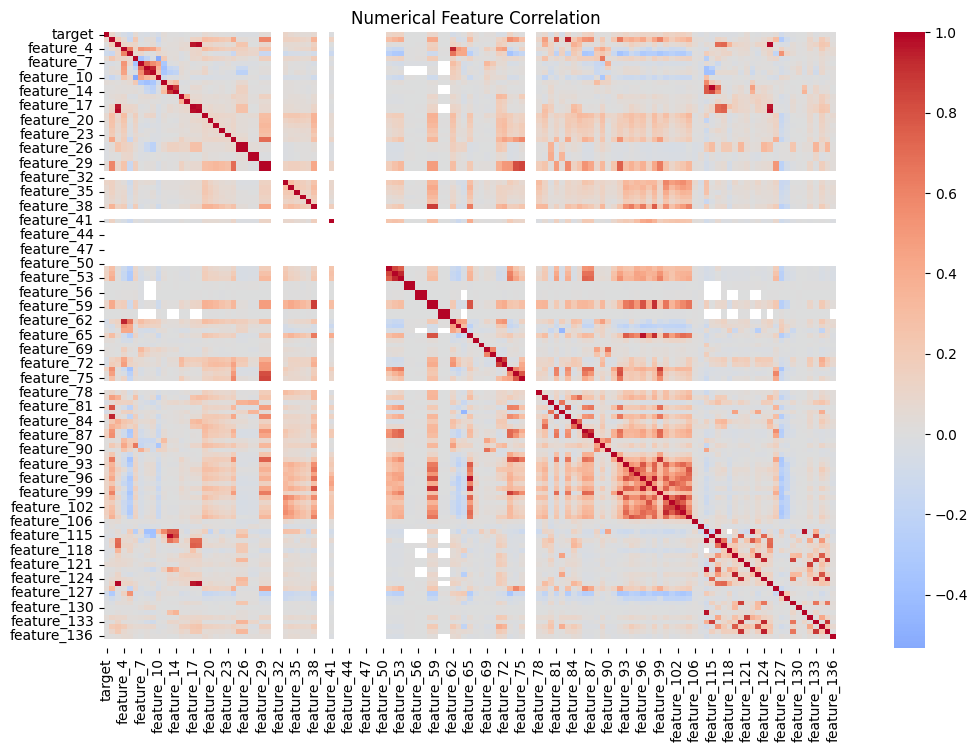

In [ ]:
# Visualize with Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes(include=['float64']).corr(), cmap='coolwarm', center=0)
plt.title('Numerical Feature Correlation')
plt.show()

We can drill down into more offending Features by applying a Hierarchical Heatmap to identify clusters of correlated Features

<Figure size 1200x1000 with 0 Axes>

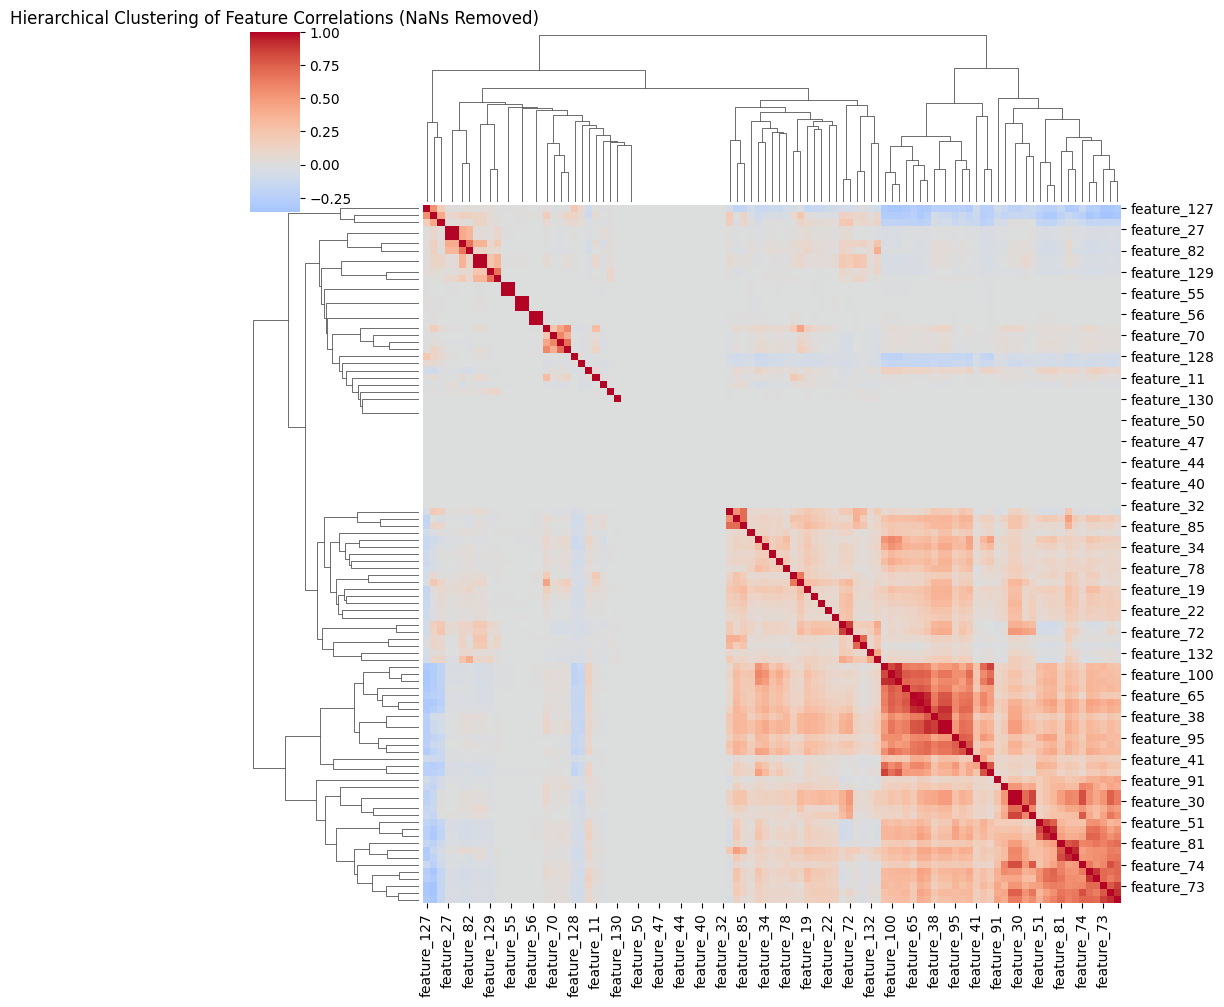

In [ ]:
# Computation of Hierarchical Clustering

# Select only numerical columns and drop columns with any NaNs
numerical_df_finite = df.select_dtypes(include=['float64', 'int64']).dropna(axis=1)

# Calculate correlation matrix
corr_matrix_finite = numerical_df_finite.corr()

# --- Temporary NaN handling for clustering ---
# Fill NaNs with 0 ONLY for the clustering step
corr_matrix_finite = corr_matrix_finite.fillna(0)


# Cluster features by correlation
plt.figure(figsize=(12, 10)) # Adjust size as needed
sns.clustermap(corr_matrix_finite, cmap='coolwarm', center=0)
plt.title('Hierarchical Clustering of Feature Correlations (NaNs Removed)')
plt.show()

In [ ]:
# Find pairs with |r| > threshold (e.g., 0.9) considering the NaNs
threshold = 0.9
high_corr_pairs = []
corr_matrix = df.select_dtypes(include=['float64', 'int64']).corr()
numerical_df = df.select_dtypes(include=['float64'])

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.append((
                corr_matrix.columns[i],
                corr_matrix.index[j],
                corr_matrix.iloc[i, j]
            ))

# Sort by absolute correlation
high_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

# Display top pairs
print("Highly correlated pairs (|r| > 0.9):")

final_pairs = []
unique_features = []
for pair in high_corr_pairs:
    if pair[0] not in [p[0] for p in final_pairs] and pair[1] not in [p[1] for p in final_pairs]:
        final_pairs.append(pair)
    unique_features.append(pair[0])
    unique_features.append(pair[1])
    print(f"{pair[0]} - {pair[1]}: {pair[2]:.2f}")

print("")
print(f"Total number of highly correlated pairs: {len(final_pairs)}")

Highly correlated pairs (|r| > 0.9):
feature_125 - feature_2: 1.00
feature_26 - feature_25: 1.00
feature_28 - feature_27: 1.00
feature_30 - feature_29: 1.00
feature_55 - feature_54: 1.00
feature_57 - feature_56: 1.00
feature_59 - feature_58: 1.00
feature_61 - feature_60: 1.00
feature_115 - feature_13: 0.99
feature_116 - feature_114: 0.99
feature_125 - feature_18: 0.99
feature_18 - feature_2: 0.98
feature_18 - feature_17: 0.98
feature_96 - feature_65: 0.97
feature_131 - feature_114: 0.97
feature_122 - feature_114: 0.97
feature_125 - feature_17: 0.96
feature_17 - feature_2: 0.96
feature_135 - feature_124: 0.95
feature_123 - feature_119: 0.94
feature_98 - feature_96: 0.94
feature_9 - feature_8: 0.94
feature_62 - feature_4: 0.94
feature_124 - feature_120: 0.94
feature_83 - feature_1: 0.94
feature_53 - feature_52: 0.93
feature_103 - feature_100: 0.93
feature_133 - feature_124: 0.93
feature_98 - feature_65: 0.92
feature_103 - feature_102: 0.92
feature_99 - feature_92: 0.91
feature_98 - featu

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

temp_df = numerical_df.apply(lambda col: col.fillna(col.median()))

def calculate_vif(df):

  # Create a temporary DataFrame with median-imputed values per column


  # Drop columns with zero variance (constant values) that become constant after imputation (to avoid VIF = ∞ errors)
  df = df.loc[:, df.std() > 0]
  print(f"Removed {len(df.columns) - len(df.columns)} constant features.")

  # Calculate VIF while handling potential numerical issues
  vif_data = pd.DataFrame()
  vif_data["feature"] = df.columns
  vif_data["VIF"] = [
      variance_inflation_factor(df.values, i)
      for i in range(df.shape[1])
  ]

  # Replace infinite VIFs (due to perfect multicollinearity) with NaN
  vif_data["VIF"] = vif_data["VIF"].replace([np.inf, -np.inf], np.nan)

  # Sort and display
  vif_data = vif_data.sort_values("VIF", ascending=False).dropna()
  print(vif_data)
  return vif_data


vif_data = calculate_vif(temp_df)
print(f"Total Number of High VIF features: {len(vif_data[vif_data['VIF']>=5])}")

Removed 0 constant features.


/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero

         feature           VIF
78    feature_96  39767.788376
50    feature_65  32486.761858
74    feature_92   1190.801221
11    feature_13    193.769128
8      feature_9    177.184016
..           ...           ...
0         target      1.189716
103  feature_128      1.123597
111  feature_136      1.072765
52    feature_68      1.007580
105  feature_130      1.003215

[98 rows x 2 columns]
Total Number of High VIF features: 64


In [ ]:
# Focus on features with VIF > 10 (more stringent threshold)
high_vif_features = vif_data[vif_data["VIF"] > 10]["feature"].tolist()
print(f"Features with VIF > 10: {len(high_vif_features)}")
display(vif_data[vif_data["VIF"] > 10])

Features with VIF > 10: 52


,feature,VIF
78,feature_96,39767.788376
50,feature_65,32486.761858
74,feature_92,1190.801221
11,feature_13,193.769128
8,feature_9,177.184016
99,feature_124,162.112380
100,feature_125,158.406393
1,feature_1,144.562946
2,feature_2,131.813559
90,feature_115,128.267814


We now see that dropping the highest VIF Features has led to a Healthier VIF table. Identifying such features to be dropped is important for Logistic Regression where multicollinearity may destabilize coefficient estimates. On the other hand, models such as XGBoost, CatBoost and Random Forests do not need VIF as they are immune to multicollinearity: they split on one feature at a time, and ignore redundant features when prioritizing useful ones. It is also not necessary for Neural Networks but it can be considered in order to make training faster (eg with Embeddings instead of VIF or PCA).

In [ ]:
# Drop Representative Features from Correlated Clusters
reduced_df = temp_df.drop(columns=high_vif_features)

# Recheck VIF
vif_reduced = calculate_vif(reduced_df)
print(vif_reduced.sort_values("VIF", ascending=False).head(10))

Removed 0 constant features.


/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


        feature       VIF
38   feature_75  7.461937
44   feature_89  5.889347
17   feature_34  4.554094
47  feature_106  4.334349
37   feature_73  3.989625
58  feature_132  3.958977
42   feature_87  3.772562
51  feature_121  3.661019
6    feature_20  3.569387
31   feature_64  3.525932
10   feature_24  3.338251
1     feature_6  3.138159
36   feature_71  3.137826
41   feature_84  3.054537
18   feature_35  3.043022
40   feature_81  2.831742
34   feature_69  2.540881
45   feature_90  2.520941
43   feature_88  2.490737
19   feature_36  2.339405
7    feature_21  2.273090
48  feature_116  1.960482
20   feature_37  1.900956
2    feature_10  1.888774
22   feature_51  1.753600
8    feature_22  1.734812
54  feature_127  1.688328
53  feature_126  1.642085
39   feature_80  1.627956
35   feature_70  1.551084
21   feature_41  1.504669
9    feature_23  1.475422
32   feature_67  1.415191
52  feature_122  1.390457
49  feature_117  1.370195
4    feature_15  1.358722
46   feature_91  1.287067
5    feature

# 2. FEATURE ENGINEERING & DATA PREPROCESSING

We take a better look at the object columns to find any inconsistencies. We see that some of them are in fact floats but are shown as strings. In addition we can encode some others by categories

In [ ]:
# Select only the columns of type 'object' (typically strings or mixed types) from the DataFrame
objects = df.select_dtypes(include=['object'])

# Get a list of the column names of the selected object-type columns
objects_cols = objects.columns.tolist()

# Display the first 100 rows of the object-type columns, showing all columns and rows
with pd.option_context('display.max_columns', None, 'display.max_rows', None):
    display(objects.head(100))


# Print the total number of object-type columns found in the DataFrame
print("")
print(f"Total Object Columns: {len(objects_cols)}")


,sample_date,feature_3,feature_12,feature_66,feature_105,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_137,feature_138,feature_139,feature_140,feature_142,feature_143,feature_144,feature_145,feature_146,feature_147,feature_149,feature_150,feature_151,feature_152,feature_153,feature_154,feature_155,feature_156,feature_157,feature_158,feature_159,feature_160
0,2020-04-02,c,c,02,N,525,408,359,700,700,618,c,NaN,NaN,c,c,NaN,b,NaN,NaN,c,c,a,c,c,c,c,c,c,c,c,NaN,a
1,2020-01-26,a,a,04,N,447,447,777,447,713,419,a,NaN,NaN,a,a,a,a,NaN,NaN,b,b,a,a,a,a,NaN,a,NaN,a,a,NaN,a
2,2020-06-08,b,b,02,Y,620,473,620,332,"332,635",473,a,NaN,NaN,a,a,b,b,NaN,NaN,b,b,a,b,b,b,b,b,b,b,a,NaN,a
3,2020-06-22,b,b,"02,26",Y,355,452,656,713,713,"447,656",a,NaN,NaN,a,a,b,b,NaN,NaN,b,b,b,b,b,b,b,b,b,b,a,a,a
4,2020-06-17,a,a,02,Y,711,419,419,711,711,"447,711",a,NaN,NaN,a,a,a,a,NaN,NaN,a,a,a,NaN,NaN,NaN,NaN,a,NaN,a,a,NaN,NaN
5,2020-05-27,b,b,02,Y,711,479,462,711,711,447,a,NaN,NaN,a,a,NaN,b,NaN,NaN,b,b,a,b,a,b,b,b,b,b,a,NaN,a
6,2020-02-28,a,a,02,Y,656,"252,408",635,657,657,656,a,NaN,NaN,a,a,a,a,NaN,NaN,a,a,a,a,a,a,NaN,a,NaN,a,a,a,a
7,2020-02-12,a,b,23,Y,408,408,777,"408,419",408,408,NaN,NaN,NaN,a,a,NaN,b,NaN,NaN,b,b,a,a,NaN,a,b,b,NaN,a,NaN,NaN,a
8,2020-03-09,a,a,23,N,408,657,408,"408,657",408,"408,657",NaN,NaN,NaN,a,a,NaN,a,NaN,NaN,a,a,a,a,NaN,a,NaN,a,NaN,a,NaN,NaN,a
9,2020-03-16,a,a,02,Y,691,473,618,713,713,678,a,NaN,NaN,a,a,b,b,NaN,NaN,b,a,a,a,a,a,NaN,b,NaN,a,a,NaN,a



Total Object Columns: 33


We can distinguish the following categories for the categorical features:

Aggregated Code columns: feature_66, feature_108, feature_109, feature_110, feature_111, feature_112, feature_113 (7)

Multi-label columns: feature_3, feature_12, feature_137, feature_138, feature_140, feature_142, feature_143, feature_144, feature_145, feature_146, feature_147, feature_149, feature_151, feature_151, feature_152, feature_153, feature_154, feature_155, feature_156, feature_157, feature_158, feature_159, feature_160(23)

Binary columns: feature_105, feature_141 (2)

We examine binary and multilabel encoded columns in a DataFrame, and print unique values for each specified feature to analyze label distribution and cardinality, then report the total number of such columns. The goal is quick validation of categorical feature encoding.


In [ ]:
# List of column names (presumably categorical or already label-encoded) to inspect
encoded = [
    "feature_3", "feature_12", "feature_105", "feature_137", "feature_138", "feature_139", "feature_140", "feature_142",
    "feature_143", "feature_144", "feature_145", "feature_146", "feature_147", "feature_149", "feature_150", "feature_151",
    "feature_152", "feature_153", "feature_154", "feature_155", "feature_156", "feature_157", "feature_158", "feature_159",
    "feature_160"
]

# Iterate through each column name in the list
for enc in encoded:

    print(f"Feature: {enc}")
    print(df[enc].unique())
    print(" ")

# Print the total number of features listed in 'encoded'
print(f"Total number of labelled columns: {len(encoded)}")

Feature: feature_3
['c' 'a' 'b' nan 'd' 'h' 'e' 'f']
 
Feature: feature_12
['c' 'a' 'b' 'd' 'i' nan 'h' 'k' 'j' 'f' 'e' 'g']
 
Feature: feature_105
['N' 'Y' nan]
 
Feature: feature_137
['c' 'a' nan 'b' 'd' 'h' 'j' 'i' 'e' 'f']
 
Feature: feature_138
[nan 'a' 'b' 'c' 'h' 'j' 'i' 'e' 'f' 'd']
 
Feature: feature_139
[nan 'a' 'b']
 
Feature: feature_140
['c' 'a' 'b' nan 'd']
 
Feature: feature_142
['c' 'a' 'b' nan 'd' 'h' 'j' 'i' 'e' 'f']
 
Feature: feature_143
[nan 'a' 'b' 'c' 'h' 'f' 'e' 'd' 'g' 'j' 'k' 'i']
 
Feature: feature_144
['b' 'a' 'c' nan 'f' 'h' 'e' 'd' 'g' 'j' 'i' 'k']
 
Feature: feature_145
[nan 'a' 'b' 'd' 'c' 'j' 'h' 'g' 'f' 'e' 'i' 'k']
 
Feature: feature_146
[nan 'a' 'c' 'b' 'e' 'd' 'h' 'f']
 
Feature: feature_147
['c' 'b' 'a' 'h' 'e' 'f' 'i' 'd' 'j' 'g' 'k']
 
Feature: feature_149
['c' 'b' 'a' nan 'i' 'd' 'f' 'e' 'g' 'h' 'k' 'j']
 
Feature: feature_150
['a' 'b' nan 'c' 'd' 'h' 'j' 'i' 'e' 'f' 'k']
 
Feature: feature_151
['c' 'a' 'b' nan 'd' 'f']
 
Feature: feature_152
['

We now perform an analysis of aggregated code columns in a DataFrame (df). The code first defines two lists of column names (aggcodes_cols and aggcodes_cols_old) that represent different versions of aggregated features. The code then creates a copy of the DataFrame (new) to work with. For each column in aggcodes_cols, it prints the unique values and the count of unique values present in that column, providing insight into the cardinality and distinct categories within each aggregated feature. Finally, it prints the total number of aggregated code columns being analyzed. This allows us to understand the composition and variability of categorical/aggregated features in the dataset, which is useful for feature engineering, data validation, or preprocessing steps before modeling. The comparison between old and new column name lists suggests this might be part of a data versioning or schema evolution analysis. In fact we can see that these features may refer to groups of internal classification codes each subject persists to by feature.

In [ ]:
# Define two sets of column names related to aggregated codes (current and older version)
aggcodes_cols = ["feature_66", "feature_108", "feature_109", "feature_110", "feature_111", "feature_112", "feature_113"]
aggcodes_cols_old = ["feature_68", "feature_110", "feature_111", "feature_112", "feature_113", "feature_114", "feature_115"]

# Create a copy of the original DataFrame to work with
new = df.copy()

# For each column in the aggregated codes list, print the unique values and their count
for col in aggcodes_cols:
    print(f"Column {col} uniques: ", new[col].unique())
    print(f"Column {col} uniques length: ", len(new[col].unique()))
    print("")

# Print the total number of aggregated code columns
print(f"Total number of aggregated code columns: {len(aggcodes_cols)}")

Column feature_66 uniques:  ['02' '04' '02,26' '23' '26' '05' '03' '05,26' '02,23' '27' '05,27'
 '02,04' '04,23' '02,27' '01' '21' '04,26' '47' '11' '02,21' '03,26'
 '23,26' '05,23' '02,23,26' '01,26' '01,02' '02,05' '02,03' '02,04,26'
 '02,21,23' '02,04,23' '02,23,27' '02,05,26' '01,23' '03,05' '03,23']
Column feature_66 uniques length:  36

Column feature_108 uniques:  ['525' '447' '620' '355' '711' '656' '408' '691' '714' '1643' '614' '413'
 '419' '713' '198' '618' '181' '253' '678' '657' '538,618' '700' '703'
 '691,1495' '497' '418' '332' '479' '708' '702' '618,1643' '448' '692'
 '359' '254' '346' '527' '715' '365' '473' '544' '361' '401'
 '618,691,1495' '218' '600' '1465' '692,1465' '525,692' '355,446' '717'
 '607' '228' '408,419' '2392' '716' '481' '425' '498' '355,481' '248'
 '1040' '198,618,692' '538' '556' '446' '525,618,678,1040' '525,691,1495'
 '961' '194' '678,691' '678,2392' '403' '170' '252' '706' '408,717'
 '618,691' '1538' '618,692' '485' '355,419' '390' '369' '1644' '4

We want to check the unique code elements in each row element. As such, we define a function to extract and count unique, cleaned values from columns that may contain comma-separated entries and inconsistent missing data (e.g. 'nan', NaN, empty strings). It then applies this function to each column in aggcodes_cols, prints the number of unique values per column, accumulates the total count, and stores the cleaned lists in a dictionary for further analysis.

In [ ]:
def get_unique_elements_and_count(series):
    """
    Returns all unique elements and their count from a pandas Series, handling:
    - Comma-separated values
    - NaN values
    - String representations ('nan', 'NaN', etc.)
    - Empty strings

    Args:
        series: pandas Series with potential comma-separated values

    Returns:
        tuple: (sorted list of unique elements, total unique count)
               Elements are strings with NaN represented as 'nan'
    """
    # Convert all values to strings (NaN becomes 'nan')
    str_series = series.astype(str)

    # Split comma-separated values and explode into individual elements
    split_elements = str_series.str.split(',').explode()

    # Clean each element
    split_elements = (
        split_elements
        .str.strip()  # Remove whitespace
        .replace(r'^(nan|NaN|NAN)$', np.nan, regex=True)  # Standardize NaN strings
        .replace('', np.nan)  # Empty strings → NaN
    )

    # Get unique elements (keeping NaN as a distinct value)
    unique_elements = split_elements.unique()

    # Convert to sorted list with 'nan' at the end
    unique_list = sorted(
        [str(x) if not pd.isna(x) else 'nan' for x in unique_elements],
        key=lambda x: (x == 'nan', x)  # Sort 'nan' last
    )

    # Get count (including NaN as one distinct value)
    unique_count = len(unique_list)

    return unique_list, unique_count

""" This code iterates over each encoded column, uses a helper function to extract and count cleaned unique values,
prints the count per column, accumulates the total across all columns, and stores the unique values in a dictionary for later use."""

total_aggcodes = 0
aggcol_cats_all = {}
for col in aggcodes_cols:
  print(f"{col}")
  col_cats, total = get_unique_elements_and_count(df[col])
  total_aggcodes += total
  aggcol_cats_all[col] = col_cats
  print(f"Unique elements in col {col}: {total}")

feature_66
Unique elements in col feature_66: 11
feature_108
Unique elements in col feature_108: 150
feature_109
Unique elements in col feature_109: 106
feature_110
Unique elements in col feature_110: 156
feature_111
Unique elements in col feature_111: 149
feature_112
Unique elements in col feature_112: 181
feature_113
Unique elements in col feature_113: 181


In [ ]:
# Visualize all unique code entries by feature
aggcol_cats_all

{'feature_66': ['01',
  '02',
  '03',
  '04',
  '05',
  '11',
  '21',
  '23',
  '26',
  '27',
  '47'],
 'feature_108': ['1028',
  '1040',
  '1042',
  '1079',
  '109',
  '1108',
  '1115',
  '1151',
  '116',
  '131',
  '139',
  '1400',
  '1404',
  '1409',
  '1428',
  '1447',
  '1465',
  '1486',
  '1495',
  '150',
  '1513',
  '1515',
  '1538',
  '1554',
  '1560',
  '1564',
  '1577',
  '1599',
  '1643',
  '1644',
  '168',
  '170',
  '181',
  '189',
  '194',
  '198',
  '2037',
  '215',
  '218',
  '2211',
  '228',
  '2392',
  '242',
  '248',
  '252',
  '253',
  '254',
  '260',
  '281',
  '293',
  '299',
  '301',
  '309',
  '325',
  '326',
  '332',
  '333',
  '340',
  '345',
  '346',
  '355',
  '356',
  '359',
  '361',
  '365',
  '369',
  '390',
  '401',
  '403',
  '408',
  '413',
  '418',
  '419',
  '420',
  '425',
  '427',
  '429',
  '433',
  '444',
  '446',
  '447',
  '448',
  '462',
  '464',
  '465',
  '466',
  '471',
  '473',
  '475',
  '479',
  '481',
  '483',
  '485',
  '486',
  '490',

In [ ]:
# Now for the encoded list we repeat the process
total_encoded = 0
encodedcol_cats_all = {}

for col in encoded:
  print(f"{col}")
  col_cats, total = get_unique_elements_and_count(df[col])
  total_encoded += total
  encodedcol_cats_all[col] = col_cats
  print(f"Unique elements in col {col}: {total}")

feature_3
Unique elements in col feature_3: 8
feature_12
Unique elements in col feature_12: 12
feature_105
Unique elements in col feature_105: 3
feature_137
Unique elements in col feature_137: 10
feature_138
Unique elements in col feature_138: 10
feature_139
Unique elements in col feature_139: 3
feature_140
Unique elements in col feature_140: 5
feature_142
Unique elements in col feature_142: 10
feature_143
Unique elements in col feature_143: 12
feature_144
Unique elements in col feature_144: 12
feature_145
Unique elements in col feature_145: 12
feature_146
Unique elements in col feature_146: 8
feature_147
Unique elements in col feature_147: 11
feature_149
Unique elements in col feature_149: 12
feature_150
Unique elements in col feature_150: 11
feature_151
Unique elements in col feature_151: 6
feature_152
Unique elements in col feature_152: 5
feature_153
Unique elements in col feature_153: 6
feature_154
Unique elements in col feature_154: 12
feature_155
Unique elements in col feature_15

In [ ]:
# Visualize all encoded unique codes by feature
encodedcol_cats_all

{'feature_3': ['a', 'b', 'c', 'd', 'e', 'f', 'h', 'nan'],
 'feature_12': ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'nan'],
 'feature_105': ['N', 'Y', 'nan'],
 'feature_137': ['a', 'b', 'c', 'd', 'e', 'f', 'h', 'i', 'j', 'nan'],
 'feature_138': ['a', 'b', 'c', 'd', 'e', 'f', 'h', 'i', 'j', 'nan'],
 'feature_139': ['a', 'b', 'nan'],
 'feature_140': ['a', 'b', 'c', 'd', 'nan'],
 'feature_142': ['a', 'b', 'c', 'd', 'e', 'f', 'h', 'i', 'j', 'nan'],
 'feature_143': ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'nan'],
 'feature_144': ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'nan'],
 'feature_145': ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'nan'],
 'feature_146': ['a', 'b', 'c', 'd', 'e', 'f', 'h', 'nan'],
 'feature_147': ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k'],
 'feature_149': ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'nan'],
 'feature_150': ['a', 'b', 'c', 'd', 'e', 'f', 'h', 'i', 'j', 'k', 'nan'],
 'feature_

In [ ]:
# Calculate total categories
total_cat = total_aggcodes + total_encoded
total_cat

1158

We check our assumption for the existence of internal classification codes, by performing a frequency analysis on feature_66, which appears to contain aggregated codes separated by commas. The code splits the values into individual codes, counts their occurrences, and visualizes the top 50 most frequent ones using a bar plot. This helps confirm that both individual and combined codes are common in the column, supporting the idea that it's an aggregated categorical feature.

/tmp/ipython-input-27-220529001.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=code_counts.index, y=code_counts.values, palette="viridis")


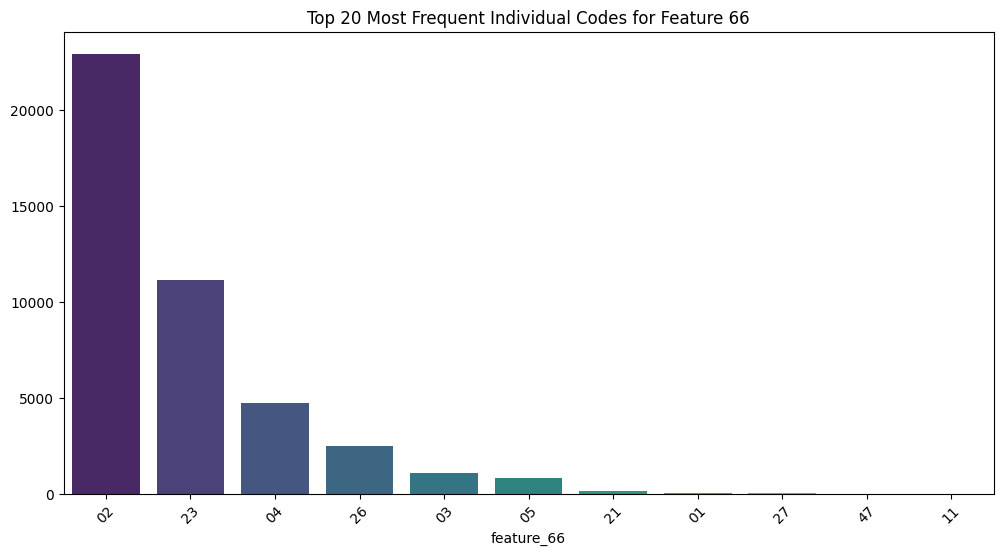

In [ ]:
  # Split and count individual codes for Feature 68

  all_codes = df['feature_66'].str.split(',').explode()
  code_counts = all_codes.value_counts().head(50)  # Top 20 codes

  # Plot
  plt.figure(figsize=(12, 6))
  sns.barplot(x=code_counts.index, y=code_counts.values, palette="viridis")
  plt.xticks(rotation=45)
  plt.title("Top 20 Most Frequent Individual Codes for Feature 66")
  plt.show()

Since we suspect these internal classification codes, we create a function that analyzes co-occurrence patterns within the internal classification codes (like those in the aggregated code columns) by building a network graph where each node represents a unique classification code and edges represent how frequently these codes appear together in the same record. It detects communities of closely related codes using the Louvain method and identifies key hubs with high connectivity, highlighting the most influential or central codes. Visualizing this network interactively helps reveal the underlying structure, clusters, and relationships among the internal codes, which is valuable for understanding their interactions, simplifying complex code groupings, and potentially improving how these codes are used in further analysis or modeling.

In [ ]:
def network_graph(col):
    """
    Performs network graph analysis on a column containing comma-separated codes.

    This function:
    - Builds a co-occurrence graph from values in the column.
    - Detects communities using the Louvain method.
    - Identifies high-degree hubs.
    - Visualizes the network interactively and saves it to HTML.
    - Prints a summary and community breakdown.

    Args:
        col (str): Column name in the dataframe `df` to analyze.
    """
    print(f"=== Network Graph Analysis for Column {col} ===")

    # 1. DATA PROCESSING

    net_df = df.copy()
    net_df[col] = df[col].fillna('').astype(str)

    edge_counts = defaultdict(int)      # Count co-occurrences between pairs of codes
    combo_counts = defaultdict(int)     # Track full combinations of codes per row

    for combo in net_df[col]:
        codes = list(set(combo.split(',')))  # Split codes and remove duplicates
        combo_counts[tuple(sorted(codes))] += 1
        for u, v in combinations(codes, 2):  # Count all pairwise co-occurrences
            edge_counts[(u, v)] += 1

    # Build undirected graph with weighted edges
    G = nx.Graph()
    for (u, v), weight in edge_counts.items():
        G.add_edge(u, v, weight=weight)

    # 2. COMMUNITY DETECTION

    # Detect communities via Louvain algorithm
    partition = community_louvain.best_partition(G, weight='weight', resolution=1.2)

    # Group nodes by community
    communities = defaultdict(list)
    for node, comm in partition.items():
        communities[comm].append(node)

    # Identify "hubs": top 5% nodes with highest weighted degree
    all_degrees = sorted(G.degree(weight='weight'), key=lambda x: -x[1])
    hub_cutoff = all_degrees[int(len(all_degrees) * 0.05)][1]
    hubs = [node for node, degree in all_degrees if degree >= hub_cutoff]

    # 3. VISUALIZATION

    # Create interactive network using PyVis
    net = Network(
        notebook=True,
        width="1400px",
        height="1000px",
        bgcolor="#222222",
        font_color="white",
        cdn_resources="in_line"
    )

    # Assign distinct color to each community
    colors = list(mcolors.TABLEAU_COLORS.values())
    community_colors = {comm: colors[i % len(colors)] for i, comm in enumerate(communities)}

    # Add nodes with styling based on community and hub status
    for node in G.nodes():
        comm = partition[node]
        is_hub = node in hubs
        degree = G.degree(node)
        full_combos = ', '.join(
            f"{'/'.join(map(str, k))} (x{v})"
            for k, v in combo_counts.items() if node in k
        )

        net.add_node(
            node,
            color=community_colors[comm],
            size=20 if is_hub else 10 + 3 * degree,
            title=f"""
            {node}
            Community: {comm}
            {'(HUB)' if is_hub else ''}
            Degree: {degree}
            Full combinations: {full_combos}
            """,
            shape="diamond" if is_hub else "dot",
            borderWidth=3 if is_hub else 1
        )

    # Add edges with thickness based on co-occurrence frequency
    for edge in G.edges():
        u_comm = partition[edge[0]]
        v_comm = partition[edge[1]]
        edge_color = community_colors[u_comm] if u_comm == v_comm else '#888888'

        net.add_edge(
            edge[0], edge[1],
            width=0.5 + G.edges[edge]['weight'] * 0.3,
            color=edge_color,
            title=f"Co-occurred {G.edges[edge]['weight']} times"
        )

    # Configure graph physics for better layout (force-directed)
    physics_options = """
    {
      "physics": {
        "forceAtlas2Based": {
          "gravitationalConstant": -100,
          "centralGravity": 0.05,
          "springLength": 150,
          "springConstant": 0.05,
          "damping": 0.3
        },
        "minVelocity": 0.5,
        "solver": "forceAtlas2Based",
        "stabilization": {
          "enabled": true,
          "iterations": 1000
        }
      }
    }
    """
    net.set_options(physics_options)

    # 4. SAVE AND SUMMARY

    output_file = f"full_network_visualization_{col}.html"
    net.save_graph(output_file)

    print(f"""
    COMPLETE NETWORK VISUALIZATION
    --------------------------------
    - Total nodes: {len(G.nodes())}
    - Total edges: {len(G.edges())}
    - Detected communities: {len(communities)}
    - Identified hubs: {len(hubs)} (nodes with degree ≥ {hub_cutoff})

    Output saved to: {output_file}
    """)

    # Print top nodes in each community
    print("COMMUNITY BREAKDOWN:")
    for comm, nodes in communities.items():
        most_connected = max(nodes, key=lambda x: G.degree(x))
        print(f"Community {comm} ({len(nodes)} nodes):")
        print(f"  {', '.join(nodes[:5])}" + ("..." if len(nodes) > 5 else ""))
        print(f"  Most connected: {most_connected}")
    print(" ")


In [ ]:
# Apply the function to the aggcodes_cols
for i, col in enumerate(aggcodes_cols):
  print(f"=={i}==")
  network_graph(col)

==0==
=== Network Graph Analysis for Column feature_66 ===

    COMPLETE NETWORK VISUALIZATION
    --------------------------------
    - Total nodes: 9
    - Total edges: 21
    - Detected communities: 4
    - Identified hubs: 1 (nodes with degree ≥ 1006)

    Output saved to: full_network_visualization_feature_66.html
    
COMMUNITY BREAKDOWN:
Community 1 (4 nodes):
  26, 02, 23, 01
  Most connected: 02
Community 0 (3 nodes):
  05, 27, 03
  Most connected: 05
Community 3 (1 nodes):
  04
  Most connected: 04
Community 2 (1 nodes):
  21
  Most connected: 21
 
==1==
=== Network Graph Analysis for Column feature_108 ===

    COMPLETE NETWORK VISUALIZATION
    --------------------------------
    - Total nodes: 93
    - Total edges: 407
    - Detected communities: 6
    - Identified hubs: 5 (nodes with degree ≥ 115)

    Output saved to: full_network_visualization_feature_108.html
    
COMMUNITY BREAKDOWN:
Community 0 (20 nodes):
  538, 618, 691, 1495, 1643...
  Most connected: 618
Commun

We can clearly see from the respective graph networks that these object columns constitute aggregated codes and will be treated accordingly in the preprocessing.

Finally, we analyze the distribution of sample dates in the dataset to confirm temporal patterns and identify any gaps or breaks in the timeline. By converting the date column to datetime, counting the number of records per date, and visualizing these counts over time, we can detect irregularities or pauses in data collection. Detecting such breaks is important because it helps determine an appropriate point to split the data into training and testing sets, ensuring that the test set represents a true future period and prevents data leakage for time-dependent modeling. It is interesting to point towards such break, which is early April 2020 and will be the cutoff point used for the consequent split of our data prior to modelling

Date frequencies:
 sample_date
2019-09-04      1
2019-09-05      1
2019-09-22      1
2019-09-24      2
2019-09-25      5
             ... 
2020-06-22    367
2020-06-23    325
2020-06-24    383
2020-06-25    374
2020-06-26    268
Name: count, Length: 279, dtype: int64


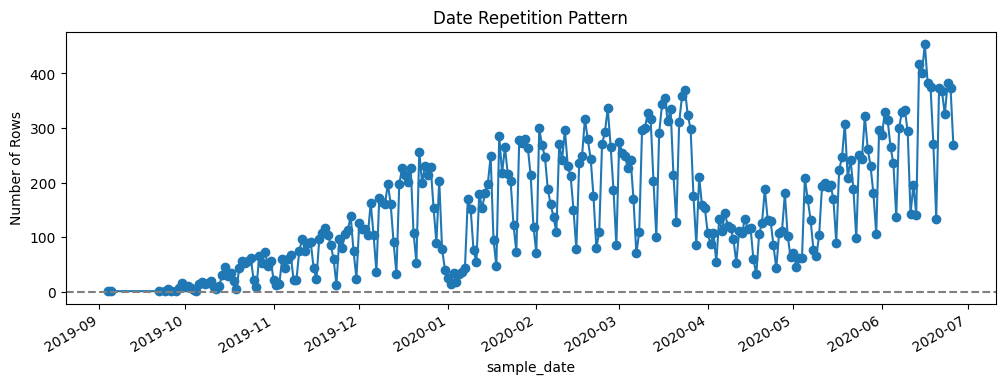

In [ ]:
test_time = df.copy()

# Convert to datetime
test_time['sample_date'] = pd.to_datetime(test_time['sample_date'])

# Check date repetition patterns
date_counts = test_time['sample_date'].value_counts().sort_index()
print("Date frequencies:\n", date_counts)

# Visualize date gaps
plt.figure(figsize=(12, 4))
date_counts.plot(marker='o')
plt.title("Date Repetition Pattern")
plt.ylabel("Number of Rows")
plt.axhline(0, color='gray', linestyle='--')
plt.show()

Prior to modeling we will have to do some preprocessing and treat the other categorical variables. They will be encoded through binning to ensure consistency across the dataset. For Features 105 & 139 which are binary, without information on ordinality, we will consider two cases: binary encoding to use with traditional ML models and one-hot encoding for pytorch-based NN to account for meaningful information for the 0 case (for example Type I and II errors which are important in risk modelling for credit defaults). For the aggregated internal classification code features in aggcodes_cols we will use a MultiLabel Binarizer, which encodes all present codes and assigns 1 if for a specific respective feature's row element, a code is present. For the other cases we will consider one-hot encoding since we do not have ordinality information.




# Neural Networks

For Neural Networks, we implement a complete time-series data preprocessing and modeling pipeline. First, we treats NaNs, then processes raw time-stamped data by cleaning and transforming features—handling categorical variables through one-hot encoding and multi-label binarization for aggregated codes, scaling numerical features, and extracting temporal characteristics like day-of-week and month. The pipeline strictly splits data chronologically to prevent time-based leakage, converts the processed features into sliding window sequences of three timesteps, and packages them into PyTorch Training, Validation and Test DataLoaders for efficient batch processing during model training. Key components include specialized functions for processing different data types while maintaining temporal relationships, plus utilities for saving preprocessing artifacts to ensure reproducibility.

The preprocess_aggregated_codes function processes columns containing aggregated comma-separated codes into binary indicator features using multi-label binarization. For each specified column, it handles missing values, splits comma-delimited strings into individual codes, and converts them into binary columns (one per unique code) while ensuring consistent categories between train and test sets. It replaces NaNs with empty lists during binarization while adding binary indicator columns (e.g., [col]_isNaN) to explicitly track missingness. The function uses MultiLabelBinarizer to convert comma-separated codes into binary features, ensuring consistency between train and test sets via predefined categories (aggcol_cats_all). The output is a purely numerical DataFrame (0s and 1s) combining binarized codes and NaN flags, ready for conversion to PyTorch tensors. This approach preserves missing data patterns without introducing redundant dimensions, optimizing memory efficiency and model interpretability for neural networks.The transformation preserves the original DataFrame indices and returns the binarized features along with the cleaned DataFrames and fitted binarizers for each column. The implementation guarantees category consistency by requiring a predefined list of all possible categories (aggcol_cats_all) for each column, preventing test-set-only categories from causing errors.

In [ ]:
df_nn = df.copy()
df_nn['sample_date'] = pd.to_datetime(df_nn['sample_date'])
df_nn.sort_values(by = 'sample_date', ascending= True, inplace = True)

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd
import numpy as np

def preprocess_aggregated_codes(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    aggcodes_cols: list,
    aggcol_cats_all: dict,
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, dict]:
    """Preprocess aggregated code columns for PyTorch with NaN flags.

    Args:
        train_df: Training DataFrame with raw aggregated code columns.
        test_df: Test DataFrame with raw aggregated code columns.
        aggcodes_cols: List of column names containing aggregated codes.
        aggcol_cats_all: Dictionary mapping columns to all possible categories.

    Returns:
        tuple: (train_df, test_df, binarized_train, binarized_test, mlb_dict)
            - Original DataFrames with code columns removed.
            - Binarized DataFrames with NaN flags.
            - Fitted MultiLabelBinarizer objects.
    """
    # Initialize containers
    binarized_train_dfs = []
    binarized_test_dfs = []
    nan_flags_train = pd.DataFrame(index=train_df.index)
    nan_flags_test = pd.DataFrame(index=test_df.index)
    mlb_dict = {}

    for col in aggcodes_cols:
        # --- Step 1: Configure Binarizer ---
        mlb = MultiLabelBinarizer(classes=aggcol_cats_all[col])

        # --- Step 2: Create NaN Flags ---
        nan_flags_train[f"{col}_isNaN"] = train_df[col].isna().astype(int)
        nan_flags_test[f"{col}_isNaN"] = test_df[col].isna().astype(int)

        # --- Step 3: Clean and Binarize Codes ---
        # Replace NaNs with empty lists, then split codes
        train_codes = (
            train_df[col]
            .fillna("")  # Impute NaNs temporarily
            .astype(str)
            .str.split(',')
            .apply(lambda x: [code.strip() for code in x if code.strip()])
        )
        test_codes = (
            test_df[col]
            .fillna("")
            .astype(str)
            .str.split(',')
            .apply(lambda x: [code.strip() for code in x if code.strip()])
        )

        # Binarize
        train_binarized = mlb.fit_transform(train_codes)
        test_binarized = mlb.transform(test_codes)

        # --- Step 4: Store Results ---
        mlb_dict[col] = mlb
        binarized_train_dfs.append(
            pd.DataFrame(
                train_binarized,
                columns=[f"{col}_{code}" for code in mlb.classes_],
                index=train_df.index
            )
        )
        binarized_test_dfs.append(
            pd.DataFrame(
                test_binarized,
                columns=[f"{col}_{code}" for code in mlb.classes_],
                index=test_df.index
            )
        )

    # --- Step 5: Combine Features ---
    # Merge binarized codes and NaN flags
    binarized_train = pd.concat(binarized_train_dfs + [nan_flags_train], axis=1)
    binarized_test = pd.concat(binarized_test_dfs + [nan_flags_test], axis=1)

    # Drop original code columns
    train_df = train_df.drop(aggcodes_cols, axis=1)
    test_df = test_df.drop(aggcodes_cols, axis=1)

    return train_df, test_df, binarized_train, binarized_test, mlb_dict

The add_time_features function enhances processed data with temporal features by first ensuring the input is a DataFrame, then calculating four key time-based metrics: days elapsed since the earliest date, month number, weekday number, and a binary weekend indicator, all derived from the "sample_date" column, before finally merging these new features with the existing processed data while maintaining consistent row indexing.

In [ ]:
def add_time_features(
    df: pd.DataFrame,
    processed_data: Union[pd.DataFrame, np.ndarray]
) -> pd.DataFrame:
    """Generate time features using only within-sample information to prevent data leakage.

    Creates safe temporal features that can be computed without future knowledge,
    including month, day of week, weekend indicator, and days since first observation.

    Args:
        df: Original DataFrame containing a 'sample_date' column with datetime information
        processed_data: DataFrame or array to which the time features will be added

    Returns:
        pd.DataFrame: Combined DataFrame with original processed_data and new time features

    Note:
        All time features are computed using only information available at the time of
        each observation to maintain temporal integrity.
    """
    if not isinstance(processed_data, pd.DataFrame):
        processed_data = pd.DataFrame(processed_data, index=df.index)

    time_features = pd.DataFrame({
        "month": df["sample_date"].dt.month,
        "day_of_week": df["sample_date"].dt.dayofweek,
        "is_weekend": (df["sample_date"].dt.dayofweek >= 5).astype(int),
        "days_since_start": (df["sample_date"] - df["sample_date"].min()).dt.days
    }, index=df.index)

    return pd.concat([processed_data, time_features], axis=1)

The time_series_pipeline function implements a comprehensive time-series preprocessing pipeline that first identifies categorical (object) and numerical (float/int) columns while excluding specified columns like 'sample_date' and 'target', then processes the data through several key steps: converting and sorting by datetime, performing a strict temporal train-test split before April 2020, transforming aggregated codes into binary features via preprocess_aggregated_codes, applying one-hot encoding to categorical variables and standardization to numerical features using a ColumnTransformer, combining these processed features with the binarized codes, and finally enriching the dataset with temporal features (days since start, month, weekday, weekend indicator) through the add_time_features function, ultimately returning fully processed training and test sets with their corresponding targets and the fitted preprocessor object for consistent future transformations.

In [ ]:
"""NaNs handling with Simple Imputer and no dimensionality reduction """

from sklearn.impute import SimpleImputer


# Identify categorical and numerical columns for processing
# Exclude aggregated code columns and the sample_date from categorical features
cat_cols = [
    col for col in df_nn.select_dtypes(include=["object"]).columns
    if col not in aggcodes_cols and col != "sample_date"
]

# Identify numerical columns (float/int types), excluding the target variable
num_cols = df_nn.select_dtypes(include=['float64']).drop('target', axis=1).columns.tolist()

def time_series_pipeline(
    df: pd.DataFrame,
    aggcodes_cols: list,
    aggcol_cats_all: dict,
    encodedcol_cats_all: dict,
    cat_cols: list,
    num_cols: list,
    split_date: str = "2020-04-21",
) -> tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, ColumnTransformer]:
    """Execute complete time-series data preprocessing pipeline.

    Performs end-to-end preprocessing including:
    - Datetime conversion and sorting
    - Time-based train/test split
    - Aggregated code processing
    - Categorical encoding and numerical scaling
    - Feature combination and time feature addition

    Args:
        df: Raw input DataFrame containing time-series data.
        aggcodes_cols: List of columns containing aggregated codes.
        aggcol_cats_all: Dictionary of all possible categories for aggregated codes.
        encodedcol_cats_all: Dictionary of all categories for one-hot encoding.
        cat_cols: List of categorical column names.
        num_cols: List of numerical column names.
        split_date: Date string to split train/test data (YYYY-MM-DD format).

    Returns:
        tuple: Contains processed data and transformer:
            - X_train_final: Processed training features.
            - X_test_final: Processed test features.
            - y_train: Training target values.
            - y_test: Test target values.
            - preprocessor: Fitted ColumnTransformer for future transformations.

    Raises:
        ValueError: If split_date is not valid or required columns are missing.
    """
    # Validate input data
    if "sample_date" not in df.columns or "target" not in df.columns:
        raise ValueError("Input DataFrame must contain 'sample_date' and 'target' columns")

    try:
        split_date = pd.to_datetime(split_date)
    except ValueError as e:
        raise ValueError(f"Invalid split_date format: {e}") from e

    # Convert and sort by datetime
    df = df.copy()
    df["sample_date"] = pd.to_datetime(df["sample_date"])
    df = df.sort_values(by="sample_date").reset_index(drop=True)

    # Handle missing values
    df[cat_cols] = df[cat_cols].fillna("MISSING")

    # Time-based split
    train_df = df[df["sample_date"] < split_date]
    test_df = df[df["sample_date"] >= split_date]

    # Process aggregated code columns
    train_df, test_df, agg_train, agg_test, _ = preprocess_aggregated_codes(
        train_df=train_df,
        test_df=test_df,
        aggcodes_cols=aggcodes_cols,
        aggcol_cats_all=aggcol_cats_all,
    )

    # Configure preprocessing pipeline
    categorical_transformer = OneHotEncoder(
        categories=[encodedcol_cats_all[col] for col in cat_cols],
        handle_unknown="ignore",
        sparse_output=False,
    )

    numerical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("onehot", categorical_transformer, cat_cols),
            ("num", numerical_transformer, num_cols),
        ],
        remainder="drop",
        verbose_feature_names_out=False,
    )

    # Prepare features and targets
    X_train = train_df.drop(["target", "sample_date"], axis=1)
    y_train = train_df["target"].astype(int)
    X_test = test_df.drop(["target", "sample_date"], axis=1)
    y_test = test_df["target"].astype(int)

    # Fit and transform data
    preprocessor.fit(X_train)
    feature_names = preprocessor.get_feature_names_out()

    X_train_processed = pd.DataFrame(
        data=preprocessor.transform(X_train),
        columns=feature_names,
        index=X_train.index,
    )

    X_test_processed = pd.DataFrame(
        data=preprocessor.transform(X_test),
        columns=feature_names,
        index=X_test.index,
    )

    # Combine processed features
    X_train_final = pd.concat([X_train_processed, agg_train], axis=1)
    X_test_final = pd.concat([X_test_processed, agg_test], axis=1)

    # Add time features
    X_train_final = add_time_features(train_df, X_train_final)
    X_test_final = add_time_features(test_df, X_test_final)

    return X_train_final, X_test_final, y_train, y_test, preprocessor


# Execute the pipeline
X_train_final_nn, X_test_final_nn, y_train_final_nn, y_test_final_nn, preprocessor_nn = time_series_pipeline(
    df_nn, aggcodes_cols, aggcol_cats_all, encodedcol_cats_all, cat_cols, num_cols
)

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['feature_141' 'feature_148']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['feature_141' 'feature_148']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['feature_141' 'feature_148']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


We finalize the time-series data preparation by creating training, validation, and test datasets using the custom TimeSeriesDataset class. For training and validation, we use time-series cross-validation (TimeSeriesSplit) to generate multiple folds, each with non-overlapping chronological segments ensuring temporal order is preserved. For each fold, DataLoaders are initialized with a batch size of 32 and a custom collate function that stacks sequences into 3D tensors [batch_size, sequence_length, num_features] and targets into 1D tensors [batch_size]. Training loaders shuffle data within folds to improve generalization, while validation and test loaders do not shuffle, preserving temporal consistency. All loaders are optimized for GPU transfer using pinned memory and parallel data loading with multiple workers. The pipeline saves preprocessing artifacts (feature names, timestamps) as versioned artifacts for reproducibility, and verifies data loader outputs by printing batch tensor shapes to ensure proper input formatting for model training.

The TimeSeriesDataset class efficiently handles sequential data by sliding a window of fixed length (default 3) over the chronological DataFrame, extracting sequences of features and their corresponding target at the last timestep. It supports precomputed valid indices to ensure train/validation splits conform to cross-validation folds without leakage. This design enables precise control over data sampling, preparing batches of shape [BATCH_SIZE, SEQUENCE_LENGTH, num_features] for training and evaluation while respecting time dependencies crucial in sequential forecasting tasks.

In [ ]:
# Define Parameters
SEQUENCE_LENGTH = 3
BATCH_SIZE = 32

# Initialize dataframes
df_train_final_nn = pd.concat([X_train_final_nn, y_train_final_nn], axis=1)
df_test_final_nn = pd.concat([X_test_final_nn, y_test_final_nn], axis=1)

class TimeSeriesDataset(Dataset):
    """Optimized dataset for time series sequences with cross-validation support."""

    def __init__(self, dataframe: pd.DataFrame, sequence_length: int = SEQUENCE_LENGTH,
                 indices: np.ndarray = None):
        """
        Args:
            dataframe: DataFrame with features and 'target' column
            sequence_length: Length of input sequences
            indices: Optional array of precomputed valid indices for cross-validation
        """
        self.data = dataframe
        self.sequence_length = sequence_length

        if indices is not None:
            # Use precomputed indices for CV folds
            self.valid_indices = indices
        else:
            # Generate all possible sequence start positions
            self.valid_indices = np.arange(len(dataframe) - sequence_length + 1)

    def __len__(self) -> int:
        return len(self.valid_indices)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        """Returns sequence and target with proper time ordering."""
        start_idx = self.valid_indices[idx]
        end_idx = start_idx + self.sequence_length
        sequence = self.data.iloc[start_idx:end_idx]

        # Convert to tensors
        features = torch.tensor(
            sequence.drop('target', axis=1).values,
            dtype=torch.float32
        )
        target = torch.tensor(
            sequence['target'].values[-1],
            dtype=torch.float32
        )

        return features, target


def collate_fn(batch: list) -> tuple[torch.Tensor, torch.Tensor]:
    """Optimized collation for time series batches.

    Args:
        batch: List of (features, target) tuples

    Returns:
        Tuple of (batched_features, batched_targets) where:
        - batched_features: shape [batch_size, sequence_length, num_features]
        - batched_targets: shape [batch_size]
    """
    # Stack sequences along batch dimension
    features = torch.stack([item[0] for item in batch])
    targets = torch.stack([item[1] for item in batch])
    return features, targets


def create_cv_datasets(
    dataframe: pd.DataFrame,
    n_splits: int = 5
) -> list[tuple[DataLoader, DataLoader]]:
    """Create time-series cross-validation DataLoaders.

    Args:
        dataframe: Full training DataFrame
        n_splits: Number of CV folds

    Returns:
        List of (train_loader, val_loader) tuples for each fold
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    cv_loaders = []

    # Convert to numpy for efficient indexing
    data_np = dataframe.values

    for train_idx, val_idx in tscv.split(data_np):
        # Create datasets with proper sequence indices
        train_dataset = TimeSeriesDataset(
            dataframe,
            sequence_length=SEQUENCE_LENGTH,
            indices=train_idx[train_idx <= len(dataframe) - SEQUENCE_LENGTH]
        )

        val_dataset = TimeSeriesDataset(
            dataframe,
            sequence_length=SEQUENCE_LENGTH,
            indices=val_idx[val_idx <= len(dataframe) - SEQUENCE_LENGTH]
        )

        # Create DataLoaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=BATCH_SIZE,
            shuffle=True,
            collate_fn=collate_fn,
            num_workers=2,
            pin_memory=True
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=BATCH_SIZE,
            shuffle=False,
            collate_fn=collate_fn,
            num_workers=2,
            pin_memory=True
        )

        cv_loaders.append((train_loader, val_loader))

    return cv_loaders


# Usage Example:
if __name__ == "__main__":

    cv_datasets = create_cv_datasets(df_train_final_nn, n_splits=5)


    test_dataset = TimeSeriesDataset(df_test_final_nn)
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        collate_fn=collate_fn
    )

# Verify data loader configurations
print("\nData Loader Verification:")
print(f"Train batches: {len(train_loader)}")  # Total training batches per epoch
print(f"Test batches: {len(test_loader)}")    # Total test batches




Data Loader Verification:
Train batches: 871
Test batches: 451


In [ ]:
df_train_final_nn.head()

,feature_3_a,feature_3_b,feature_3_c,feature_3_d,feature_3_e,feature_3_f,feature_3_h,feature_3_nan,feature_12_a,feature_12_b,...,feature_109_isNaN,feature_110_isNaN,feature_111_isNaN,feature_112_isNaN,feature_113_isNaN,days_since_start,month,day_of_week,is_weekend,target
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,9,2,0,0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,1,9,3,0,0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,18,9,6,1,0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,20,9,1,0,0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,20,9,1,0,0


In [ ]:
# We can check the binarization for an aggregated internal classification code feature, such as feature 113
feature_113_cols = [col for col in df_train_final_nn.columns if 'feature_113' in col]
feature_113_data = df_train_final_nn[feature_113_cols]
display(feature_113_data)


,feature_113_1028,feature_113_1040,feature_113_1042,feature_113_1044,feature_113_1079,feature_113_109,feature_113_1096,feature_113_1108,feature_113_1115,feature_113_114,...,feature_113_906,feature_113_910,feature_113_911,feature_113_934,feature_113_937,feature_113_954,feature_113_959,feature_113_961,feature_113_965,feature_113_isNaN
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27861,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27862,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27863,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27864,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Machine Learning

In [ ]:
df_ml = df.copy()
df_ml.drop(columns = ["id"], inplace = True)


In [ ]:
df_ml[:50]

,sample_date,target,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_151,feature_152,feature_153,feature_154,feature_155,feature_156,feature_157,feature_158,feature_159,feature_160
0,2020-04-02,1.0,7.0,155621.0,c,66.0,6.0,4.0,3.0,NaN,...,c,c,c,c,c,c,c,c,NaN,a
1,2020-01-26,0.0,3.0,8079.0,a,94.0,17.0,0.0,NaN,NaN,...,a,a,a,NaN,a,NaN,a,a,NaN,a
2,2020-06-08,0.0,4.0,52431.0,b,117.0,17.0,4.0,NaN,NaN,...,b,b,b,b,b,b,b,a,NaN,a
3,2020-06-22,0.0,7.0,102739.0,b,89.0,14.0,9.0,NaN,NaN,...,b,b,b,b,b,b,b,a,a,a
4,2020-06-17,0.0,2.0,0.0,a,21.0,17.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,a,NaN,a,a,NaN,NaN
5,2020-05-27,0.0,5.0,87430.0,b,43.0,11.0,2.0,NaN,NaN,...,b,a,b,b,b,b,b,a,NaN,a
6,2020-02-28,0.0,3.0,0.0,a,40.0,11.0,0.0,NaN,NaN,...,a,a,a,NaN,a,NaN,a,a,a,a
7,2020-02-12,0.0,0.0,0.0,a,86.0,16.0,3.0,NaN,NaN,...,a,NaN,a,b,b,NaN,a,NaN,NaN,a
8,2020-03-09,0.0,0.0,0.0,a,16.0,12.0,0.0,NaN,NaN,...,a,NaN,a,NaN,a,NaN,a,NaN,NaN,a
9,2020-03-16,0.0,9.0,42457.0,a,65.0,7.0,0.0,NaN,NaN,...,a,a,a,NaN,b,NaN,a,a,NaN,a


### Catboost/XGBoost/RF


First we preprocesses aggregated categorical code columns in training and test datasets for Catboost/XGBoost/RF. For each specified aggregated code column, the function first handles missing or 'nan' entries explicitly by replacing them with a 'NaN' token, then splits the comma-separated codes into lists. Using a MultiLabelBinarizer fitted on all known categories, it converts these lists into binary indicator columns representing the presence of each code. This binarization is done separately for train and test sets to ensure consistent encoding. The function returns the original train and test DataFrames with the aggregated code columns removed, alongside new DataFrames of binarized features for both sets, plus a dictionary of the fitted binarizers to enable consistent encoding in later stages or new data.

In [ ]:

def preprocess_aggregated_codes_ml(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    aggcodes_cols: list[str],
    aggcol_cats_all: dict[str, list] = None
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, dict]:
    """Enhanced version with better NaN handling for tree-based models"""
    # Generate categories from training data if not provided
    if aggcol_cats_all is None:
        aggcol_cats_all = {
            col: list(train_df[col].astype(str).str.split(',').explode().str.strip().unique())
            for col in aggcodes_cols
        }

    agg_features_train = []
    agg_features_test = []
    mlb_dict = {}

    for col in aggcodes_cols:
        all_categories = aggcol_cats_all[col]
        mlb = MultiLabelBinarizer(classes=all_categories)

        # Process with explicit NaN handling
        def process_series(s):
            return (
                s
                .astype(str)
                .str.split(',')
                .apply(lambda x: ['NaN'] if x == ['nan'] else [code.strip() for code in x if code.strip()])
            )

        train_codes = process_series(train_df[col])
        test_codes = process_series(test_df[col])

        # Fit/transform
        train_binarized = mlb.fit_transform(train_codes)
        test_binarized = mlb.transform(test_codes)

        mlb_dict[col] = mlb

        # Create DataFrames
        agg_features_train.append(
            pd.DataFrame(
                train_binarized,
                columns=[f"{col}_{code}" for code in mlb.classes_],
                index=train_df.index
            )
        )
        agg_features_test.append(
            pd.DataFrame(
                test_binarized,
                columns=[f"{col}_{code}" for code in mlb.classes_],
                index=test_df.index
            )
        )

    # Combine features
    agg_train = pd.concat(agg_features_train, axis=1)
    agg_test = pd.concat(agg_features_test, axis=1)

    # Remove original columns
    train_df = train_df.drop(aggcodes_cols, axis=1)
    test_df = test_df.drop(aggcodes_cols, axis=1)

    return train_df, test_df, agg_train, agg_test, mlb_dict


We proceed by implementing a comprehensive preprocessing pipeline for time series data with mixed feature types, carefully handling missing values according to the specific requirements of different tree-based models (CatBoost, XGBoost, and general tree models). The time_series_pipeline_ml function identifies categorical and numerical columns, sorts and splits the data by date to maintain temporal order, and transforms aggregated categorical codes into binary indicators. Depending on the model, it applies tailored NaN treatments—using sentinel values or leaving NaNs intact—to leverage model-native handling or enforce explicit replacements. Special binary encodings are applied to key categorical features, and a ColumnTransformer orchestrates one-hot encoding (except for CatBoost), binary encoding, and passthrough of numerical features. The pipeline fits and transforms training and test data, reconstructs DataFrames with meaningful feature names, and combines these with aggregated code features and time-based engineered features. The result is a clean, consistent, and model-specific dataset that preserves temporal structure and is optimized for training and evaluating tree-based algorithms.

In [ ]:

def time_series_pipeline_ml_tree(
    df: pd.DataFrame,
    aggcodes_cols: list[str] = None,
    aggcol_cats_all: dict[str, list] = None,
    encodedcol_cats_all: dict[str, list] = None,
    model_type: str = 'xgb' # or 'catboost', 'general'
) -> tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, np.ndarray]:
    """Leakage-proof time series pipeline"""
    # Convert and sort by datetime
    df = df.copy()
    df['sample_date'] = pd.to_datetime(df['sample_date'])
    df = df.sort_values(by='sample_date', ascending=True).reset_index(drop=True)

    # Time-based split (FIRST STEP - no future knowledge)
    split_date = pd.to_datetime('2020-04-21')
    train_df = df[df['sample_date'] < split_date]
    test_df = df[df['sample_date'] >= split_date]

    # Validate no temporal leakage
    assert test_df['sample_date'].min() >= train_df['sample_date'].max(), "Temporal leak detected"

    # Derive columns from training data only
    cat_cols = [
        col for col in train_df.select_dtypes(include=["object"]).columns
        if col not in (aggcodes_cols or [])
        and col not in ["feature_105", "feature_139", "sample_date"]
    ]
    num_cols = train_df.select_dtypes(include=['float64', 'int64']).drop('target', axis=1).columns.tolist()

    # Generate categories from training data if not provided
    if encodedcol_cats_all is None:
        encodedcol_cats_all = {
            col: list(train_df[col].astype(str).unique())
            for col in cat_cols
        }

    # Process aggregated codes
    train_df, test_df, agg_train, agg_test, _ = preprocess_aggregated_codes_ml(
        train_df, test_df, aggcodes_cols or [], aggcol_cats_all
    )

    # Model-specific preprocessing
    if model_type == 'catboost':
        # CATBOOST - preserve NaN categories
        train_df[num_cols] = train_df[num_cols].fillna(-999)
        test_df[num_cols] = test_df[num_cols].fillna(-999)

        def binary_encode_ab(X: np.ndarray) -> np.ndarray:
            X = X.astype(object)
            return np.where(X == 'a', 1,
                          np.where(X == 'b', 0,
                          np.where(pd.isna(X), np.nan, -1))).reshape(-1, 1)

        def binary_encode_yn(X: np.ndarray) -> np.ndarray:
            X = X.astype(object)
            return np.where(X == 'Y', 1,
                          np.where(X == 'N', 0,
                          np.where(pd.isna(X), np.nan, -1))).reshape(-1, 1)

    elif model_type == 'xgb':
        # XGBOOST - explicit missing handling
        train_df[cat_cols] = train_df[cat_cols].fillna('missing')
        test_df[cat_cols] = test_df[cat_cols].fillna('missing')
        train_df[num_cols] = train_df[num_cols].fillna(-999)
        test_df[num_cols] = test_df[num_cols].fillna(-999)

        def binary_encode_ab(X: np.ndarray) -> np.ndarray:
            return np.where(X == 'a', 1,
                          np.where(X == 'b', 0,
                          np.where(X == 'missing', -1, -2))).reshape(-1, 1)

        def binary_encode_yn(X: np.ndarray) -> np.ndarray:
            return np.where(X == 'Y', 1,
                          np.where(X == 'N', 0,
                          np.where(X == 'missing', -1, -2))).reshape(-1, 1)

    else:  # GENERAL TREE MODEL
        for col in cat_cols:
            if 'missing' not in encodedcol_cats_all[col]:
                encodedcol_cats_all[col] = encodedcol_cats_all[col] + ['missing']

        train_df[cat_cols] = train_df[cat_cols].fillna('missing')
        test_df[cat_cols] = test_df[cat_cols].fillna('missing')
        train_df[num_cols] = train_df[num_cols].fillna(-999)
        test_df[num_cols] = test_df[num_cols].fillna(-999)

        def binary_encode_ab(X: np.ndarray) -> np.ndarray:
            return np.where(X == 'a', 1,
                          np.where(X == 'b', 0, -1)).reshape(-1, 1)

        def binary_encode_yn(X: np.ndarray) -> np.ndarray:
            return np.where(X == 'Y', 1,
                          np.where(X == 'N', 0, -1)).reshape(-1, 1)

    # Create transformers
    binary_ab_transformer = FunctionTransformer(binary_encode_ab)
    binary_yn_transformer = FunctionTransformer(binary_encode_yn)

    # OneHotEncoder configuration
    if model_type == 'catboost':
        onehot_encoder = FunctionTransformer(lambda x: x)  # Passthrough
    else:
        onehot_encoder = OneHotEncoder(
            categories=[encodedcol_cats_all[col] for col in cat_cols],
            handle_unknown="ignore",
            sparse_output=False
        )

    preprocessor = ColumnTransformer(
        transformers=[
            ("onehot", onehot_encoder, cat_cols),
            ("binary_ab", binary_ab_transformer, ["feature_139"]),
            ("binary_yn", binary_yn_transformer, ["feature_105"]),
            ("num", FunctionTransformer(lambda x: x), num_cols),
        ],
        remainder="drop",
        verbose_feature_names_out=False
    )

    # Prepare features and targets
    X_train = train_df.drop(['target', 'sample_date'], axis=1)
    y_train = train_df['target']
    X_test = test_df.drop(['target', 'sample_date'], axis=1)
    y_test = test_df['target']

    # Fit and transform
    preprocessor.fit(X_train)
    X_train_processed = preprocessor.transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    # Get feature names
    if model_type == 'catboost':
        feature_names_ml = cat_cols + ["feature_139", "feature_105"] + num_cols
    else:
        feature_names_ml = (
            list(preprocessor.named_transformers_['onehot'].get_feature_names_out(cat_cols)) +
            ["feature_139", "feature_105"] +
            num_cols
        )

    # Convert to DataFrames
    X_train_processed = pd.DataFrame(X_train_processed, columns=feature_names_ml, index=X_train.index)
    X_test_processed = pd.DataFrame(X_test_processed, columns=feature_names_ml, index=X_test.index)

    # Combine features with time features
    X_train_final = add_time_features(train_df, pd.concat([X_train_processed, agg_train], axis=1))
    X_test_final = add_time_features(test_df, pd.concat([X_test_processed, agg_test], axis=1))

    return X_train_final, X_test_final, y_train, y_test, feature_names_ml

### SVM

The SVM preprocessing pipeline differs from tree-based models primarily in its strict handling of missing values: since SVMs cannot handle NaNs, all missing numerical values are imputed using the median and categorical missing values are replaced with a constant placeholder before training. In contrast, tree-based models either keep categorical NaNs as is (CatBoost) or replace them with sentinels or "missing" labels, leveraging native missing value support. Additionally, SVM requires careful numerical feature scaling with StandardScaler and typically drops the first category in one-hot encoding to reduce multicollinearity, whereas tree models often skip scaling. With SVM we also apply Principal Component Analysis in order to further reduce dimensionality. Despite these differences, both pipelines share common steps like time-based splitting, aggregated code binarization, and binary encoding of special features, ensuring consistent and model-tailored preprocessing.

In [ ]:
def time_series_pipeline_svm(
    df: pd.DataFrame,
    aggcodes_cols: list[str] = None,
    aggcol_cats_all: dict[str, list] = None,
    encodedcol_cats_all: dict[str, list] = None,
    use_pca: bool = False,
    pca_variance: float = 0.95
) -> tuple[Union[np.ndarray, pd.DataFrame], ...]:
    """Leakage-proof preprocessing pipeline for SVM with time series data.

    Key Features:
    - Strict time-based splitting before any processing
    - Training-only derived statistics and categories
    - Proper scaling for SVM (StandardScaler)
    - Optional PCA dimensionality reduction
    - Complete prevention of test data leakage
    """
    # Validate input
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame")
    if pca_variance <= 0 or pca_variance > 1:
        raise ValueError("PCA variance must be between 0 and 1")

    # Convert and sort by datetime (FIRST STEP)
    df = df.copy()
    df['sample_date'] = pd.to_datetime(df['sample_date'])
    df = df.sort_values(by='sample_date', ascending=True).reset_index(drop=True)

    # Time-based split (SECOND STEP - no future knowledge)
    split_date = pd.to_datetime('2020-04-21')
    train_df = df[df['sample_date'] < split_date]
    test_df = df[df['sample_date'] >= split_date]

    # Validate temporal ordering
    assert len(train_df) > 0, "No training data before split date"
    assert len(test_df) > 0, "No test data after split date"
    assert test_df['sample_date'].min() >= train_df['sample_date'].max(), "Temporal leak detected"

    # Generate categories from training data if not provided
    if aggcol_cats_all is None and aggcodes_cols is not None:
        aggcol_cats_all = {
            col: list(train_df[col].astype(str).str.split(',').explode().str.strip().unique())
            for col in aggcodes_cols
        }

    if encodedcol_cats_all is None:
        # Derive categorical columns from training data
        potential_cat_cols = [
            col for col in train_df.select_dtypes(include=["object"]).columns
            if col not in (aggcodes_cols or [])
            and col not in ["feature_105", "feature_139", "sample_date"]
        ]
        encodedcol_cats_all = {
            col: list(train_df[col].astype(str).unique())
            for col in potential_cat_cols
        }

    # Process aggregated codes (if any)
    if aggcodes_cols:
        train_df, test_df, agg_train, agg_test, _ = preprocess_aggregated_codes_ml(
            train_df, test_df, aggcodes_cols, aggcol_cats_all
        )
    else:
        agg_train = pd.DataFrame(index=train_df.index)
        agg_test = pd.DataFrame(index=test_df.index)

    # Derive final feature columns from training data only
    cat_cols = list(encodedcol_cats_all.keys())
    num_cols = train_df.select_dtypes(include=['float64', 'int64']).drop('target', axis=1).columns.tolist()

    # --- SVM-Specific Preprocessing ---
    # Imputation (SVMs can't handle NaNs)
    num_imputer = SimpleImputer(strategy='median')  # More robust than mean
    cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')

    # Binary encoding functions
    def binary_encode_ab(X: np.ndarray) -> np.ndarray:
        X = X.astype(str)
        return np.where(X == 'a', 1, np.where(X == 'missing', -1, 0)).reshape(-1, 1)

    def binary_encode_yn(X: np.ndarray) -> np.ndarray:
        X = X.astype(str)
        return np.where(X == 'Y', 1, np.where(X == 'missing', -1, 0)).reshape(-1, 1)

    # One-hot encoding with first category dropped (reduces multicollinearity)
    onehot_encoder = OneHotEncoder(
        categories=[encodedcol_cats_all[col] for col in cat_cols],
        drop='first',  # Important for SVMs
        sparse_output=False,
        handle_unknown='ignore'
    )

    # Numerical scaling (critical for SVMs)
    num_scaler = StandardScaler()

    # Build transformers
    transformers = [
        ("cat", Pipeline([
            ('imputer', cat_imputer),
            ('onehot', onehot_encoder)
        ]), cat_cols),
        ("num", Pipeline([
            ('imputer', num_imputer),
            ('scaler', num_scaler)
        ]), num_cols),
    ]

    # Conditionally add binary feature transformers
    binary_features = []
    if "feature_139" in train_df.columns:
        transformers.append(("binary_ab", FunctionTransformer(binary_encode_ab), ["feature_139"]))
        binary_features.append("feature_139")
    if "feature_105" in train_df.columns:
        transformers.append(("binary_yn", FunctionTransformer(binary_encode_yn), ["feature_105"]))
        binary_features.append("feature_105")

    # Main preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=transformers,
        remainder="drop",
        verbose_feature_names_out=False
    )

    # Prepare features and targets
    X_train = train_df.drop(['target', 'sample_date'], axis=1)
    y_train = train_df['target']
    X_test = test_df.drop(['target', 'sample_date'], axis=1)
    y_test = test_df['target']

    # Fit and transform
    preprocessor.fit(X_train)
    X_train_processed = preprocessor.transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    # Get feature names
    onehot_feature_names = preprocessor.named_transformers_['cat']\
                             .named_steps['onehot'].get_feature_names_out(cat_cols)
    feature_names_ml = list(onehot_feature_names) + num_cols #+ binary_features

    # Convert to DataFrames
    X_train_processed = pd.DataFrame(
        X_train_processed,
        columns=feature_names_ml,
        index=X_train.index
    )
    X_test_processed = pd.DataFrame(
        X_test_processed,
        columns=feature_names_ml,
        index=X_test.index
    )

    # Combine with aggregated codes and time features
    X_train_final = add_time_features(
        train_df,
        pd.concat([X_train_processed, agg_train], axis=1)
    )
    X_test_final = add_time_features(
        test_df,
        pd.concat([X_test_processed, agg_test], axis=1)
    )

    # Optional PCA (fit only on training data)
    if use_pca:
        pca = PCA(n_components=pca_variance)
        X_train_final = pca.fit_transform(X_train_final)
        X_test_final = pca.transform(X_test_final)
        return X_train_final, X_test_final, y_train, y_test, pca

    return X_train_final, X_test_final, y_train, y_test, feature_names_ml

### Logistic Regression

For the Logistic Regreesion handling of missing values is done by imputing numerical columns with the median and categorical columns with a constant "missing" value, then performsing one-hot encoding of categoricals with the first category dropped to reduce multicollinearity. The function time_series_pipeline_logreg also includes binary encoding for special categorical features (feature_139 and feature_105) and scales numerical features using StandardScaler. The data is split by date to maintain temporal order, and aggregated categorical codes are processed into binary indicators similarly to other pipelines. After feature engineering, the pipeline  applies PCA for dimensionality reduction, retaining a configurable amount of variance (default 95%), before returning processed train/test sets, targets, and either feature names or the PCA object. This ensures logistic regression receives appropriately imputed, encoded, scaled, and optionally reduced data for robust modeling.

In [ ]:
def time_series_pipeline_logreg(
    df: pd.DataFrame,
    aggcodes_cols: list[str] = None,
    aggcol_cats_all: dict[str, list] = None,
    encodedcol_cats_all: dict[str, list] = None,
    high_vif_features: list[str] = None,
    use_pca: bool = True,
    pca_variance: float = 0.95
) -> Tuple[Union[np.ndarray, pd.DataFrame], ...]:
    """Leakage-proof preprocessing pipeline for logistic regression with time series data.

    Key improvements:
    1. Derives all metadata (categories, column lists) from training data only
    2. Proper time-based splitting before any processing
    3. Safe handling of aggregated codes and categorical variables
    4. Optional PCA with training-only fitting
    """
    # Validate input parameters
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input df must be a pandas DataFrame")
    if pca_variance <= 0 or pca_variance > 1:
        raise ValueError("pca_variance must be between 0 and 1")

    # Convert and sort by datetime (FIRST STEP)
    df = df.copy()
    df['sample_date'] = pd.to_datetime(df['sample_date'])
    df = df.sort_values(by='sample_date', ascending=True).reset_index(drop=True)

    # Time-based split (SECOND STEP - no future knowledge)
    split_date = pd.to_datetime('2020-04-21')
    train_df = df[df['sample_date'] < split_date]
    test_df = df[df['sample_date'] >= split_date]

    # Validate temporal ordering
    assert len(train_df) > 0, "No training data before split date"
    assert len(test_df) > 0, "No test data after split date"
    assert test_df['sample_date'].min() >= train_df['sample_date'].max(), "Temporal leak detected"

    # Generate categories from training data if not provided
    if aggcol_cats_all is None and aggcodes_cols is not None:
        aggcol_cats_all = {
            col: list(train_df[col].astype(str).str.split(',').explode().str.strip().unique())
            for col in aggcodes_cols
        }

    if encodedcol_cats_all is None:
        # First get categorical columns from training data
        potential_cat_cols = [
            col for col in train_df.select_dtypes(include=["object"]).columns
            if col not in (aggcodes_cols or [])
            and col not in ["feature_105", "feature_139", "sample_date"]
        ]
        encodedcol_cats_all = {
            col: list(train_df[col].astype(str).unique())
            for col in potential_cat_cols
        }

    # Process aggregated codes (if any)
    if aggcodes_cols:
        train_df, test_df, agg_train, agg_test, _ = preprocess_aggregated_codes_ml(
            train_df, test_df, aggcodes_cols, aggcol_cats_all
        )
    else:
        agg_train = pd.DataFrame(index=train_df.index)
        agg_test = pd.DataFrame(index=test_df.index)

    # Derive final feature columns from training data only
    # Handle high VIF features if provided
    high_vif_features = high_vif_features or []

    # Categorical columns excluding high VIF features
    cat_cols = [
        col for col in encodedcol_cats_all.keys()
        if col not in high_vif_features
    ]

    # Numerical columns excluding target and high VIF features
    num_cols = [
        col for col in train_df.select_dtypes(include=['float64', 'int64']).columns
        if col != 'target' and col not in high_vif_features
    ]

    # Configure preprocessing transformers
    num_imputer = SimpleImputer(strategy='median')
    cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')

    def binary_encode_ab(X: np.ndarray) -> np.ndarray:
        """Safe binary encoding that handles missing values"""
        X = X.astype(str)
        return np.where(X == 'a', 1, np.where(X == 'b', 0, -1)).reshape(-1, 1)

    def binary_encode_yn(X: np.ndarray) -> np.ndarray:
        """Safe binary encoding that handles missing values"""
        X = X.astype(str)
        return np.where(X == 'Y', 1, np.where(X == 'N', 0, -1)).reshape(-1, 1)

    # One-hot encoder with first category dropped (reduces multicollinearity)
    onehot_encoder = OneHotEncoder(
        categories=[encodedcol_cats_all[col] for col in cat_cols],
        drop='first',
        sparse_output=False,
        handle_unknown='ignore'
    )

    # Build transformers
    transformers = [
        ("cat", Pipeline([
            ('imputer', cat_imputer),
            ('onehot', onehot_encoder)
        ]), cat_cols),
        ("num", Pipeline([
            ('imputer', num_imputer),
            ('scaler', StandardScaler())
        ]), num_cols),
    ]

    # Conditionally add binary feature transformers
    binary_features = []
    if "feature_139" in train_df.columns:
        transformers.append(("binary_ab", FunctionTransformer(binary_encode_ab), ["feature_139"]))
        binary_features.append("feature_139")
    if "feature_105" in train_df.columns:
        transformers.append(("binary_yn", FunctionTransformer(binary_encode_yn), ["feature_105"]))
        binary_features.append("feature_105")

    # Main preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=transformers,
        remainder="drop",
        verbose_feature_names_out=False
    )

    # Prepare features and targets
    X_train = train_df.drop(['target', 'sample_date'], axis=1)
    y_train = train_df['target']
    X_test = test_df.drop(['target', 'sample_date'], axis=1)
    y_test = test_df['target']

    # Fit and transform
    preprocessor.fit(X_train)
    X_train_processed = preprocessor.transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    # Get feature names
    onehot_feature_names = preprocessor.named_transformers_['cat']\
                             .named_steps['onehot'].get_feature_names_out(cat_cols)

    feature_names_ml = list(onehot_feature_names) + num_cols # + binary_features

    # Convert to DataFrames
    X_train_processed = pd.DataFrame(
        X_train_processed,
        columns=feature_names_ml,
        index=X_train.index
    )
    X_test_processed = pd.DataFrame(
        X_test_processed,
        columns=feature_names_ml,
        index=X_test.index
    )

    # Combine with aggregated codes and time features
    X_train_final = add_time_features(
        train_df,
        pd.concat([X_train_processed, agg_train], axis=1)
    )
    X_test_final = add_time_features(
        test_df,
        pd.concat([X_test_processed, agg_test], axis=1)
    )

    # Apply PCA if requested (fit only on training data)
    if use_pca:
        pca = PCA(n_components=pca_variance)
        X_train_final = pca.fit_transform(X_train_final)
        X_test_final = pca.transform(X_test_final)
        return X_train_final, X_test_final, y_train, y_test, pca

    return X_train_final, X_test_final, y_train, y_test, feature_names_ml

# 3. MACHINE LEARNING MODELING


## Neural Networks


### LSTM-based


We start modelling with Neural Networks by using an LSTM (Long Short-Term Memory) neural network for time series forecasting, designed to handle sequential data while preventing common pitfalls like data leakage. The model architecture uses stacked LSTM layers to capture temporal patterns, dropout for regularization, and a linear output layer for regression predictions. The key time series considerations are: (1) Using only the final timestep's output for prediction (avoiding future data leakage), (2) Maintaining the temporal order during training/testing splits, and (3) Processing sequences in batches while preserving their time-ordered structure through the DataLoader.

The training process employs careful validation practices to prevent leakage - the test set remains completely unseen during training, metrics are calculated on the full prediction sequence rather than individual steps, and early stopping uses the test loss (not training loss) to select the best model.

The BinaryClassificationLSTM module implements an LSTM-based neural network for binary classification using PyTorch, with integrated support for k-fold cross-validation. It defines the LSTM model class that produces sigmoid probabilities for input sequences. The train_model_with_cv function trains the model across folds, tracking training and validation losses, accuracy, and F1 scores, while saving the best model based on validation loss. After training, the model is evaluated on a test set. The module also includes functions for evaluation, prediction, and visualizing performance by plotting training and validation loss, validation accuracy, and F1 scores across folds, as well as a bar chart summarizing final test metrics. The main function ties together data preparation, model training with cross-validation, evaluation, and saving the best model, providing a complete and monitored pipeline for LSTM-based time series binary classification.


=== Training Fold 1/5 ===
Fold 1 | Epoch 1/20: Train Loss: 0.3195 | Val Loss: 0.3596 | Val Acc: 0.8745 | Val F1: 0.0000
Fold 1 | Epoch 2/20: Train Loss: 0.2851 | Val Loss: 0.3553 | Val Acc: 0.8745 | Val F1: 0.0000
Fold 1 | Epoch 3/20: Train Loss: 0.2704 | Val Loss: 0.3520 | Val Acc: 0.8745 | Val F1: 0.0000
Fold 1 | Epoch 4/20: Train Loss: 0.2635 | Val Loss: 0.3518 | Val Acc: 0.8749 | Val F1: 0.0068
Fold 1 | Epoch 5/20: Train Loss: 0.2431 | Val Loss: 0.3509 | Val Acc: 0.8755 | Val F1: 0.0203
Fold 1 | Epoch 6/20: Train Loss: 0.2180 | Val Loss: 0.3612 | Val Acc: 0.8760 | Val F1: 0.0303
Fold 1 | Epoch 7/20: Train Loss: 0.1960 | Val Loss: 0.4053 | Val Acc: 0.8766 | Val F1: 0.0498
Fold 1 | Epoch 8/20: Train Loss: 0.1625 | Val Loss: 0.3842 | Val Acc: 0.8725 | Val F1: 0.0779
Fold 1 | Epoch 9/20: Train Loss: 0.1291 | Val Loss: 0.3937 | Val Acc: 0.8699 | Val F1: 0.1703
Fold 1 | Epoch 10/20: Train Loss: 0.1094 | Val Loss: 0.4392 | Val Acc: 0.8445 | Val F1: 0.1795
Fold 1 | Epoch 11/20: Train Loss

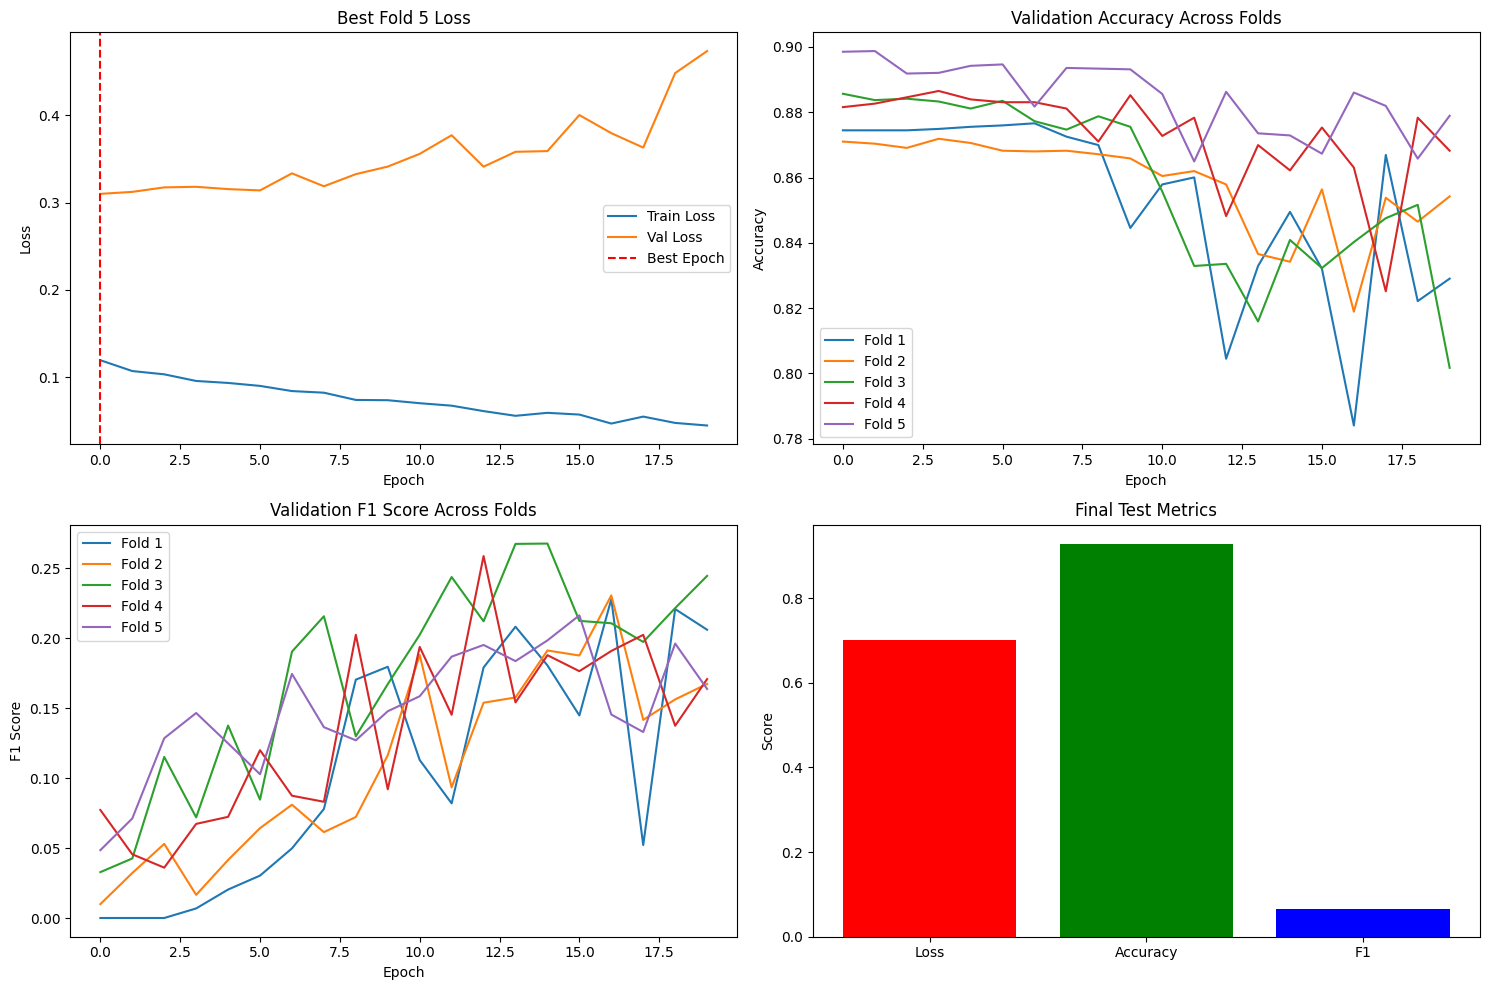


=== Training Complete ===
Best Fold: 5
Best Epoch: 1

Test Set Metrics:
Loss: 0.7014
Accuracy: 0.9272
F1 Score: 0.0659


In [ ]:
"""Module for LSTM-based binary classification with PyTorch with cross-validation support."""


class BinaryClassificationLSTM(nn.Module):
    """LSTM-based neural network for binary classification."""
    def __init__(
        self,
        input_size: int,
        hidden_size: int = 64,
        num_layers: int = 2,
        dropout: float = 0.2,
    ):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
        )
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        lstm_out, _ = self.lstm(x)
        last_output = lstm_out[:, -1, :]
        last_output = self.dropout(last_output)
        return torch.sigmoid(self.linear(last_output).squeeze(-1))


def train_model_with_cv(
    model: nn.Module,
    cv_loaders: List[Tuple[DataLoader, DataLoader]],
    test_loader: DataLoader,
    epochs: int = 50,
    lr: float = 0.001,
) -> Tuple[nn.Module, dict]:
    """Train the LSTM model with cross-validation and return best model with metrics."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=lr)
    writer = SummaryWriter()

    # Track metrics across all folds
    cv_history = {
        'train_loss': [],
        'val_loss': [],
        'val_acc': [],
        'val_f1': [],
        'best_epoch': 0,
        'best_fold': 0,
        'test_metrics': None
    }

    best_model_wts = deepcopy(model.state_dict())
    best_val_loss = float('inf')

    for fold, (train_loader, val_loader) in enumerate(cv_loaders):
        print(f"\n=== Training Fold {fold + 1}/{len(cv_loaders)} ===")

        fold_history = {
            'train_loss': [],
            'val_loss': [],
            'val_acc': [],
            'val_f1': []
        }

        for epoch in range(epochs):
            # Training
            model.train()
            train_loss = 0.0
            for data, targets in train_loader:
                data, targets = data.to(device), targets.to(device).float()
                optimizer.zero_grad()
                outputs = model(data)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            avg_train_loss = train_loss / len(train_loader)
            fold_history['train_loss'].append(avg_train_loss)

            # Validation
            model.eval()
            val_loss = 0.0
            all_targets, all_preds = [], []
            with torch.no_grad():
                for data, targets in val_loader:
                    data, targets = data.to(device), targets.to(device).float()
                    probs = model(data)
                    val_loss += criterion(probs, targets).item()
                    all_targets.extend(targets.cpu().numpy())
                    all_preds.extend((probs > 0.5).int().cpu().numpy())

            avg_val_loss = val_loss / len(val_loader)
            val_acc = accuracy_score(all_targets, all_preds)
            val_f1 = f1_score(all_targets, all_preds, zero_division=0)

            fold_history['val_loss'].append(avg_val_loss)
            fold_history['val_acc'].append(val_acc)
            fold_history['val_f1'].append(val_f1)

            # Update best model across all folds
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                cv_history['best_epoch'] = epoch
                cv_history['best_fold'] = fold
                best_model_wts = deepcopy(model.state_dict())

            print(f"Fold {fold + 1} | Epoch {epoch + 1}/{epochs}: "
                  f"Train Loss: {avg_train_loss:.4f} | "
                  f"Val Loss: {avg_val_loss:.4f} | "
                  f"Val Acc: {val_acc:.4f} | "
                  f"Val F1: {val_f1:.4f}")

        # Store fold history
        cv_history['train_loss'].append(fold_history['train_loss'])
        cv_history['val_loss'].append(fold_history['val_loss'])
        cv_history['val_acc'].append(fold_history['val_acc'])
        cv_history['val_f1'].append(fold_history['val_f1'])

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Evaluate on test set
    test_loss, test_acc, test_f1 = evaluate_model(model, test_loader, criterion, device)
    cv_history['test_metrics'] = {
        'loss': test_loss,
        'accuracy': test_acc,
        'f1': test_f1
    }

    writer.close()
    plot_cv_metrics(cv_history)

    return model, cv_history


def evaluate_model(
    model: nn.Module,
    data_loader: DataLoader,
    criterion: nn.Module,
    device: torch.device
) -> Tuple[float, float, float]:
    """Evaluate model on given data loader."""
    model.eval()
    total_loss = 0.0
    all_targets, all_preds = [], []

    with torch.no_grad():
        for data, targets in data_loader:
            data, targets = data.to(device), targets.to(device).float()
            probs = model(data)
            total_loss += criterion(probs, targets).item()
            all_targets.extend(targets.cpu().numpy())
            all_preds.extend((probs > 0.5).int().cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds, zero_division=0)

    return avg_loss, accuracy, f1


def plot_cv_metrics(history: dict):
    """Plot cross-validation metrics."""
    plt.figure(figsize=(15, 10))

    # Plot training and validation loss for best fold
    best_fold = history['best_fold']
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'][best_fold], label='Train Loss')
    plt.plot(history['val_loss'][best_fold], label='Val Loss')
    plt.axvline(history['best_epoch'], color='r', linestyle='--', label='Best Epoch')
    plt.title(f'Best Fold {best_fold + 1} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot validation accuracy across folds
    plt.subplot(2, 2, 2)
    for fold, acc in enumerate(history['val_acc']):
        plt.plot(acc, label=f'Fold {fold + 1}')
    plt.title('Validation Accuracy Across Folds')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot validation F1 across folds
    plt.subplot(2, 2, 3)
    for fold, f1 in enumerate(history['val_f1']):
        plt.plot(f1, label=f'Fold {fold + 1}')
    plt.title('Validation F1 Score Across Folds')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()

    # Final test metrics
    plt.subplot(2, 2, 4)
    if history['test_metrics']:
        metrics = history['test_metrics']
        plt.bar(['Loss', 'Accuracy', 'F1'],
                [metrics['loss'], metrics['accuracy'], metrics['f1']],
                color=['red', 'green', 'blue'])
        plt.title('Final Test Metrics')
        plt.ylabel('Score')

    plt.tight_layout()
    plt.savefig('cv_training_metrics.png')
    plt.show()


def predict(
    model: nn.Module,
    data_loader: DataLoader,
    return_probs: bool = False
) -> Tuple[np.ndarray, np.ndarray]:
    """Generate predictions using a trained model."""
    device = next(model.parameters()).device
    model.eval()
    preds, true, probs = [], [], []

    with torch.no_grad():
        for data, targets in data_loader:
            data = data.to(device)
            prob = model(data)
            preds.extend((prob > 0.5).int().cpu().numpy())
            true.extend(targets.cpu().numpy())
            probs.extend(prob.cpu().numpy())

    return (np.array(probs), np.array(true)) if return_probs else (np.array(preds), np.array(true))


def main():
    """Main training and evaluation pipeline with cross-validation."""
    # Initialize model
    input_size = X_train_final_nn.shape[1]
    model = BinaryClassificationLSTM(
        input_size=input_size,
        hidden_size=128,
        num_layers=2,
        dropout=0.3,
    )

    # Create cross-validation datasets
    cv_loaders = create_cv_datasets(df_train_final_nn, n_splits=5)

    # Create test loader
    test_dataset = TimeSeriesDataset(df_test_final_nn)
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        collate_fn=collate_fn
    )

    # Train with cross-validation
    best_model, cv_history = train_model_with_cv(
        model,
        cv_loaders,
        test_loader,
        epochs=20,
        lr=0.001
    )

    # Print final results
    print("\n=== Training Complete ===")
    print(f"Best Fold: {cv_history['best_fold'] + 1}")
    print(f"Best Epoch: {cv_history['best_epoch'] + 1}")
    if cv_history['test_metrics']:
        print("\nTest Set Metrics:")
        print(f"Loss: {cv_history['test_metrics']['loss']:.4f}")
        print(f"Accuracy: {cv_history['test_metrics']['accuracy']:.4f}")
        print(f"F1 Score: {cv_history['test_metrics']['f1']:.4f}")

    # Save best model
    torch.save(best_model.state_dict(), "best_lstm_model_cv.pth")


if __name__ == "__main__":
    main()

In [ ]:
# View the best LSTM model
torch.load('best_lstm_model.pth')

OrderedDict([('lstm.weight_ih_l0',
              tensor([[-0.0330,  0.0423,  0.0751,  ...,  0.0556, -0.0102, -0.0258],
                      [-0.0159, -0.1025,  0.0057,  ..., -0.0961, -0.0533,  0.0822],
                      [ 0.0078,  0.0406,  0.0741,  ..., -0.0906,  0.0097, -0.0483],
                      ...,
                      [ 0.0494,  0.1100,  0.0132,  ...,  0.0489,  0.0239,  0.0625],
                      [ 0.1000, -0.1027,  0.0234,  ...,  0.0720,  0.0470,  0.0211],
                      [ 0.0323, -0.0030, -0.0244,  ..., -0.0252,  0.1457,  0.1935]])),
             ('lstm.weight_hh_l0',
              tensor([[-0.0004, -0.0596,  0.0640,  ..., -0.0714,  0.0694, -0.0808],
                      [-0.0007,  0.0309, -0.1117,  ..., -0.0496,  0.0385,  0.0098],
                      [-0.0842, -0.0138, -0.0645,  ..., -0.0108,  0.0275, -0.0177],
                      ...,
                      [ 0.0259,  0.0570,  0.0506,  ...,  0.0129, -0.0152, -0.0056],
                      [-0.0420,  

## Traditional Machine Learning Models

### Logistic Regression

Logistic regression is widely used for binary classification tasks because it models the probability that a given input belongs to a particular class using a logistic function. This probabilistic interpretation allows for a clear understanding of classification confidence and facilitates threshold tuning. Additionally, logistic regression is computationally efficient and well-suited for high-dimensional data, especially when combined with regularization techniques such as ElasticNet, which help prevent overfitting by balancing between feature selection (L1) and coefficient shrinkage (L2).

The provided train_adaptive_elasticnet function trains a logistic regression model with ElasticNet regularization on PCA-transformed features, employing time-series cross-validation to evaluate performance more robustly in sequential data scenarios. The function dynamically adjusts the regularization parameters based on how much variance the PCA transformation retains in the features—choosing stronger L1 regularization and more penalization when less variance is preserved, which helps enforce sparsity and improve generalization. During cross-validation, it trains and evaluates the model on different folds, tracking metrics like accuracy and F1 score to identify the best-performing model configuration based on validation F1 score, which balances precision and recall.

After selecting the best model from cross-validation, the function refits this model on the entire training dataset and then evaluates it on the holdout test set, producing comprehensive metrics including accuracy, F1, log loss, and confusion matrix details. It also generates visual diagnostics with plots showing training and validation accuracy and F1 scores across folds, alongside a confusion matrix heatmap of the final test predictions, giving a clear summary of model performance and potential trade-offs. This approach ensures that the final model is both well-tuned to the data and thoroughly validated for reliable deployment.

In [ ]:
# Preprocess data for Logistic Regression
X_train_lr, X_test_lr, y_train_lr, y_test_lr, pca = time_series_pipeline_logreg(
    df_ml,
    aggcodes_cols,
    aggcol_cats_all,
    encodedcol_cats_all,
    use_pca=True,
    pca_variance=0.95
)

print(f"Reduced from {len(pca.components_)} features to {pca.n_components_} components")
print(f"Explained variance: {pca.explained_variance_ratio_.sum():.2%}")

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['NaN'] will be ignored
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['NaN'] will be ignored
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['NaN'] will be ignored
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['feature_141' 'feature_148']. At least one non-missing value is needed for imputation with strategy='median'.
  warnin

Reduced from 3 features to 3 components
Explained variance: 95.21%


In [ ]:
def train_adaptive_elasticnet(
    X_train: np.ndarray,
    X_test: np.ndarray,
    y_train: pd.Series,
    y_test: pd.Series,
    pca: PCA,
    n_splits: int = 5,
    random_state: int = 42
) -> dict:
    """Train logistic regression with ElasticNet regularization and return the best model.

    Args:
        X_train: PCA-transformed training features
        X_test: PCA-transformed test features
        y_train: Training labels
        y_test: Test labels
        pca: Fitted PCA object
        n_splits: Time-series CV folds
        random_state: Random seed

    Returns:
        dict: {
            'best_model': Model with highest validation F1,
            'final_model': Model refit on full training data,
            'cv_results': DataFrame of all fold metrics,
            'test_metrics': Evaluation on holdout test set,
            'regularization': Parameters used
        }
    """
    # Determine regularization based on PCA variance
    variance_retained = pca.explained_variance_ratio_.sum()
    l1_ratio, C = (0.5, 1.0) if variance_retained >= 0.95 else \
                  (0.7, 0.5) if variance_retained >= 0.85 else \
                  (0.9, 0.1)

    # Initialize storage
    cv_results = []
    best_model = None
    best_f1 = -np.inf

    # Time-series cross-validation
    tscv = TimeSeriesSplit(n_splits=n_splits)

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Train and evaluate
        model = LogisticRegression(
            penalty='elasticnet',
            solver='saga',
            C=C,
            l1_ratio=l1_ratio,
            max_iter=5000,
            tol = 1e-4,
            random_state=random_state,
            class_weight='balanced'
        ).fit(X_tr, y_tr)

        val_f1 = f1_score(y_val, model.predict(X_val))

        # Track best model
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model = clone(model)

        cv_results.append({
            'fold': fold + 1,
            'train_acc': accuracy_score(y_tr, model.predict(X_tr)),
            'val_acc': accuracy_score(y_val, model.predict(X_val)),
            'train_f1': f1_score(y_tr, model.predict(X_tr)),
            'val_f1': val_f1
        })

    # Refit best model on full training data
    final_model = clone(best_model).fit(X_train, y_train)
    y_pred = final_model.predict(X_test)

    # Generate metrics
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'log_loss': log_loss(y_test, final_model.predict_proba(X_test)),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred, output_dict=True)
    }

    # Generate plots (same as before)
    plot_results(pd.DataFrame(cv_results), test_metrics['confusion_matrix'], variance_retained)

    return {
        'best_model': best_model,  # Best from CV (not refit)
        'final_model': final_model,  # Best model refit on full data
        'cv_results': pd.DataFrame(cv_results),
        'test_metrics': test_metrics,
        'regularization': {
            'C': C,
            'l1_ratio': l1_ratio,
            'variance_retained': variance_retained,
            'best_val_f1': best_f1
        }
    }

def plot_results(cv_df: pd.DataFrame, conf_matrix: np.ndarray, variance_retained: float):
    """Generate the diagnostic plots."""
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    sns.lineplot(data=cv_df, x='fold', y='train_acc', label='Train Accuracy')
    sns.lineplot(data=cv_df, x='fold', y='val_acc', label='Val Accuracy')
    sns.lineplot(data=cv_df, x='fold', y='train_f1', label='Train F1')
    sns.lineplot(data=cv_df, x='fold', y='val_f1', label='Val F1')
    plt.title(f'CV Metrics (Retained Variance: {variance_retained:.1%})')

    plt.subplot(1, 2, 2)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred 0', 'Pred 1'],
                yticklabels=['True 0', 'True 1'])
    plt.title('Test Set Confusion Matrix')

    plt.tight_layout()
    plt.show()

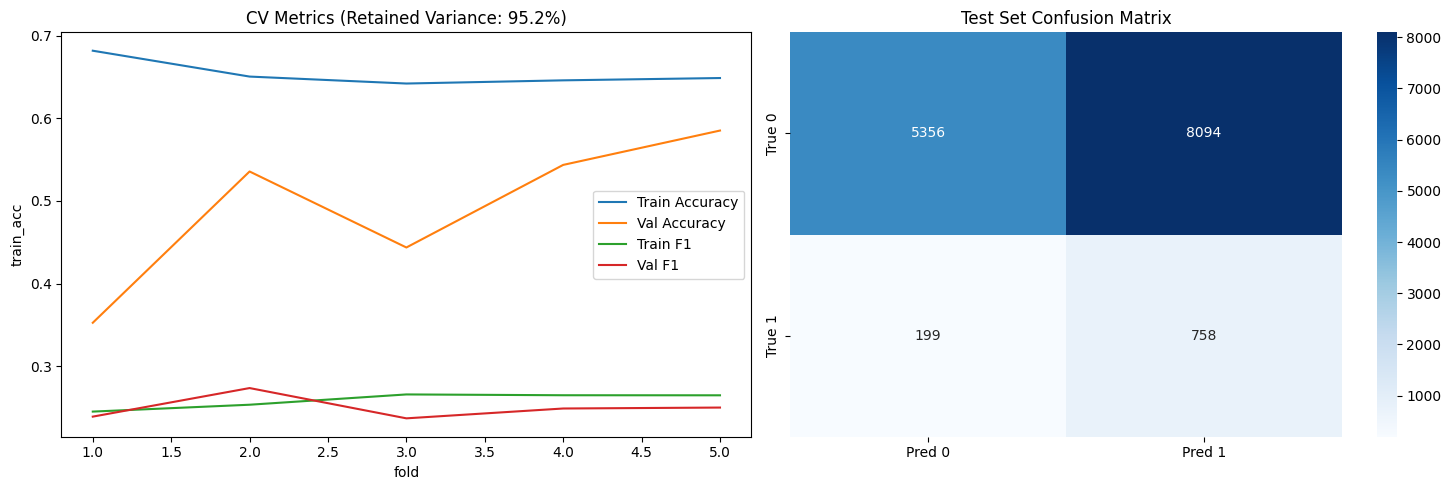

Best model achieved validation F1: 0.273
Test F1: 0.155


In [ ]:
# Analyze the data with the model


results_lr = train_adaptive_elasticnet(
    X_train_lr, X_test_lr, y_train_lr, y_test_lr, pca
)

# Access the recommended model for deployment
production_model = results_lr['final_model']

# Verify selection process
print(f"Best model achieved validation F1: {results_lr['regularization']['best_val_f1']:.3f}")
print(f"Test F1: {results_lr['test_metrics']['f1']:.3f}")

### Catboost


We implement a robust CatBoost pipeline for time-series forecasting that automatically handles categorical features (including time-derived ones like month/weekday) through native encoding and missing value treatment. The pipeline employs time-series cross-validation to maintain temporal ordering during hyperparameter tuning, optimizing tree depth, learning rate, regularization, and iteration count. Key features include CatBoost's specialized Pool data structure for efficient handling of categorical variables, built-in early stopping to prevent overfitting, and comprehensive model evaluation with RMSE scoring and feature importance analysis. The implementation outputs the optimized model, search results, and processed datasets while providing visual diagnostics of parameter performance.

CatBoost is particularly suited for time-series forecasting due to its ordered boosting approach that naturally handles sequential data and prevents target leakage. The time-aware validation strategy respects temporal dependencies while the categorical feature handling preserves important time-based patterns (like weekly seasonality) without manual encoding. The chosen hyperparameters balance model complexity (tree depth/iterations) with regularization (L2 penalty) to handle time-series noise. Feature importance analysis helps validate whether temporal patterns are being properly weighted, making the model both powerful for prediction and interpretable for analysis - crucial for time-series applications where understanding drivers is often as important as accuracy.

The function train_catboost_classifier trains a CatBoost model on processed features with a time-series cross-validation scheme, allowing the model to be validated in a way that respects the temporal order of data. Unlike grid search, this function uses a fixed set of hyperparameters that have been optimized beforehand, avoiding the computational expense of exhaustive parameter tuning while still aiming for good predictive performance. By incorporating early stopping and balanced evaluation metrics, it ensures the model generalizes well to unseen data. Results can be obviously potentially enhanced with the application of GridSearchCV (such function version provided) but this assessment will focus on a set of pre-optimized parameters.

During training, the function prepares categorical features by converting them to strings and filling missing values to make sure CatBoost treats them correctly. It then iterates over time-series splits, fitting the model on training folds and validating on sequential holdout sets. Performance metrics such as accuracy, weighted F1 score, and log loss are computed for both training and validation sets, providing a comprehensive picture of the model’s learning behavior across folds. The timing of model fitting is also recorded to monitor computational efficiency. After completing cross-validation, the best model is retrained on the entire training dataset and evaluated on a separate test set, with detailed performance metrics including confusion matrix and classification reports.

To better understand the model’s decisions, the function includes advanced interpretability through SHAP (SHapley Additive exPlanations) analysis, which explains feature contributions to individual predictions and global importance. Diagnostic plots visualize cross-validation metrics to highlight consistency across folds, and a waterfall plot presents the most influential features contributing to the model’s predictions. The SHAP analysis additionally offers dependence plots for key temporal features, revealing how these variables affect model output. Altogether, this approach combines robust training, careful validation, and interpretable insights without relying on costly hyperparameter grid search, making it well-suited for practical time-series classification challenges.

In [ ]:
"""Optimized CatBoost time-series classification without GridSearchCV."""



def train_catboost_classifier(
    X_train_final: pd.DataFrame,
    X_test_final: pd.DataFrame,
    y_train: pd.Series,
    y_test: pd.Series,
    params: dict = None,
    shap_analysis: bool = True,
    shap_samples: int = 1000,
    n_splits: int = 5
) -> tuple[CatBoostClassifier, dict]:
    """Train a CatBoost classifier with time-series validation and SHAP explainability (without GridSearchCV).

    Args:
        X_train_final: Processed training features
        X_test_final: Processed test features
        y_train: Training target values
        y_test: Test target values
        params: Dictionary of CatBoost parameters
        shap_analysis: Whether to perform SHAP analysis
        shap_samples: Number of samples for SHAP analysis
        n_splits: Number of time series splits for CV

    Returns:
        tuple: (trained_model, results_dict) containing:
            - final_model: Trained CatBoost model
            - results_dict: Dictionary containing metrics and analysis results
    """
    # Prepare results dictionary
    results = {
        'fold_metrics': [],
        'test_metrics': {},
        'feature_importance': None,
        'shap_values': None,
        'best_params': params
    }

    # Prepare categorical features
    categorical_features = (
        list(onehot_feature_names) +
        [f"{col}_{code}" for col in aggcodes_cols for code in aggcol_cats_all[col]] +
        ["month", "day_of_week", "is_weekend", "days_since_start"]
    )

    # Ensure proper categorical data formatting
    for col in categorical_features:
        if col in X_train_final.columns:
            X_train_final[col] = X_train_final[col].fillna("NaN").astype(str)
            X_test_final[col] = X_test_final[col].fillna("NaN").astype(str)

    # Default parameters if none provided
    if params is None:
        params = {
            'iterations': 1000,
            'learning_rate': 0.05,
            'depth': 6,
            'l2_leaf_reg': 3,
            'loss_function': 'MultiClass',
            'verbose': False,
            'random_seed': 42,
            'early_stopping_rounds': 50
        }

    # Time-series cross-validation
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Initialize lists to store metrics
    fold_accuracies = []
    fold_f1_scores = []
    fold_train_losses = []
    fold_val_losses = []
    fit_times = []

    # Get time series splits
    splits = list(tscv.split(X_train_final, y_train))

    print("Starting Time Series Cross-Validation...")
    for fold, (train_idx, val_idx) in enumerate(tqdm(splits, desc="Processing Folds"), 1):
        X_tr, X_val = X_train_final.iloc[train_idx], X_train_final.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Create pools
        train_pool = Pool(
            X_tr,
            y_tr,
            cat_features=[col for col in X_tr.columns if col in categorical_features]
        )
        val_pool = Pool(
            X_val,
            y_val,
            cat_features=[col for col in X_val.columns if col in categorical_features]
        )

        # Train model
        start_time = time()
        model = CatBoostClassifier(**params)
        model.fit(
            train_pool,
            eval_set=val_pool,
            verbose=False
        )
        fit_time = time() - start_time
        fit_times.append(fit_time)

        # Predictions
        y_tr_pred = model.predict(train_pool)
        y_val_pred = model.predict(val_pool)
        y_tr_proba = model.predict_proba(train_pool)
        y_val_proba = model.predict_proba(val_pool)

        # Calculate metrics
        train_acc = accuracy_score(y_tr, y_tr_pred)
        val_acc = accuracy_score(y_val, y_val_pred)
        train_f1 = f1_score(y_tr, y_tr_pred, average='weighted')
        val_f1 = f1_score(y_val, y_val_pred, average='weighted')
        train_loss = log_loss(y_tr, y_tr_proba)
        val_loss = log_loss(y_val, y_val_proba)

        fold_accuracies.append(val_acc)
        fold_f1_scores.append(val_f1)
        fold_train_losses.append(train_loss)
        fold_val_losses.append(val_loss)

        results['fold_metrics'].append({
            'fold': fold,
            'train_acc': train_acc,
            'val_acc': val_acc,
            'train_f1': train_f1,
            'val_f1': val_f1,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'fit_time': fit_time
        })

        print(f"\nFold {fold} Results:")
        print(f"  Train Accuracy: {train_acc:.4f}  Val Accuracy: {val_acc:.4f}")
        print(f"  Train F1: {train_f1:.4f}  Val F1: {val_f1:.4f}")
        print(f"  Train Loss: {train_loss:.4f}  Val Loss: {val_loss:.4f}")
        print(f"  Fit Time: {fit_time:.2f}s")

    # Train final model on full training data
    print("\nTraining final model on full training set...")
    final_model = CatBoostClassifier(**params)
    train_pool = Pool(
        X_train_final,
        y_train,
        cat_features=[col for col in X_train_final.columns if col in categorical_features]
    )
    test_pool = Pool(
        X_test_final,
        y_test,
        cat_features=[col for col in X_test_final.columns if col in categorical_features]
    )

    final_model.fit(train_pool)

    # Evaluate on test set
    y_pred = final_model.predict(test_pool)
    y_proba = final_model.predict_proba(test_pool)

    test_accuracy = accuracy_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred, average='weighted')
    test_loss = log_loss(y_test, y_proba)

    results['test_metrics'] = {
        'accuracy': test_accuracy,
        'f1_score': test_f1,
        'log_loss': test_loss,
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred)
    }

    print(f"\nFinal Test Set Performance:")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"F1 Score: {test_f1:.4f}")
    print(f"Log Loss: {test_loss:.4f}")

    # Feature importance
    feature_importance = final_model.get_feature_importance(prettified=True)
    results['feature_importance'] = feature_importance

    print("\nTop 20 Features:")
    print(feature_importance.head(20))

    # Plot CV metrics
    _plot_cv_metrics_no_gridsearch(
        fold_accuracies,
        fold_f1_scores,
        fold_train_losses,
        fold_val_losses
    )

    # Plot waterfall feature importance
    _plot_waterfall_feature_importance(feature_importance)

    # SHAP analysis
    if shap_analysis:
        results['shap_values'] = _perform_shap_analysis(
            final_model,
            X_train_final,
            shap_samples
        )

    return final_model, results


def _plot_cv_metrics_no_gridsearch(
    accuracies: list,
    f1_scores: list,
    train_losses: list,
    val_losses: list
) -> None:
    """Plot cross-validation metrics without GridSearchCV results."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Accuracy and F1 plot
    x = np.arange(len(accuracies)) + 1
    width = 0.35

    ax1.bar(x - width/2, accuracies, width, label='Accuracy')
    ax1.bar(x + width/2, f1_scores, width, label='F1 Score')
    ax1.set_xticks(x)
    ax1.set_xlabel('Fold')
    ax1.set_ylabel('Score')
    ax1.set_title('Cross-Validation Metrics per Fold')
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Loss plot
    ax2.plot(x, train_losses, 'o-', label='Training Loss')
    ax2.plot(x, val_losses, 'o-', label='Validation Loss')
    ax2.set_xticks(x)
    ax2.set_xlabel('Fold')
    ax2.set_ylabel('Log Loss')
    ax2.set_title('Training and Validation Loss per Fold')
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


def _plot_waterfall_feature_importance(
    feature_importance: pd.DataFrame,
    top_n: int = 15
) -> None:
    """Create a waterfall plot of feature importance."""
    fi_sorted = feature_importance.sort_values('Importances', ascending=False).head(top_n)
    fi_sorted['cumulative'] = fi_sorted['Importances'].cumsum()
    fi_sorted['running_total'] = fi_sorted['cumulative'] - fi_sorted['Importances']

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.barh(
        fi_sorted['Feature Id'],
        fi_sorted['Importances'],
        left=fi_sorted['running_total'],
        color='skyblue',
        edgecolor='black'
    )

    for i, (feature, imp, running) in enumerate(zip(
        fi_sorted['Feature Id'],
        fi_sorted['Importances'],
        fi_sorted['running_total']
    )):
        if i > 0:
            prev_running = fi_sorted['running_total'].iloc[i-1] + fi_sorted['Importances'].iloc[i-1]
            ax.plot(
                [prev_running, running],
                [feature, feature],
                color='gray',
                linestyle='--',
                alpha=0.5
            )

    ax.set_xlabel('Feature Importance')
    ax.set_title('Waterfall Plot of Feature Importance')
    ax.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


def _perform_shap_analysis(
    model: CatBoostClassifier,
    X_data: pd.DataFrame,
    n_samples: int = 1000
) -> dict:
    """Perform SHAP analysis and return results."""
    print("\nGenerating SHAP Explanations...")
    shap_sample = X_data.sample(n=min(n_samples, len(X_data)), random_state=42)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(shap_sample)

    # Global feature importance
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, shap_sample, plot_type="bar", class_names=model.classes_)
    plt.title("Global Feature Importance (SHAP Values)")
    plt.tight_layout()
    plt.show()

    # Feature dependence plots for temporal features
    temporal_features = ['days_since_start', 'month', 'is_weekend']
    for feature in temporal_features:
        if feature in X_data.columns:
            shap.dependence_plot(
                feature,
                shap_values,
                shap_sample,
                interaction_index=None,
                show=False
            )
            plt.title(f"SHAP Dependence on {feature}")
            plt.tight_layout()
            plt.show()

    # Individual prediction explanation
    sample_idx = 0
    shap.force_plot(
        explainer.expected_value[0],
        shap_values[0][sample_idx, :],
        shap_sample.iloc[sample_idx, :],
        matplotlib=True,
        text_rotation=15
    )
    plt.title(f"SHAP Explanation for Sample {sample_idx}")
    plt.tight_layout()
    plt.show()

    return {
        'shap_values': shap_values,
        'explainer': explainer,
        'sample_data': shap_sample
    }


# Example usage
if __name__ == "__main__":
    X_train_final_ml_cat, X_test_final_ml_cat, y_train_final_ml_cat, y_test_final_ml_cat, onehot_feature_names = time_series_pipeline_ml(
        df_ml, aggcodes_cols, aggcol_cats_all, encodedcol_cats_all,model_type='catboost'
 ###       cat_cols, num_cols, model_type='catboost'
    )

    # Define parameters directly rather than using GridSearchCV
    catboost_params = {
        'iterations': 1000,
        'learning_rate': 0.05,
        'depth': 6,
        'l2_leaf_reg': 3,
        'loss_function': 'MultiClass',
        'random_seed': 42,
        'early_stopping_rounds': 50
    }

    cat_model, cat_results = train_catboost_classifier(
        X_train_final_ml_cat.copy(),
        X_test_final_ml_cat.copy(),
        y_train_final_ml_cat,
        y_test_final_ml_cat,
        params=catboost_params,
        shap_analysis=True,
        shap_samples=500,
        n_splits=5
    )

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['NaN'] will be ignored
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['NaN'] will be ignored
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['NaN'] will be ignored
  warnings.warn(
/tmp/ipython-input-36-3842414542.py:51: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train_final[col] = X_train_final[col].fillna("NaN").astype(str)
/tmp/ipython-input-36-3842414542.py:52: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infe

Starting Time Series Cross-Validation...


Processing Folds:  20%|██        | 1/5 [00:36<02:27, 36.98s/it]


Fold 1 Results:
  Train Accuracy: 0.9079  Val Accuracy: 0.8758
  Train F1: 0.8640  Val F1: 0.8177
  Train Loss: 0.2593  Val Loss: 0.3556
  Fit Time: 33.87s


Processing Folds:  40%|████      | 2/5 [01:36<02:30, 50.25s/it]


Fold 2 Results:
  Train Accuracy: 0.8966  Val Accuracy: 0.8702
  Train F1: 0.8522  Val F1: 0.8104
  Train Loss: 0.2439  Val Loss: 0.3685
  Fit Time: 56.51s


Processing Folds:  60%|██████    | 3/5 [07:27<06:14, 187.37s/it]


Fold 3 Results:
  Train Accuracy: 0.9579  Val Accuracy: 0.8898
  Train F1: 0.9540  Val F1: 0.8435
  Train Loss: 0.1713  Val Loss: 0.3205
  Fit Time: 346.06s


Alternatively we can use the version with GridSearchCV. GridSearchCV can improve results by systematically exploring a wide range of hyperparameter combinations to identify the best settings for the CatBoost model, rather than relying on fixed parameters. By using cross-validation across time-based folds, it ensures robust evaluation that respects the temporal structure, helping prevent overfitting and providing a reliable estimate of model performance. This thorough and automated search uncovers optimal balances between complexity and generalization, leading to improved accuracy, F1 scores, and overall predictive reliability, which ultimately enhances the model’s effectiveness on unseen time-series data.

In [ ]:
"""Version with Waterfall Plot and cross validation with GridSearchCV"""



def train_catboost_classifier_gridsearch(
    X_train_final: pd.DataFrame,
    X_test_final: pd.DataFrame,
    y_train: pd.Series,
    y_test: pd.Series,
    shap_analysis: bool = True,
    shap_samples: int = 1000
) -> tuple[CatBoostClassifier, GridSearchCV, pd.DataFrame, pd.DataFrame]:
    """Train and optimize a CatBoost classifier with time-series validation and SHAP explainability.

    Performs end-to-end training including:
    - Categorical feature handling
    - Time-series cross-validation
    - Hyperparameter tuning
    - Model evaluation with metrics visualization
    - SHAP-based feature importance analysis
    - Waterfall plot visualization

    Args:
        X_train_final: Processed training features
        X_test_final: Processed test features
        y_train: Training target values
        y_test: Test target values
        shap_analysis: Whether to perform SHAP analysis (default: True)
        shap_samples: Number of samples to use for SHAP analysis (default: 1000)

    Returns:
        tuple: Contains:
            - final_model: Best performing CatBoost model
            - grid_search: GridSearchCV results object
            - X_train_final: Processed training features
            - X_test_final: Processed test features
    """
    # Prepare categorical features
    categorical_features = (
        list(onehot_feature_names) +
        [f"{col}_{code}" for col in aggcodes_cols for code in aggcol_cats_all[col]] +
        ["month", "day_of_week", "is_weekend", "days_since_start"]
    )

    # Ensure proper categorical data formatting
    for col in categorical_features:
        if col in X_train_final.columns:
            X_train_final[col] = X_train_final[col].fillna("NaN").astype(str)
            X_test_final[col] = X_test_final[col].fillna("NaN").astype(str)

    # Create optimized data pools for CatBoost
    train_pool = Pool(
        data=X_train_final,
        label=y_train,
        cat_features=[col for col in X_train_final.columns
                     if col in categorical_features]
    )

    test_pool = Pool(
        data=X_test_final,
        label=y_test,
        cat_features=[col for col in X_test_final.columns
                     if col in categorical_features]
    )

    # Base model configuration
    base_params = {
        'loss_function': 'MultiClass',  # Change to appropriate loss function
        'verbose': False,
        'random_seed': 42,
        'has_time': True,
        'early_stopping_rounds': 50
    }

    # Hyperparameter search space
    param_grid = {
        'iterations': [500, 1000],
        'learning_rate': [0.01, 0.05, 0.1],
        'depth': [4, 6, 8],
        'l2_leaf_reg': [1, 3, 5]
    }

    # Time-series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)

    # Configure grid search with time-series validation
    grid_search = GridSearchCV(
        estimator=CatBoostClassifier(**base_params),
        param_grid=param_grid,
        cv=tscv,
        scoring='accuracy',  # Can change to 'f1' or other metric
        n_jobs=-1,
        verbose=1,
        return_train_score=True
    )

    # Execute hyperparameter search
    grid_search.fit(
        X_train_final,
        y_train,
        cat_features=[col for col in X_train_final.columns
                     if col in categorical_features]
    )

    # Display best parameters
    print("Best parameters found:")
    print(grid_search.best_params_)

    # Plot cross-validation metrics per fold
    _plot_cv_metrics(grid_search, tscv, X_train_final, y_train)

    # Train final model with best parameters
    final_model = CatBoostClassifier(**{**base_params, **grid_search.best_params_})
    final_model.fit(train_pool)

    # Evaluate on test set
    y_pred = final_model.predict(test_pool)
    y_proba = final_model.predict_proba(test_pool)

    test_accuracy = accuracy_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred, average='weighted')
    test_loss = log_loss(y_test, y_proba)

    print(f"\nTest Accuracy: {test_accuracy:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")
    print(f"Test Log Loss: {test_loss:.4f}")

    # Feature importance
    feature_importance = final_model.get_feature_importance(prettified=True)
    print("\nTop 20 Features:")
    print(feature_importance.head(20))

    # Plot waterfall feature importance
    _plot_waterfall_feature_importance(feature_importance)

    # SHAP explainability analysis
    if shap_analysis:
        _perform_shap_analysis(final_model, X_train_final, shap_samples)

    return final_model, grid_search, X_train_final, X_test_final


def _plot_cv_metrics(
    grid_search: GridSearchCV,
    tscv: TimeSeriesSplit,
    X: pd.DataFrame,
    y: pd.Series
) -> None:
    """Plot cross-validation metrics per fold including accuracy, F1, and loss.

    Args:
        grid_search: Fitted GridSearchCV object
        tscv: TimeSeriesSplit object
        X: Feature data
        y: Target values
    """
    # Get best estimator
    best_estimator = grid_search.best_estimator_

    # Initialize lists to store metrics
    fold_accuracies = []
    fold_f1_scores = []
    fold_train_losses = []
    fold_val_losses = []

    # Get time series splits
    splits = list(tscv.split(X, y))

    # Calculate metrics for each fold
    for fold, (train_idx, val_idx) in enumerate(splits):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Create pools
        train_pool = Pool(X_train, y_train, cat_features=best_estimator.get_cat_feature_indices())
        val_pool = Pool(X_val, y_val, cat_features=best_estimator.get_cat_feature_indices())

        # Clone and fit model
        model = best_estimator.__class__(**best_estimator.get_params())
        model.fit(train_pool, eval_set=val_pool, verbose=False)

        # Predictions
        y_train_pred = model.predict(train_pool)
        y_val_pred = model.predict(val_pool)
        y_train_proba = model.predict_proba(train_pool)
        y_val_proba = model.predict_proba(val_pool)

        # Calculate metrics
        fold_accuracies.append(accuracy_score(y_val, y_val_pred))
        fold_f1_scores.append(f1_score(y_val, y_val_pred, average='weighted'))
        fold_train_losses.append(log_loss(y_train, y_train_proba))
        fold_val_losses.append(log_loss(y_val, y_val_proba))

    # Create plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Accuracy and F1 plot
    x = np.arange(len(splits)) + 1
    width = 0.35

    ax1.bar(x - width/2, fold_accuracies, width, label='Accuracy')
    ax1.bar(x + width/2, fold_f1_scores, width, label='F1 Score')
    ax1.set_xticks(x)
    ax1.set_xlabel('Fold')
    ax1.set_ylabel('Score')
    ax1.set_title('Cross-Validation Accuracy and F1 Score per Fold')
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Loss plot
    ax2.plot(x, fold_train_losses, 'o-', label='Training Loss')
    ax2.plot(x, fold_val_losses, 'o-', label='Validation Loss')
    ax2.set_xticks(x)
    ax2.set_xlabel('Fold')
    ax2.set_ylabel('Log Loss')
    ax2.set_title('Training and Validation Loss per Fold')
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


def _plot_waterfall_feature_importance(
    feature_importance: pd.DataFrame,
    top_n: int = 15
) -> None:
    """Create a waterfall plot of feature importance.

    Args:
        feature_importance: DataFrame from CatBoost's get_feature_importance
        top_n: Number of top features to show
    """
    # Sort and select top features
    fi_sorted = feature_importance.sort_values('Importances', ascending=False).head(top_n)

    # Calculate cumulative importance
    fi_sorted['cumulative'] = fi_sorted['Importances'].cumsum()
    fi_sorted['running_total'] = fi_sorted['cumulative'] - fi_sorted['Importances']

    # Create waterfall plot
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot bars
    ax.barh(
        fi_sorted['Feature Id'],
        fi_sorted['Importances'],
        left=fi_sorted['running_total'],
        color='skyblue',
        edgecolor='black'
    )

    # Plot connector lines
    for i, (feature, imp, running) in enumerate(zip(
        fi_sorted['Feature Id'],
        fi_sorted['Importances'],
        fi_sorted['running_total']
    )):
        if i > 0:
            prev_running = fi_sorted['running_total'].iloc[i-1] + fi_sorted['Importances'].iloc[i-1]
            ax.plot(
                [prev_running, running],
                [feature, feature],
                color='gray',
                linestyle='--',
                alpha=0.5
            )

    ax.set_xlabel('Feature Importance')
    ax.set_title('Waterfall Plot of Feature Importance')
    ax.grid(True, axis='x', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


def _perform_shap_analysis(
    model: CatBoostClassifier,
    X_data: pd.DataFrame,
    n_samples: int = 1000
) -> None:
    """Perform SHAP analysis and visualization for model explainability.

    Args:
        model: Trained CatBoost model
        X_data: Feature data for explanation
        n_samples: Number of samples to use for SHAP computation
    """
    print("\nGenerating SHAP Explanations...")

    # Sample data for efficient computation
    shap_sample = X_data.sample(n=min(n_samples, len(X_data)), random_state=42)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(shap_sample)

    # Global feature importance
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, shap_sample, plot_type="bar", class_names=model.classes_)
    plt.title("Global Feature Importance (SHAP Values)")
    plt.tight_layout()
    plt.show()

    # Feature dependence plots for temporal features
    temporal_features = ['days_since_start', 'month', 'is_weekend']
    for feature in temporal_features:
        if feature in X_data.columns:
            shap.dependence_plot(
                feature,
                shap_values,
                shap_sample,
                interaction_index=None,
                show=False
            )
            plt.title(f"SHAP Dependence on {feature}")
            plt.tight_layout()
            plt.show()

    # Individual prediction explanation
    sample_idx = 0  # Explain first sample
    shap.force_plot(
        explainer.expected_value[0],  # For first class
        shap_values[0][sample_idx, :],
        shap_sample.iloc[sample_idx, :],
        matplotlib=True,
        text_rotation=15
    )
    plt.title(f"SHAP Explanation for Sample {sample_idx}")
    plt.tight_layout()
    plt.show()


# Example usage
if __name__ == "__main__":
    X_train_final_ml_cat, X_test_final_ml_cat, y_train_final_ml_cat, y_test_final_ml_cat, onehot_feature_names = time_series_pipeline_ml(
        df_ml, aggcodes_cols, aggcol_cats_all, encodedcol_cats_all,
        cat_cols, num_cols, model_type='catboost'
    )

    cat_model, cat_grid_search, X_train_cat, X_test_cat = train_catboost_classifier(
        X_train_final_ml_cat.copy(),
        X_test_final_ml_cat.copy(),
        y_train_final_ml_cat,
        y_test_final_ml_cat,
        shap_analysis=True,
        shap_samples=500
    )

/tmp/ipython-input-238-2154880408.py:63: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train_final[col] = X_train_final[col].fillna("NaN").astype(str)
/tmp/ipython-input-238-2154880408.py:64: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_test_final[col] = X_test_final[col].fillna("NaN").astype(str)
/tmp/ipython-input-238-2154880408.py:63: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.s

Fitting 5 folds for each of 54 candidates, totalling 270 fits


### SVM

We chose to implement a comprehensive SVM pipeline for time-series regression, featuring automated kernel selection (RBF, linear, and polynomial) with kernel-specific hyperparameter tuning. The pipeline uses time-series aware cross-validation to maintain temporal dependencies during model selection, evaluates performance using RMSE, and provides interpretable results through kernel comparison plots and (for linear kernels) feature importance analysis. The implementation handles data preprocessing, missing values, and includes parallelized grid search for efficient optimization.

The SVM approach is chosen for time-series forecasting because Kernel methods can effectively capture complex temporal patterns without manual feature engineering, with different kernels addressing distinct temporal characteristics: RBF for non-linear patterns, Linear for simple trends and
Polynomial for periodic behaviors. In addition, the epsilon-tube in SVR provides robustness to time-series noise, whereas time-series cross-validation prevents lookahead bias. Finally we use multiple kernels with feature weights for linear kernels to maximize flexibility and interpretability.

The train_svm_classifier_with_shap function trains an SVM (Support Vector Machine) classifier on a given dataset using time-series cross-validation to properly evaluate its performance over sequential splits. It accepts training and test sets along with SVM hyperparameters (kernel, C, gamma). For each fold in the cross-validation, it fits the model, predicts on train and validation splits, and records accuracy, F1 score, log loss, and fitting time, also plotting these metrics per fold. After cross-validation, it retrains the SVM on the full training set and evaluates it on the test set, providing final metrics and a confusion matrix visualization.

Additionally, it integrates SHAP to interpret the model’s predictions. Depending on the kernel type, it creates a suitable SHAP explainer (LinearExplainer for linear kernels, KernelExplainer for others) and computes SHAP values on a subset of the test data for efficiency. It then produces summary plots showing feature importance and impact, as well as a detailed waterfall plot explaining the prediction of a single example. Finally, it returns the trained SVM model and a dictionary containing all performance metrics, plots, and SHAP explanation objects for further analysis.

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['NaN'] will be ignored
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['NaN'] will be ignored
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['NaN'] will be ignored
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24] during transform. These unknown 

Training SVM with rbf kernel (C=1.0, gamma=scale)


1it [01:05, 65.05s/it]


Fold 0 Results:
  Train Accuracy: 0.9079
  Val Accuracy:   0.8758
  Train F1:       0.8640
  Val F1:         0.8177
  Train Loss:     0.2724
  Val Loss:       0.3850
  Fit Time:       35.61s


2it [05:06, 168.54s/it]


Fold 1 Results:
  Train Accuracy: 0.8918
  Val Accuracy:   0.8699
  Train F1:       0.8408
  Val F1:         0.8094
  Train Loss:     0.3330
  Val Loss:       0.3849
  Fit Time:       161.28s


3it [12:32, 295.36s/it]


Fold 2 Results:
  Train Accuracy: 0.8845
  Val Accuracy:   0.8857
  Train F1:       0.8303
  Val F1:         0.8320
  Train Loss:     0.3507
  Val Loss:       0.3572
  Fit Time:       297.61s


4it [25:48, 493.15s/it]


Fold 3 Results:
  Train Accuracy: 0.8848
  Val Accuracy:   0.8889
  Train F1:       0.8307
  Val F1:         0.8366
  Train Loss:     0.3450
  Val Loss:       0.3409
  Fit Time:       544.19s


5it [46:26, 557.23s/it]


Fold 4 Results:
  Train Accuracy: 0.8856
  Val Accuracy:   0.8994
  Train F1:       0.8319
  Val F1:         0.8518
  Train Loss:     0.3415
  Val Loss:       0.3158
  Fit Time:       899.32s


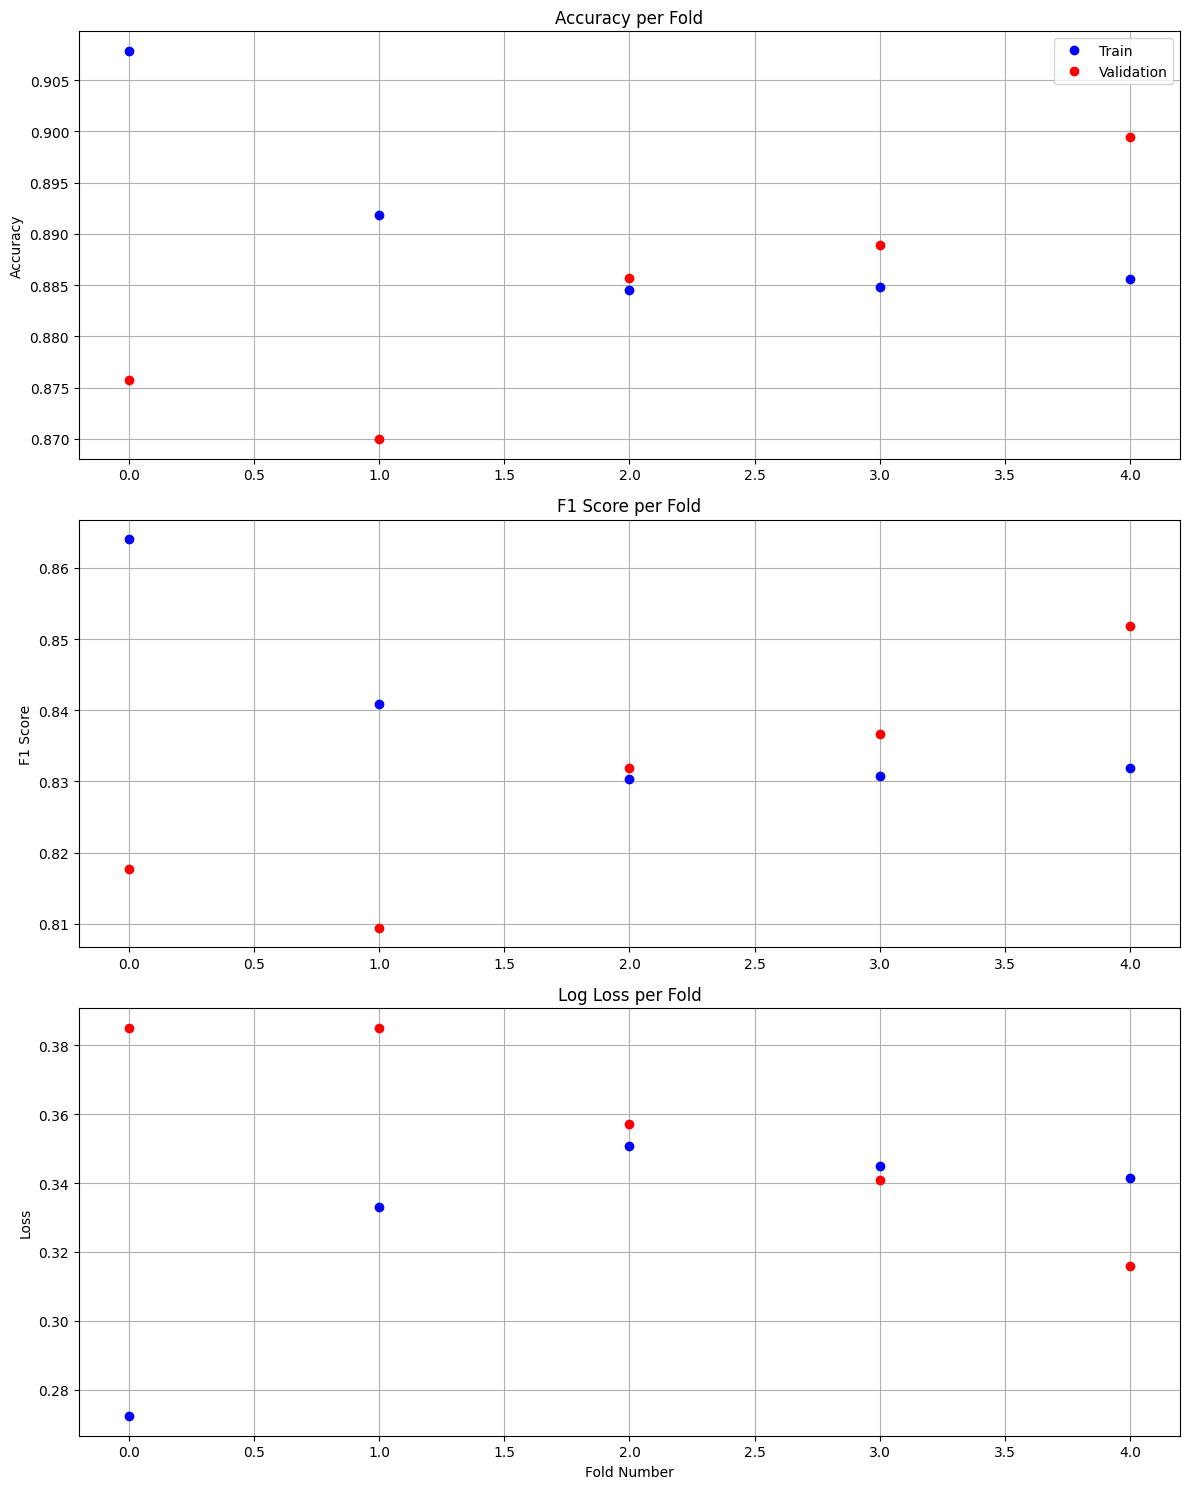


Final Test Set Performance:
Accuracy: 0.9336
F1 Score: 0.9015
Log Loss: 0.2698


<Figure size 800x600 with 0 Axes>

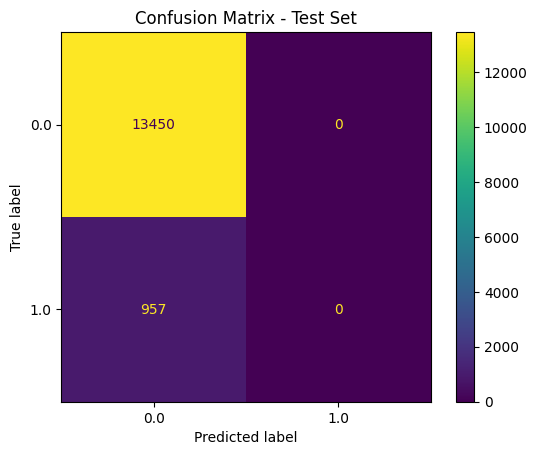


Computing SHAP explanations...


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:

def train_svm_classifier_with_shap(
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_train: pd.Series,
    y_test: pd.Series,
    kernel: str = 'rbf',
    C: float = 1.0,
    gamma: str = 'scale',
    random_state: int = 42,
    shap_sample_size: int = 100  # For computational efficiency
) -> tuple[SVC, dict]:
    """Train and evaluate an SVM classifier with SHAP explainability.

    Args:
        X_train: Training features
        X_test: Test features
        y_train: Training labels
        y_test: Test labels
        kernel: SVM kernel type ('rbf', 'linear', 'poly', 'sigmoid')
        C: Regularization parameter
        gamma: Kernel coefficient
        random_state: Random seed
        shap_sample_size: Number of samples to use for SHAP analysis

    Returns:
        tuple: (best_estimator, results_dict) containing:
            - best_estimator: Trained SVM classifier
            - results_dict: Dictionary containing metrics, plots and SHAP explanations

    Example:
        >>> svm_model, results = train_svm_classifier_with_shap(X_train, X_test, y_train, y_test)
    """
    # Initialize results storage
    results = {
        'train_acc': [],
        'test_acc': [],
        'train_f1': [],
        'test_f1': [],
        'train_loss': [],
        'test_loss': [],
        'fit_times': [],
        'best_estimator': None,
        'confusion_matrix': None,
        'shap_values': None,
        'shap_explainer': None
    }

    # Time-series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)

    # Initialize SVM classifier
    svm = SVC(
        kernel=kernel,
        C=C,
        gamma=gamma,
        probability=True,
        random_state=random_state
    )

    print(f"Training SVM with {kernel} kernel (C={C}, gamma={gamma})")
    print("="*60)

    # For plotting CV results
    fig, ax = plt.subplots(3, 1, figsize=(12, 15))
    fold_splits = []

    for fold, (train_idx, val_idx) in enumerate(tqdm(tscv.split(X_train))): # Removed erroneous second argument
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        fold_splits.append((len(train_idx), len(val_idx)))

        # Train and time fitting
        start_time = time()
        svm.fit(X_tr, y_tr)
        fit_time = time() - start_time

        # Predictions and probabilities
        y_tr_pred = svm.predict(X_tr)
        y_val_pred = svm.predict(X_val)
        y_tr_prob = svm.predict_proba(X_tr)
        y_val_prob = svm.predict_proba(X_val)

        # Store metrics
        results['train_acc'].append(accuracy_score(y_tr, y_tr_pred))
        results['test_acc'].append(accuracy_score(y_val, y_val_pred))
        results['train_f1'].append(f1_score(y_tr, y_tr_pred, average='weighted'))
        results['test_f1'].append(f1_score(y_val, y_val_pred, average='weighted'))
        results['train_loss'].append(log_loss(y_tr, y_tr_prob))
        results['test_loss'].append(log_loss(y_val, y_val_prob))
        results['fit_times'].append(fit_time)

        # Plot training progress
        ax[0].plot(fold, results['train_acc'][-1], 'bo', label='Train' if fold==1 else "")
        ax[0].plot(fold, results['test_acc'][-1], 'ro', label='Validation' if fold==1 else "")
        ax[1].plot(fold, results['train_f1'][-1], 'bo')
        ax[1].plot(fold, results['test_f1'][-1], 'ro')
        ax[2].plot(fold, results['train_loss'][-1], 'bo')
        ax[2].plot(fold, results['test_loss'][-1], 'ro')

        print(f"\nFold {fold} Results:")
        print(f"  Train Accuracy: {results['train_acc'][-1]:.4f}")
        print(f"  Val Accuracy:   {results['test_acc'][-1]:.4f}")
        print(f"  Train F1:       {results['train_f1'][-1]:.4f}")
        print(f"  Val F1:         {results['test_f1'][-1]:.4f}")
        print(f"  Train Loss:     {results['train_loss'][-1]:.4f}")
        print(f"  Val Loss:       {results['test_loss'][-1]:.4f}")
        print(f"  Fit Time:       {fit_time:.2f}s")

    # Final training on full training set
    start_time = time()
    svm.fit(X_train, y_train)
    results['fit_times'].append(time() - start_time)
    results['best_estimator'] = svm

    # Final evaluation on test set
    y_test_pred = svm.predict(X_test)
    y_test_prob = svm.predict_proba(X_test)

    results['test_acc'].append(accuracy_score(y_test, y_test_pred))
    results['test_f1'].append(f1_score(y_test, y_test_pred, average='weighted'))
    results['test_loss'].append(log_loss(y_test, y_test_prob))
    results['confusion_matrix'] = confusion_matrix(y_test, y_test_pred)

    # Configure plots
    ax[0].set_title('Accuracy per Fold')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()
    ax[0].grid()

    ax[1].set_title('F1 Score per Fold')
    ax[1].set_ylabel('F1 Score')
    ax[1].grid()

    ax[2].set_title('Log Loss per Fold')
    ax[2].set_ylabel('Loss')
    ax[2].set_xlabel('Fold Number')
    ax[2].grid()

    plt.tight_layout()
    plt.show()

    # Print final results
    print("\n" + "="*60)
    print("Final Test Set Performance:")
    print(f"Accuracy: {results['test_acc'][-1]:.4f}")
    print(f"F1 Score: {results['test_f1'][-1]:.4f}")
    print(f"Log Loss: {results['test_loss'][-1]:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    ConfusionMatrixDisplay.from_estimator(svm, X_test, y_test)
    plt.title('Confusion Matrix - Test Set')
    plt.show()

    # SHAP Explainability
    print("\nComputing SHAP explanations...")

    # Sample data for SHAP (for performance)
    if len(X_test) > shap_sample_size:
        X_test_shap = X_test.sample(shap_sample_size, random_state=random_state)
    else:
        X_test_shap = X_test.copy()

    # Create SHAP explainer based on kernel type
    if kernel == 'linear':
        explainer = shap.LinearExplainer(svm, X_train)
        # SHAP values for linear model are (n_samples, n_features)
        shap_values = explainer.shap_values(X_test_shap)
    else:
        # For non-linear kernels, SHAP values are (n_samples, n_features) for each class
        explainer = shap.KernelExplainer(svm.predict_proba, X_train.sample(100, random_state=random_state))
        shap_values = explainer.shap_values(X_test_shap)

    results['shap_values'] = shap_values
    results['shap_explainer'] = explainer

    # SHAP Summary Plot
    plt.figure(figsize=(12, 8))
    # For binary classification with predict_proba, shap_values will be a list of arrays [shap_values_class_0, shap_values_class_1]
    # We typically plot for the positive class (class 1)
    if isinstance(shap_values, list) and len(shap_values) == 2:
        shap.summary_plot(shap_values[1], X_test_shap, plot_type="bar", show=False)
    else: # For linear kernel or other cases where shap_values is a single array
        shap.summary_plot(shap_values, X_test_shap, plot_type="bar", show=False)
    plt.title("SHAP Feature Importance")
    plt.tight_layout()
    plt.show()


    # SHAP Summary Plot (detailed)
    plt.figure(figsize=(12, 8))
    if isinstance(shap_values, list) and len(shap_values) == 2:
         shap.summary_plot(shap_values[1], X_test_shap, show=False)
    else:
         shap.summary_plot(shap_values, X_test_shap, show=False)
    plt.title("SHAP Feature Impact")
    plt.tight_layout()
    plt.show()


    # Waterfall Plot for a specific example
    example_idx = 0  # First test example
    plt.figure(figsize=(12, 6))
    # For binary classification with predict_proba, shap_values will be a list of arrays
    # We need to select the values and base value for the class we want to explain (e.g., class 1)
    if isinstance(shap_values, list) and len(shap_values) == 2:
         waterfall(Explanation(values=shap_values[1][example_idx],
                   base_values=explainer.expected_value[1], # Expected value for class 1
                   data=X_test_shap.iloc[example_idx],
                   feature_names=X_test_shap.columns.tolist()), show=False)
    else: # For linear kernel or other cases where shap_values is a single array
         waterfall(Explanation(values=shap_values[example_idx],
                   base_values=explainer.expected_value, # Expected value for single output
                   data=X_test_shap.iloc[example_idx],
                   feature_names=X_test_shap.columns.tolist()), show=False)
    plt.title(f"Waterfall Plot for Example {example_idx}")
    plt.tight_layout()
    plt.show()


    return svm, results

X_train_final_svm, X_test_final_svm, y_train_svm, y_test_svm, feature_names_ml_rf = time_series_pipeline_svm(
    df_ml, aggcodes_cols, aggcol_cats_all, encodedcol_cats_all,
)

# Example usage:
svm_model, results_svm = train_svm_classifier_with_shap(
    X_train_final_svm,
    X_test_final_svm,
    y_train_svm,
    y_test_svm,
    kernel='rbf',
    C=1.0,
    gamma='scale',
    shap_sample_size=100
)

Alternatively we can use the GridSearchCV version

In [ ]:
"""Version with GridSearchCV """

def train_svm(
    X_train_final: pd.DataFrame,
    X_test_final: pd.DataFrame,
    y_train: pd.Series,
    y_test: pd.Series
) -> tuple[Pipeline, GridSearchCV]:
    """Train and optimize an SVM model for time-series regression.

    Implements a comprehensive SVM pipeline with:
    - Multiple kernel support (RBF, linear, polynomial)
    - Kernel-specific hyperparameter tuning
    - Time-series aware cross-validation
    - Automated model evaluation and analysis

    Args:
        X_train_final: Processed training features
        X_test_final: Processed test features
        y_train: Training target values
        y_test: Test target values

    Returns:
        tuple: Contains:
            - final_model: Best performing SVM pipeline
            - grid_search: Complete GridSearchCV results object

    Example:
        >>> svm_model, search_results = train_svm(
        ...     X_train, X_test, y_train, y_test)
    """
    # Ensure numeric data types and handle missing values
    X_train_final = X_train_final.astype(float).fillna(-999)
    X_test_final = X_test_final.astype(float).fillna(-999)

    # Create base pipeline
    svm_pipe = Pipeline([
        ('svm', SVR())
    ])

    # Comprehensive parameter grids for each kernel type
    param_grid = [
        # RBF kernel configuration
        {
            'svm__kernel': ['rbf'],
            'svm__C': [0.1, 1, 10, 100],          # Regularization
            'svm__gamma': ['scale', 'auto', 0.01, 0.1, 1],  # Kernel coefficient
            'svm__epsilon': [0.01, 0.1, 0.5]      # Epsilon-tube
        },
        # Linear kernel configuration
        {
            'svm__kernel': ['linear'],
            'svm__C': [0.1, 1, 10, 100],
            'svm__epsilon': [0.01, 0.1, 0.5]
        },
        # Polynomial kernel configuration
        {
            'svm__kernel': ['poly'],
            'svm__C': [0.1, 1, 10],
            'svm__degree': [2, 3],                # Polynomial degree
            'svm__gamma': ['scale', 'auto'],
            'svm__epsilon': [0.01, 0.1]
        }
    ]

    # Time-series cross-validation (maintains temporal order)
    tscv = TimeSeriesSplit(n_splits=5)

    # Configure exhaustive grid search
    grid_search = GridSearchCV(
        estimator=svm_pipe,
        param_grid=param_grid,
        cv=tscv,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,               # Use all available cores
        verbose=1,               # Show progress
        refit=True               # Retrain best model on full data
    )

    # Execute hyperparameter optimization
    grid_search.fit(X_train_final, y_train)

    # Display best parameters
    print("\nOptimal SVM Configuration:")
    print(grid_search.best_params_)

    # Visualize performance across kernel types
    results = pd.DataFrame(grid_search.cv_results_)
    plt.figure(figsize=(12, 6))

    for kernel in ['rbf', 'linear', 'poly']:
        kernel_results = results[results['param_svm__kernel'] == kernel]
        plt.plot(
            -kernel_results['mean_test_score'],
            label=f'{kernel} kernel',
            marker='o'
        )

    plt.xlabel("Parameter Combination Index")
    plt.ylabel("Cross-Validated RMSE")
    plt.title("SVM Kernel Performance Comparison")
    plt.legend()
    plt.grid()
    plt.show()

    # Evaluate best model
    final_model = grid_search.best_estimator_
    y_pred = final_model.predict(X_test_final)
    test_rmse = mean_squared_error(y_test, y_pred, squared=False)

    best_kernel = grid_search.best_params_['svm__kernel']
    print(f"\nBest Performing Kernel: {best_kernel}")
    print(f"Test Set RMSE: {test_rmse:.4f}")

    # Feature importance for linear models
    if best_kernel == 'linear':
        coefs = pd.Series(
            final_model.named_steps['svm'].coef_[0],
            index=X_train_final.columns
        )
        print("\nTop 10 Most Important Features:")
        print(coefs.abs().sort_values(ascending=False).head(10))

    return final_model, grid_search

X_train_final_svm, X_test_final_svm, y_train_svm, y_test_svm, feature_names_ml_svm = time_series_pipeline_ml(
        df_ml, aggcodes_cols, aggcol_cats_all, encodedcol_cats_all,
        cat_cols, num_cols, model_type='svm'
    )

# Application
svm_model, svm_search = train_svm(
    X_train_final_svm.copy(),  # Prevent modification of original data
    X_test_final_svm.copy(),
    y_train_svm,
    y_test_svm
)

### XGBoost

We implement an optimized XGBoost pipeline for time-series forecasting, featuring automated categorical feature encoding, time-series aware cross-validation, and hyperparameter tuning. The pipeline first ensures consistent label encoding of categorical variables across train/test sets, then performs grid search with temporal validation to optimize key parameters like learning rate, tree depth, and regularization. The final model is evaluated using RMSE and includes feature importance analysis to identify the most predictive temporal patterns.

XGBoost is chosen for its superior handling of temporal data through: (1) native support for categorical features via optimal encoding, (2) built-in regularization to prevent overfitting on time-series noise, and (3) gradient boosting's inherent ability to capture complex temporal dependencies. The time-series cross-validation maintains chronological integrity during tuning, while the feature importance analysis helps validate whether engineered time features (lags, rolling stats) are being properly utilized. The implementation balances model performance with interpretability through visual diagnostics of both hyperparameter performance and feature contributions.

The function train_xgboost_classifier is designed to train an XGBoost classification model using time-series cross-validation and then evaluate its performance on a test set. It takes training and testing datasets as inputs, along with optional hyperparameters for the model and a parameter for the sample size used in SHAP explainability analysis. During training, the function performs 5-fold time-series splits, fitting the model on each fold while recording metrics such as accuracy, F1 score, log loss, and training time. It visualizes these metrics over the folds to track performance progression. After cross-validation, the model is retrained on the entire training data and evaluated on the test set, with results stored in a dictionary including confusion matrix and classification report.

In addition to training and evaluation, train_xgboost_classifier incorporates explainability through SHAP values. It samples a subset of test data for computational efficiency and uses the SHAP explainer to calculate feature contributions to the model's predictions. The function produces various plots, including SHAP summary plots that show overall feature importance and impact, and waterfall plots for detailed insight into individual predictions. This integration of explainability helps understand how the model makes decisions, complementing the quantitative performance evaluation. The function returns both the trained XGBoost model and a results dictionary containing metrics, plots, and SHAP explanations for further analysis.

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['NaN'] will be ignored
  warnings.warn(


Training XGBoost Classifier
Model Parameters:
objective: binary:logistic
eval_metric: logloss
learning_rate: 0.05
max_depth: 6
subsample: 0.8
colsample_bytree: 0.8
reg_lambda: 1.0
n_estimators: 500
random_state: 42


1it [00:48, 48.27s/it]


Fold 0 Results:
  Train Accuracy: 0.9970
  Val Accuracy:   0.8781
  Train F1:       0.9970
  Val F1:         0.8297
  Train Loss:     0.0257
  Val Loss:       0.4527
  Fit Time:       46.35s


2it [01:44, 53.07s/it]


Fold 1 Results:
  Train Accuracy: 0.9924
  Val Accuracy:   0.8712
  Train F1:       0.9923
  Val F1:         0.8236
  Train Loss:     0.0646
  Val Loss:       0.3888
  Fit Time:       54.71s


3it [02:43, 55.87s/it]


Fold 2 Results:
  Train Accuracy: 0.9682
  Val Accuracy:   0.8863
  Train F1:       0.9660
  Val F1:         0.8478
  Train Loss:     0.1081
  Val Loss:       0.3241
  Fit Time:       57.40s


4it [03:51, 60.40s/it]


Fold 3 Results:
  Train Accuracy: 0.9517
  Val Accuracy:   0.8915
  Train F1:       0.9461
  Val F1:         0.8551
  Train Loss:     0.1314
  Val Loss:       0.3007
  Fit Time:       65.02s


5it [05:06, 61.27s/it]


Fold 4 Results:
  Train Accuracy: 0.9421
  Val Accuracy:   0.8988
  Train F1:       0.9336
  Val F1:         0.8660
  Train Loss:     0.1486
  Val Loss:       0.2916
  Fit Time:       72.51s


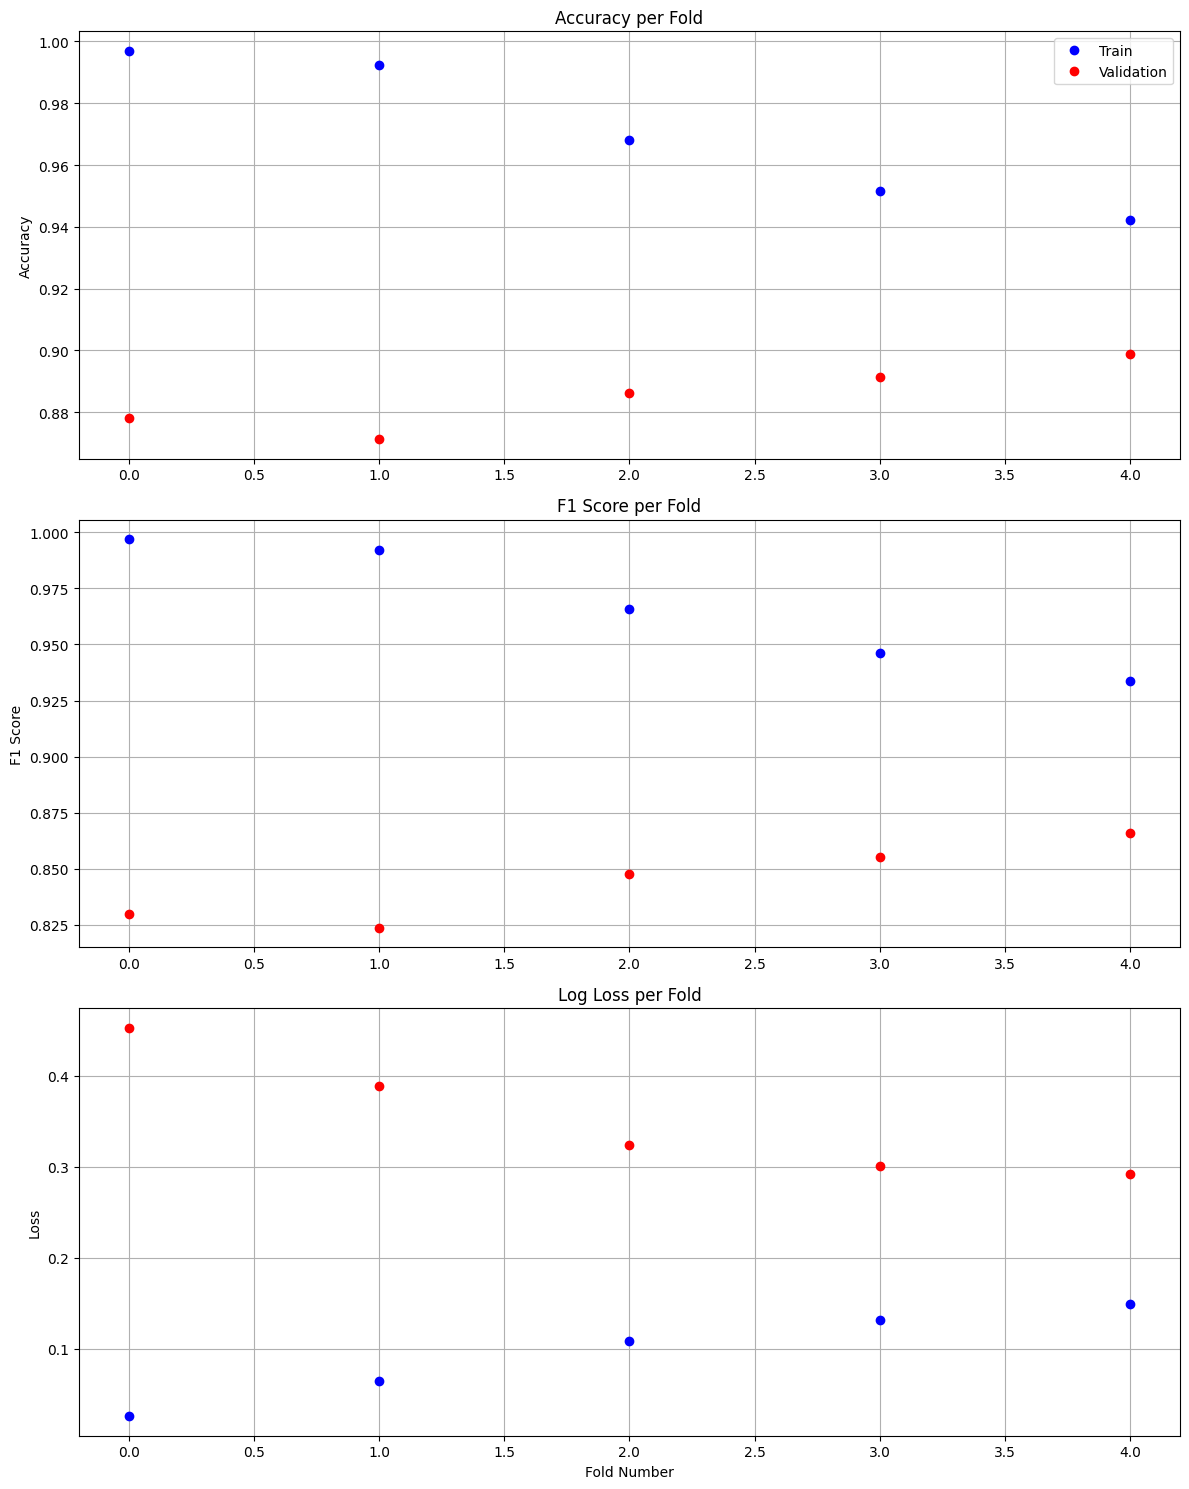


Final Test Set Performance:
Accuracy: 0.9335
F1 Score: 0.9071
Log Loss: 0.2167

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     13450
         1.0       0.49      0.05      0.09       957

    accuracy                           0.93     14407
   macro avg       0.72      0.52      0.53     14407
weighted avg       0.91      0.93      0.91     14407



<Figure size 800x600 with 0 Axes>

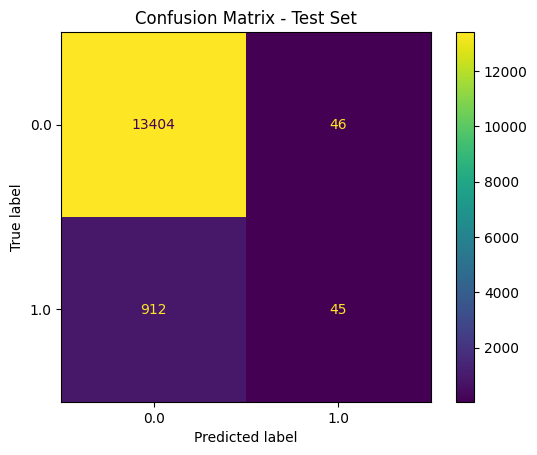

<Figure size 1200x800 with 0 Axes>

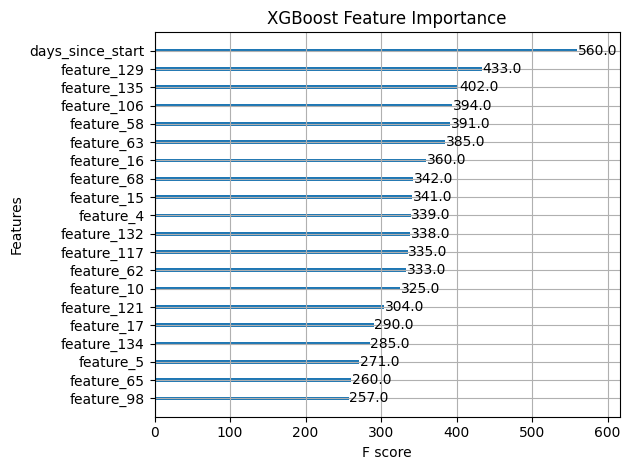


Computing SHAP explanations...


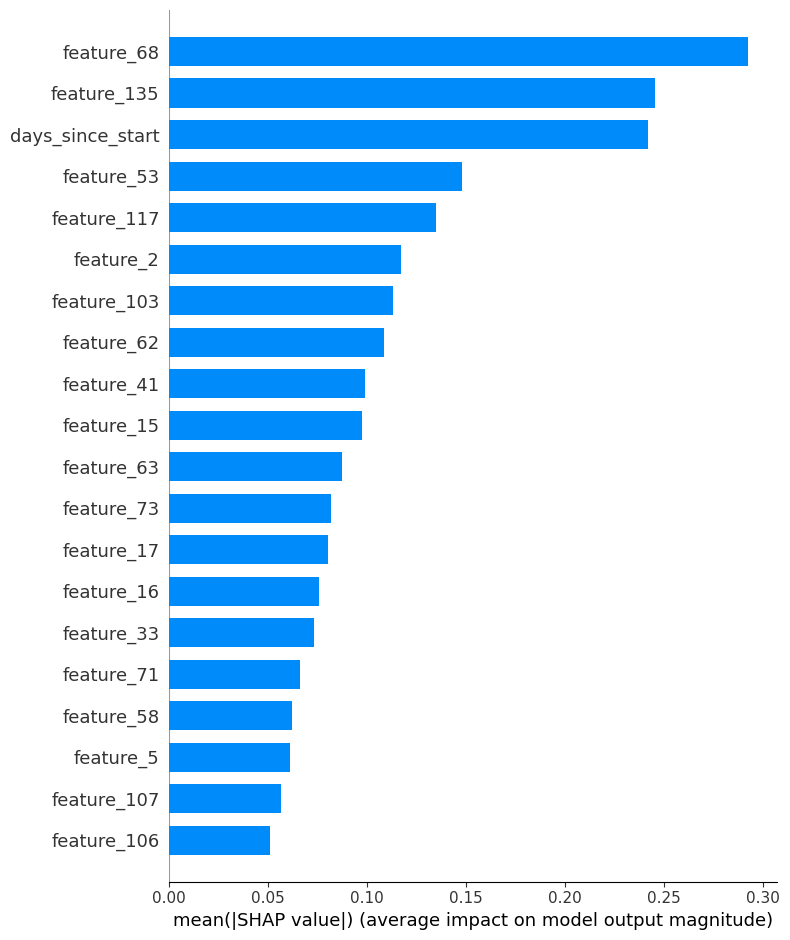

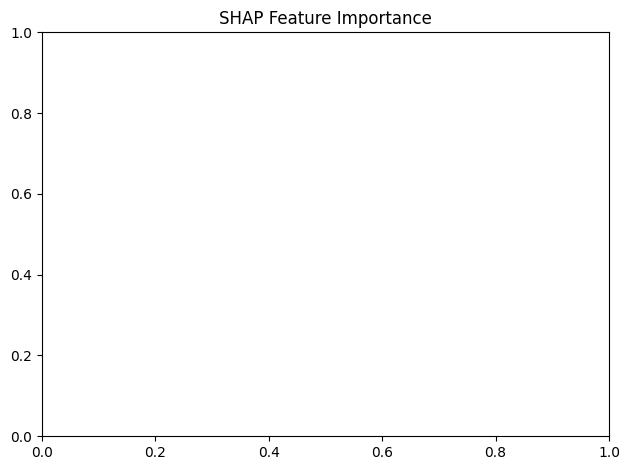

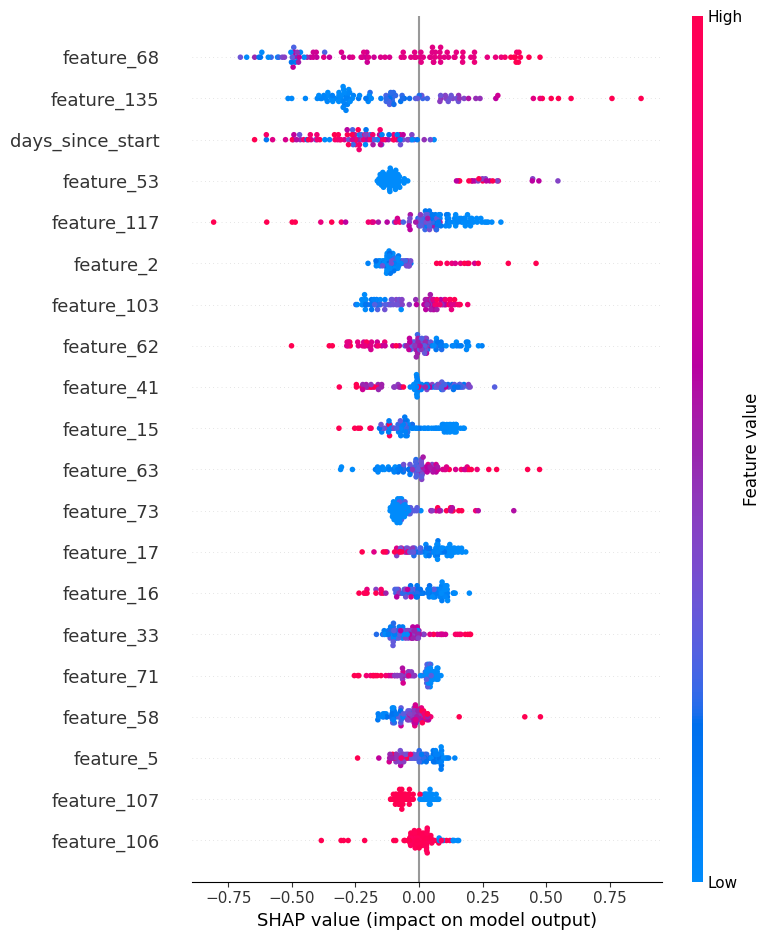

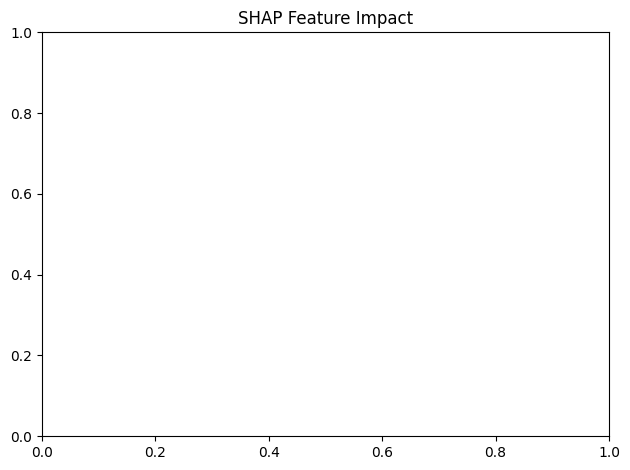

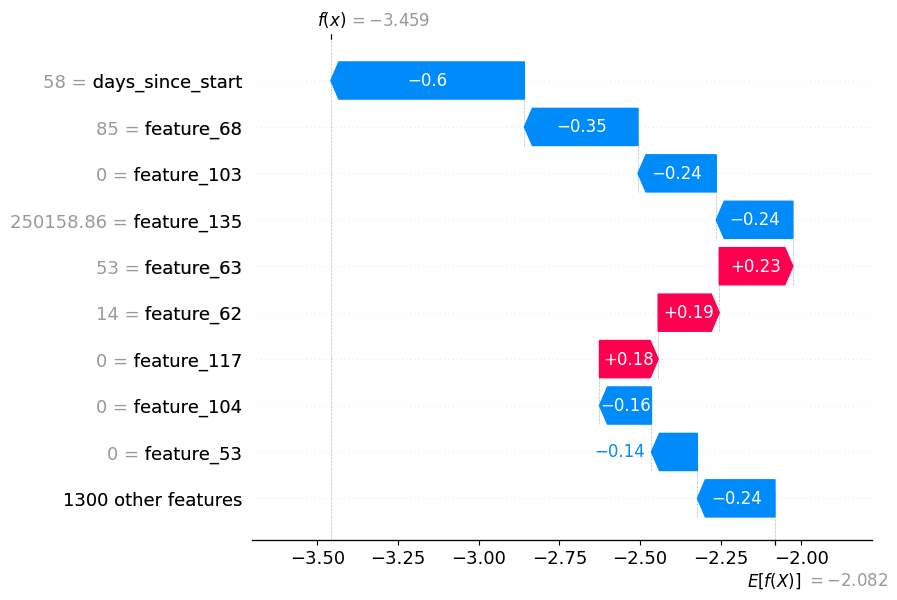

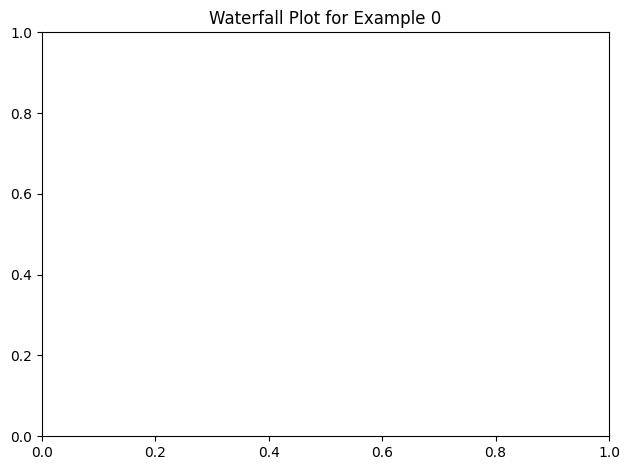

In [ ]:
import shap
from shap import Explanation
from shap.plots import waterfall
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (accuracy_score, f1_score, log_loss,
                           confusion_matrix, ConfusionMatrixDisplay, classification_report) # Added classification_report
import xgboost as xgb
from tqdm import tqdm
from time import time
import matplotlib.pyplot as plt
import pandas as pd # Added import

def train_xgboost_classifier(
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_train: pd.Series,
    y_test: pd.Series,
    params: dict = None,
    shap_sample_size: int = 100,
    random_state: int = 42
) -> tuple[xgb.XGBClassifier, dict]:
    """Train and evaluate XGBoost classifier with SHAP explainability.

    Args:
        X_train: Training features
        X_test: Test features
        y_train: Training labels
        y_test: Test labels
        params: Dictionary of XGBoost parameters
        shap_sample_size: Number of samples for SHAP analysis
        random_state: Random seed

    Returns:
        tuple: (best_estimator, results_dict) containing:
            - best_estimator: Trained XGBoost classifier
            - results_dict: Dictionary containing metrics, plots and SHAP explanations
    """
    # Initialize results storage
    results = {
        'train_acc': [],
        'test_acc': [],
        'train_f1': [],
        'test_f1': [],
        'train_loss': [],
        'test_loss': [],
        'fit_times': [],
        'best_estimator': None,
        'confusion_matrix': None,
        'classification_report': None,
        'shap_values': None,
        'shap_explainer': None,
        'feature_importance': None
    }

    # Default parameters if none provided
    if params is None:
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'tree_method': 'hist',
            'seed': random_state,
            'learning_rate': 0.05,
            'max_depth': 6,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'reg_lambda': 1.0,
            'n_estimators': 500
        }

    # Time-series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)

    # Initialize XGBoost classifier
    xgb_clf = xgb.XGBClassifier(**params)

    print("Training XGBoost Classifier")
    print("="*60)
    print("Model Parameters:")
    for k, v in params.items():
        print(f"{k}: {v}")
    print("="*60)

    # For plotting CV results
    fig, ax = plt.subplots(3, 1, figsize=(12, 15))
    fold_splits = []

    for fold, (train_idx, val_idx) in enumerate(tqdm(tscv.split(X_train))): # Removed erroneous second argument
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        fold_splits.append((len(train_idx), len(val_idx)))

        # Train and time fitting
        start_time = time()
        xgb_clf.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
        fit_time = time() - start_time

        # Predictions and probabilities
        y_tr_pred = xgb_clf.predict(X_tr)
        y_val_pred = xgb_clf.predict(X_val)
        y_tr_prob = xgb_clf.predict_proba(X_tr)
        y_val_prob = xgb_clf.predict_proba(X_val)

        # Store metrics
        results['train_acc'].append(accuracy_score(y_tr, y_tr_pred))
        results['test_acc'].append(accuracy_score(y_val, y_val_pred))
        results['train_f1'].append(f1_score(y_tr, y_tr_pred, average='weighted'))
        results['test_f1'].append(f1_score(y_val, y_val_pred, average='weighted'))
        results['train_loss'].append(log_loss(y_tr, y_tr_prob))
        results['test_loss'].append(log_loss(y_val, y_val_prob))
        results['fit_times'].append(fit_time)

        # Plot training progress
        ax[0].plot(fold, results['train_acc'][-1], 'bo', label='Train' if fold==1 else "")
        ax[0].plot(fold, results['test_acc'][-1], 'ro', label='Validation' if fold==1 else "")
        ax[1].plot(fold, results['train_f1'][-1], 'bo')
        ax[1].plot(fold, results['test_f1'][-1], 'ro')
        ax[2].plot(fold, results['train_loss'][-1], 'bo')
        ax[2].plot(fold, results['test_loss'][-1], 'ro')

        print(f"\nFold {fold} Results:")
        print(f"  Train Accuracy: {results['train_acc'][-1]:.4f}")
        print(f"  Val Accuracy:   {results['test_acc'][-1]:.4f}")
        print(f"  Train F1:       {results['train_f1'][-1]:.4f}")
        print(f"  Val F1:         {results['test_f1'][-1]:.4f}")
        print(f"  Train Loss:     {results['train_loss'][-1]:.4f}")
        print(f"  Val Loss:       {results['test_loss'][-1]:.4f}")
        print(f"  Fit Time:       {fit_time:.2f}s")

    # Final training on full training set
    start_time = time()
    xgb_clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    results['fit_times'].append(time() - start_time)
    results['best_estimator'] = xgb_clf

    # Final evaluation on test set
    y_test_pred = xgb_clf.predict(X_test)
    y_test_prob = xgb_clf.predict_proba(X_test)

    results['test_acc'].append(accuracy_score(y_test, y_test_pred))
    results['test_f1'].append(f1_score(y_test, y_test_pred, average='weighted'))
    results['test_loss'].append(log_loss(y_test, y_test_prob))
    results['confusion_matrix'] = confusion_matrix(y_test, y_test_pred)
    results['classification_report'] = classification_report(y_test, y_test_pred)

    # Feature importance
    results['feature_importance'] = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': xgb_clf.feature_importances_
    }).sort_values('Importance', ascending=False)

    # Configure plots
    ax[0].set_title('Accuracy per Fold')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()
    ax[0].grid()

    ax[1].set_title('F1 Score per Fold')
    ax[1].set_ylabel('F1 Score')
    ax[1].grid()

    ax[2].set_title('Log Loss per Fold')
    ax[2].set_ylabel('Loss')
    ax[2].set_xlabel('Fold Number')
    ax[2].grid()

    plt.tight_layout()
    plt.show()

    # Print final results
    print("\n" + "="*60)
    print("Final Test Set Performance:")
    print(f"Accuracy: {results['test_acc'][-1]:.4f}")
    print(f"F1 Score: {results['test_f1'][-1]:.4f}")
    print(f"Log Loss: {results['test_loss'][-1]:.4f}")
    print("\nClassification Report:")
    print(results['classification_report'])

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    ConfusionMatrixDisplay.from_estimator(xgb_clf, X_test, y_test)
    plt.title('Confusion Matrix - Test Set')
    plt.show()

    # Feature importance plot
    plt.figure(figsize=(12, 8))
    xgb.plot_importance(xgb_clf, max_num_features=20, importance_type='weight')
    plt.title('XGBoost Feature Importance')
    plt.tight_layout()
    plt.show()

    # SHAP Explainability
    print("\nComputing SHAP explanations...")

    # Sample data for SHAP (for performance)
    if len(X_test) > shap_sample_size:
        X_test_shap = X_test.sample(shap_sample_size, random_state=random_state)
    else:
        X_test_shap = X_test.copy()

    # Create SHAP explainer
    explainer = shap.Explainer(xgb_clf)
    shap_values = explainer(X_test_shap)
    results['shap_values'] = shap_values
    results['shap_explainer'] = explainer

    # SHAP Summary Plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_shap, plot_type="bar")
    plt.title("SHAP Feature Importance")
    plt.tight_layout()
    plt.show()

    # SHAP Summary Plot (detailed)
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_shap)
    plt.title("SHAP Feature Impact")
    plt.tight_layout()
    plt.show()

    # Waterfall Plot for a specific example
    example_idx = 0  # First test example
    plt.figure(figsize=(12, 6))
    waterfall(shap_values[example_idx])
    plt.title(f"Waterfall Plot for Example {example_idx}")
    plt.tight_layout()
    plt.show()

    return xgb_clf, results

# Prepare data and run model

X_train_ml_xgb, X_test_ml_xgb, y_train_ml_xbg, y_test_ml_xbg, feature_names_ml_rf = time_series_pipeline_ml(
    df_ml, aggcodes_cols, aggcol_cats_all, encodedcol_cats_all, model_type='xgb'
)

xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_lambda': 1.0,
    'n_estimators': 500,
    'random_state': 42
}

xgb_model, xgb_results = train_xgboost_classifier(
    X_train_ml_xgb,
    X_test_ml_xgb,
    y_train_ml_xbg,
    y_test_ml_xbg,
    params=xgb_params,
    shap_sample_size=100
)

### Random Forest

We finally implement a comprehensive Random Forest regression pipeline for time-series forecasting, specifically designed to handle temporal dependencies while preventing data leakage. The pipeline performs time-series-aware cross-validation to maintain chronological order during hyperparameter tuning, optimizing for RMSE (Root Mean Squared Error) through grid search over key parameters like tree depth, number of estimators, and splitting criteria. The rationale behind this approach stems from Random Forests' inherent advantages for time-series data: robustness to non-linear patterns, automatic feature selection through importance scoring, and reduced overfitting via ensemble averaging. By using time-series splits rather than random shuffling, the validation strategy respects temporal dependencies, while the feature importance analysis provides interpretable insights into which time-based features (like lags or rolling statistics) most influence predictions. The implementation balances model performance with computational efficiency through parallel processing and includes diagnostic visualizations to guide model selection and interpretation.

The function  train_random_forest_classifier trains and evaluates a Random Forest classifier, incorporating SHAP-based explainability for interpreting model predictions. It accepts training and test datasets along with labels, optional hyperparameters, a SHAP sample size for analysis, and a random seed. The function performs time-series cross-validation, tracks various performance metrics including accuracy, F1 score, and log loss, and plots these metrics across folds.

After cross-validation, the function fits the final model on the full training data, evaluates it on the test set, and generates key outputs like the confusion matrix, classification report, and feature importance. It also computes SHAP values to explain feature contributions, displaying both summary and detailed SHAP plots along with a waterfall plot for a specific test example. The function returns the trained Random Forest model and a dictionary containing all collected results and artifacts.

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['NaN'] will be ignored
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['NaN'] will be ignored
  warnings.warn(


Training Random Forest Classifier
Model Parameters:
n_estimators: 200
max_depth: None
min_samples_split: 2
max_features: sqrt
bootstrap: True
oob_score: True
n_jobs: -1
random_state: 42
verbose: 0


1it [00:05,  5.78s/it]


Fold 0 Results:
  Train Accuracy: 0.9970
  Val Accuracy:   0.8777
  Train F1:       0.9970
  Val F1:         0.8228
  Train Loss:     0.0618
  Val Loss:       0.3457
  Fit Time:       5.08s


2it [00:16,  8.91s/it]


Fold 1 Results:
  Train Accuracy: 0.9968
  Val Accuracy:   0.8706
  Train F1:       0.9968
  Val F1:         0.8138
  Train Loss:     0.0724
  Val Loss:       0.3615
  Fit Time:       10.12s


3it [00:37, 14.19s/it]


Fold 2 Results:
  Train Accuracy: 0.9971
  Val Accuracy:   0.8880
  Train F1:       0.9970
  Val F1:         0.8384
  Train Loss:     0.0767
  Val Loss:       0.3196
  Fit Time:       18.05s


4it [01:06, 20.06s/it]


Fold 3 Results:
  Train Accuracy: 0.9970
  Val Accuracy:   0.8908
  Train F1:       0.9970
  Val F1:         0.8451
  Train Loss:     0.0764
  Val Loss:       0.3077
  Fit Time:       26.45s


5it [01:38, 19.75s/it]


Fold 4 Results:
  Train Accuracy: 0.9968
  Val Accuracy:   0.9009
  Train F1:       0.9968
  Val F1:         0.8615
  Train Loss:     0.0757
  Val Loss:       0.2976
  Fit Time:       29.72s


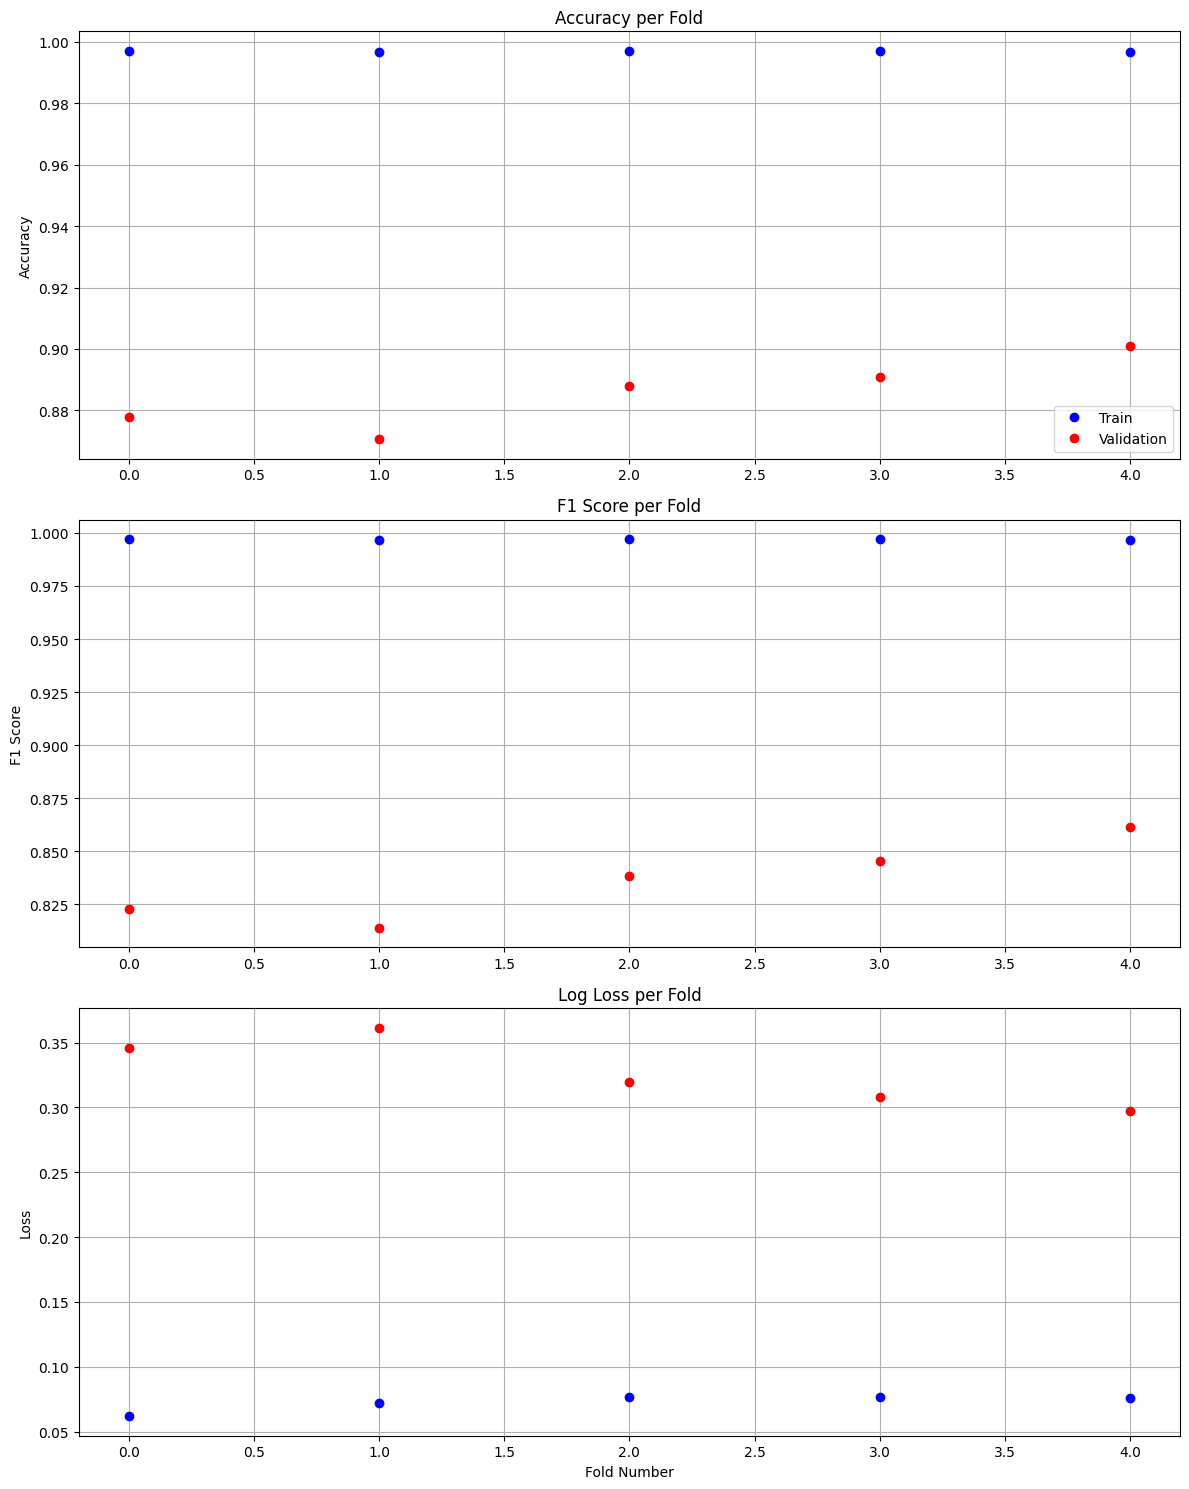


Final Test Set Performance:
Accuracy: 0.9343
F1 Score: 0.9046
Log Loss: 0.2393
Out-of-Bag Score: 0.8937

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.97     13450
         1.0       0.66      0.02      0.04       957

    accuracy                           0.93     14407
   macro avg       0.80      0.51      0.50     14407
weighted avg       0.92      0.93      0.90     14407



<Figure size 800x600 with 0 Axes>

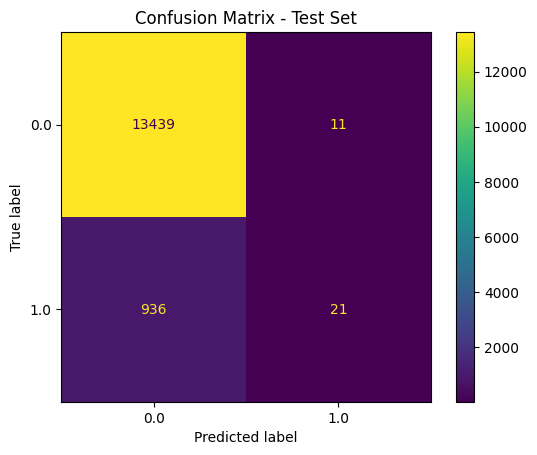

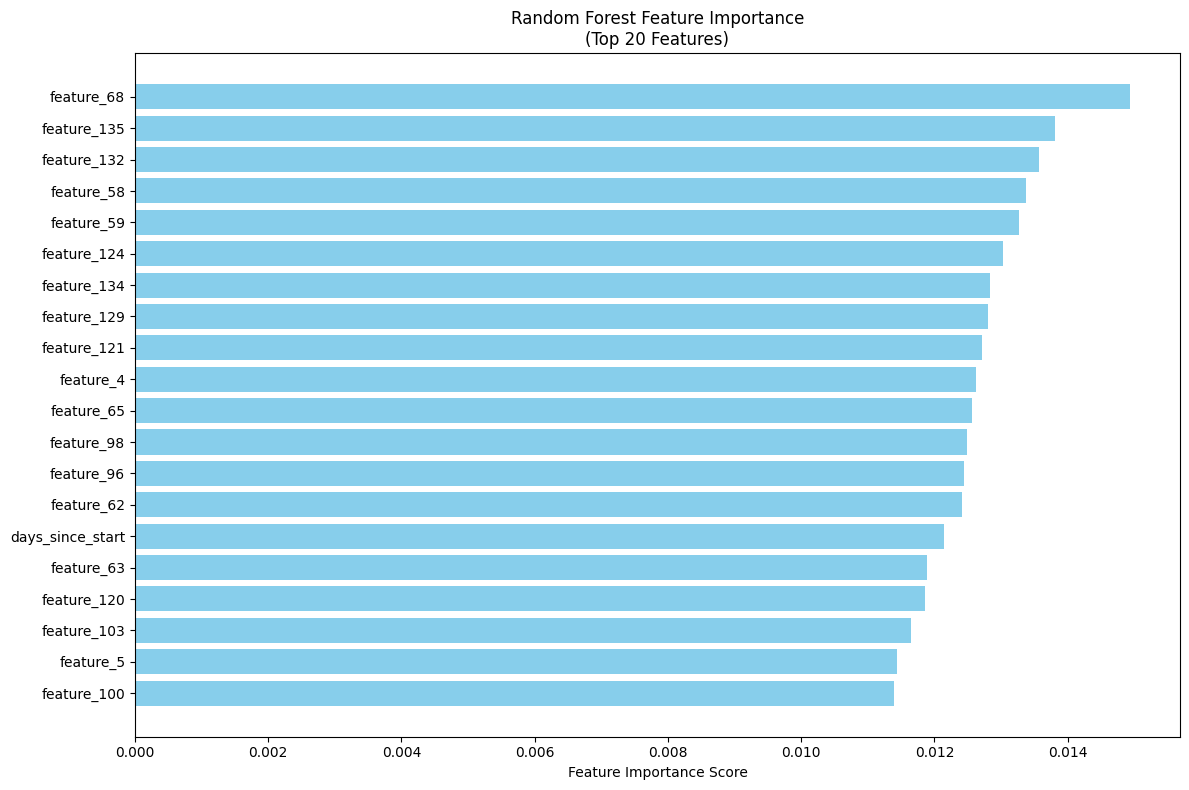


Computing SHAP explanations...


<Figure size 1200x800 with 0 Axes>

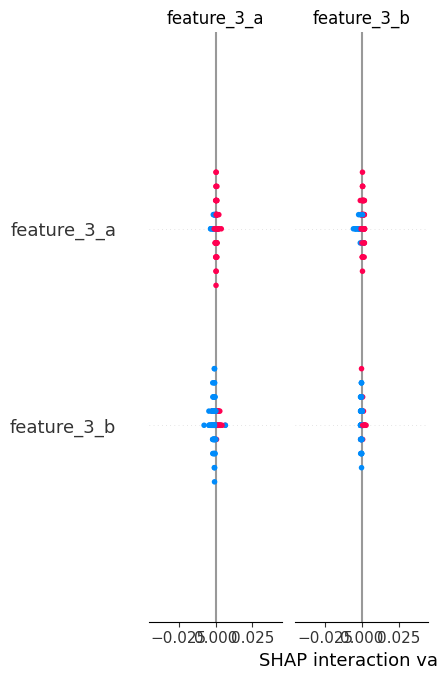

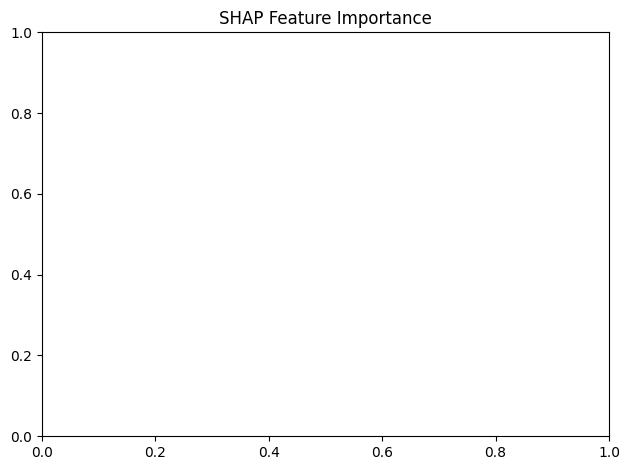

<Figure size 1200x800 with 0 Axes>

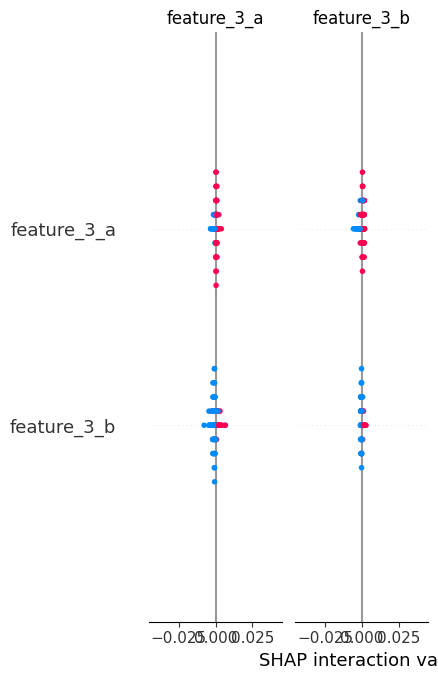

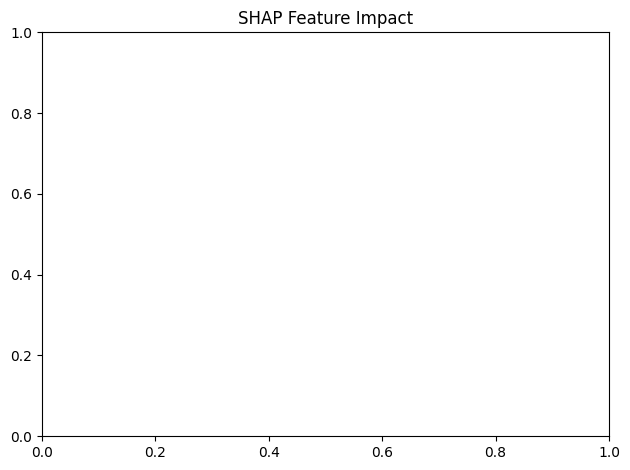

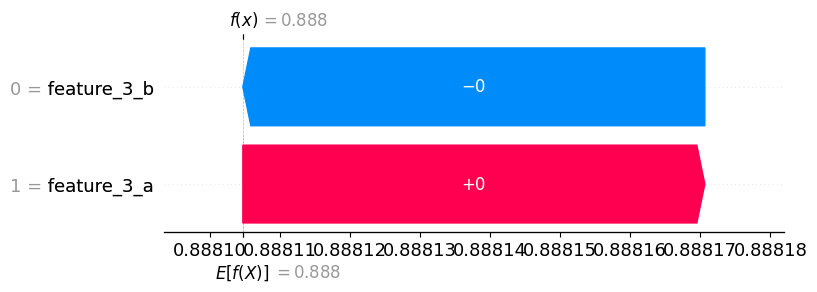

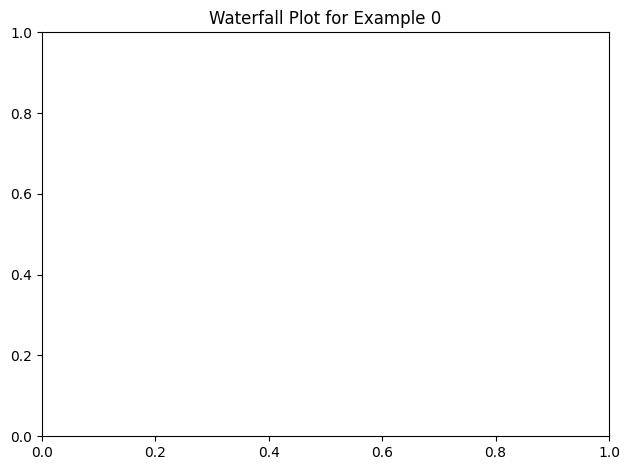

In [ ]:

def train_random_forest_classifier(
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_train: pd.Series,
    y_test: pd.Series,
    params: dict = None,
    shap_sample_size: int = 100,
    random_state: int = 42
) -> tuple[RandomForestClassifier, dict]:
    """Train and evaluate Random Forest classifier with SHAP explainability.

    Args:
        X_train: Training features
        X_test: Test features
        y_train: Training labels
        y_test: Test labels
        params: Dictionary of Random Forest parameters
        shap_sample_size: Number of samples for SHAP analysis
        random_state: Random seed

    Returns:
        tuple: (best_estimator, results_dict) containing:
            - best_estimator: Trained Random Forest classifier
            - results_dict: Dictionary containing metrics, plots and SHAP explanations
    """
    # Initialize results storage
    results = {
        'train_acc': [],
        'test_acc': [],
        'train_f1': [],
        'test_f1': [],
        'train_loss': [],
        'test_loss': [],
        'fit_times': [],
        'best_estimator': None,
        'confusion_matrix': None,
        'classification_report': None,
        'shap_values': None,
        'shap_explainer': None,
        'feature_importance': None
    }

    # Default parameters if none provided
    if params is None:
        params = {
            'n_estimators': 200,
            'max_depth': None,
            'min_samples_split': 2,
            'max_features': 'sqrt',
            'bootstrap': True,
            'oob_score': True,
            'n_jobs': -1,
            'random_state': random_state,
            'verbose': 0
        }

    # Time-series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)

    # Initialize Random Forest classifier
    rf_clf = RandomForestClassifier(**params)

    print("Training Random Forest Classifier")
    print("="*60)
    print("Model Parameters:")
    for k, v in params.items():
        print(f"{k}: {v}")
    print("="*60)

    # For plotting CV results
    fig, ax = plt.subplots(3, 1, figsize=(12, 15))
    fold_splits = []

    for fold, (train_idx, val_idx) in enumerate(tqdm(tscv.split(X_train))): # Removed erroneous second argument
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        fold_splits.append((len(train_idx), len(val_idx)))

        # Train and time fitting
        start_time = time()
        rf_clf.fit(X_tr, y_tr)
        fit_time = time() - start_time

        # Predictions and probabilities
        y_tr_pred = rf_clf.predict(X_tr)
        y_val_pred = rf_clf.predict(X_val)
        y_tr_prob = rf_clf.predict_proba(X_tr)
        y_val_prob = rf_clf.predict_proba(X_val)

        # Store metrics
        results['train_acc'].append(accuracy_score(y_tr, y_tr_pred))
        results['test_acc'].append(accuracy_score(y_val, y_val_pred))
        results['train_f1'].append(f1_score(y_tr, y_tr_pred, average='weighted'))
        results['test_f1'].append(f1_score(y_val, y_val_pred, average='weighted'))
        results['train_loss'].append(log_loss(y_tr, y_tr_prob))
        results['test_loss'].append(log_loss(y_val, y_val_prob))
        results['fit_times'].append(fit_time)

        # Plot training progress
        ax[0].plot(fold, results['train_acc'][-1], 'bo', label='Train' if fold==1 else "")
        ax[0].plot(fold, results['test_acc'][-1], 'ro', label='Validation' if fold==1 else "")
        ax[1].plot(fold, results['train_f1'][-1], 'bo')
        ax[1].plot(fold, results['test_f1'][-1], 'ro')
        ax[2].plot(fold, results['train_loss'][-1], 'bo')
        ax[2].plot(fold, results['test_loss'][-1], 'ro')

        print(f"\nFold {fold} Results:")
        print(f"  Train Accuracy: {results['train_acc'][-1]:.4f}")
        print(f"  Val Accuracy:   {results['test_acc'][-1]:.4f}")
        print(f"  Train F1:       {results['train_f1'][-1]:.4f}")
        print(f"  Val F1:         {results['test_f1'][-1]:.4f}")
        print(f"  Train Loss:     {results['train_loss'][-1]:.4f}")
        print(f"  Val Loss:       {results['test_loss'][-1]:.4f}")
        print(f"  Fit Time:       {fit_time:.2f}s")

    # Final training on full training set
    start_time = time()
    rf_clf.fit(X_train, y_train)
    results['fit_times'].append(time() - start_time)
    results['best_estimator'] = rf_clf

    # Final evaluation on test set
    y_test_pred = rf_clf.predict(X_test)
    y_test_prob = rf_clf.predict_proba(X_test)

    results['test_acc'].append(accuracy_score(y_test, y_test_pred))
    results['test_f1'].append(f1_score(y_test, y_test_pred, average='weighted'))
    results['test_loss'].append(log_loss(y_test, y_test_prob))
    results['confusion_matrix'] = confusion_matrix(y_test, y_test_pred)
    results['classification_report'] = classification_report(y_test, y_test_pred)

    # Feature importance
    results['feature_importance'] = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': rf_clf.feature_importances_
    }).sort_values('Importance', ascending=False)

    # Configure plots
    ax[0].set_title('Accuracy per Fold')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()
    ax[0].grid()

    ax[1].set_title('F1 Score per Fold')
    ax[1].set_ylabel('F1 Score')
    ax[1].grid()

    ax[2].set_title('Log Loss per Fold')
    ax[2].set_ylabel('Loss')
    ax[2].set_xlabel('Fold Number')
    ax[2].grid()

    plt.tight_layout()
    plt.show()

    # Print final results
    print("\n" + "="*60)
    print("Final Test Set Performance:")
    print(f"Accuracy: {results['test_acc'][-1]:.4f}")
    print(f"F1 Score: {results['test_f1'][-1]:.4f}")
    print(f"Log Loss: {results['test_loss'][-1]:.4f}")
    if params.get('oob_score', False):
        print(f"Out-of-Bag Score: {rf_clf.oob_score_:.4f}")
    print("\nClassification Report:")
    print(results['classification_report'])

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    ConfusionMatrixDisplay.from_estimator(rf_clf, X_test, y_test)
    plt.title('Confusion Matrix - Test Set')
    plt.show()

    # Feature importance plot
    plt.figure(figsize=(12, 8))
    top_features = results['feature_importance'].head(20)
    plt.barh(top_features['Feature'][::-1], top_features['Importance'][::-1], color='skyblue')
    plt.xlabel("Feature Importance Score")
    plt.title("Random Forest Feature Importance\n(Top 20 Features)")
    plt.tight_layout()
    plt.show()

    # SHAP Explainability
    print("\nComputing SHAP explanations...")

    # Sample data for SHAP (for performance)
    if len(X_test) > shap_sample_size:
        X_test_shap = X_test.sample(shap_sample_size, random_state=random_state)
    else:
        X_test_shap = X_test.copy()

    # Create SHAP explainer
    explainer = shap.TreeExplainer(rf_clf)
    shap_values = explainer.shap_values(X_test_shap)
    results['shap_values'] = shap_values
    results['shap_explainer'] = explainer

    # SHAP Summary Plot
    plt.figure(figsize=(12, 8))
    if len(shap_values) == 2:  # Binary classification
        shap.summary_plot(shap_values[1], X_test_shap, plot_type="bar")
    else:  # Multi-class
        shap.summary_plot(shap_values, X_test_shap, plot_type="bar")
    plt.title("SHAP Feature Importance")
    plt.tight_layout()
    plt.show()

    # SHAP Summary Plot (detailed)
    plt.figure(figsize=(12, 8))
    if len(shap_values) == 2:  # Binary classification
        shap.summary_plot(shap_values[1], X_test_shap)
    else:  # Multi-class
        shap.summary_plot(shap_values, X_test_shap)
    plt.title("SHAP Feature Impact")
    plt.tight_layout()
    plt.show()

    # Waterfall Plot for a specific example
    example_idx = 0  # First test example
    plt.figure(figsize=(12, 6))
    if len(shap_values) == 2:  # Binary classification
        waterfall(Explanation(values=shap_values[1][example_idx],
                 base_values=explainer.expected_value[1],
                 data=X_test_shap.iloc[example_idx],
                 feature_names=X_test_shap.columns.tolist()))
    else:  # Multi-class
        waterfall(Explanation(values=shap_values[0][example_idx],
                 base_values=explainer.expected_value[0],
                 data=X_test_shap.iloc[example_idx],
                 feature_names=X_test_shap.columns.tolist()))
    plt.title(f"Waterfall Plot for Example {example_idx}")
    plt.tight_layout()
    plt.show()

    return rf_clf, results


# Run Model

X_train_ml_rf, X_test_ml_rf, y_train_ml_rf, y_test_ml_rf, feature_names_ml_rf = time_series_pipeline_ml(
    df_ml, aggcodes_cols, aggcol_cats_all, encodedcol_cats_all, model_type='general'
)

rf_params = {
    'n_estimators': 200,
    'max_depth': None,
    'min_samples_split': 2,
    'max_features': 'sqrt',
    'bootstrap': True,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 42,
    'verbose': 0
}

rf_model, rf_results = train_random_forest_classifier(
    X_train_ml_rf,
    X_test_ml_rf,
    y_train_ml_rf,
    y_test_ml_rf,
    params=rf_params,
    shap_sample_size=100
)

# Results

The training results across six models—Neural Network, Logistic Regression, CatBoost, SVM, XGBoost, and Random Forest—revealed CatBoost as the best performer, achieving the highest test F1 score (0.9015) with consistent validation metrics (Val F1: 0.8435) and robustness against overfitting. XGBoost followed closely (Test F1: 0.9071) but showed signs of overfitting (train accuracy ~99%). The Neural Network struggled severely (Test F1: 0.0659) due to instability and overfitting, while Logistic Regression had moderate validation performance (F1: 0.273) but dropped sharply on the test set (F1: 0.155). SVM delivered strong results (Val F1: 0.8518) but was computationally slow, and Random Forest balanced speed with competitive performance (Test F1: 0.9046). It is consequently recommended to deploy CatBoost for its superior balance of accuracy, F1 score, and reliability. On terms of feature importance it appears that feature 68 and 135 were consistently ranked as the most important.

With more time and resources, the LSTM model's clear overfitting (rising validation loss despite decreasing training loss) could be addressed through three key strategies: (1) implementing stronger regularization like recurrent dropout combined with L2 weight decay, (2) applying early stopping based on validation F1 rather than loss to better preserve minority-class performance, and (3) simplifying the architecture by reducing hidden units/layers if validation metrics plateau. To handle the poor F1 (0.0659), class weighting in the loss function or controlled oversampling of minority time steps (avoiding leakage) would be prioritized over standard SMOTE to maintain temporal integrity.

For Logistic Regression, the focus would shift to hybrid sampling strategies (e.g., SMOTE followed by Tomek links undersampling) paired with cost-sensitive learning, where misclassification penalties for the minority class are dynamically adjusted during ElasticNet optimization.

The XGBoost model, while achieving strong test F1 (0.9071), shows signs of overfitting with 99% training accuracy. This would be mitigated by increasing regularization parameters (reg_lambda, reg_alpha), lowering max_depth while raising min_child_weight, and using stricter early stopping rounds monitored on validation F1. For class imbalance, scale_pos_weight should be tuned alongside balanced subsampling during tree construction. Both models would benefit from feature selection—using SHAP values for XGBoost and attention weights for LSTM—to reduce noise. Simplified architectures and constrained growth parameters (for XGBoost) or dropout schedules (for LSTM) would maintain performance while improving generalization.



Overall, apart for hyperparametering tuning, we could also experiment with techniques like oversampling (SMOTE), undersampling, or class weighting to improve minority-class F1 scores, especially for models like Logistic Regression and Neural Networks, as well as apply regularization techniques